# MachineLearning 
## 3rd Assignment - Shahid Beheshti University May 12, 2023

### Outline
- [Packages](#0)
- [Exercise 8](#1)


<a name="0"></a>
##  **Packages** 

In [1]:
import numpy as np 
import pandas as pd
import random
#plotting packages
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure
import seaborn as sns
#splitting data to train and test
from sklearn.model_selection import train_test_split
from scipy import stats as st
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
#model selection 
from sklearn.model_selection import GridSearchCV
#Scaling
from sklearn.preprocessing import StandardScaler
#metrics
from statistics import mean, stdev
import math
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
#filter methods feature selection
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
#clustering 
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
#sampling
from sklearn.utils import shuffle
from scipy.spatial import distance
from scipy.spatial.distance import pdist
#cross validation
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.model_selection import RepeatedStratifiedKFold
#extra
import warnings
warnings.filterwarnings("ignore")
#larger dataframe 
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', None)

# 

<a name="1"></a>
##  **Exercise 8** 
You are going to work on the Supermarket dataset for predictive marketing . Your task is to use clustering algorithms to segment the customers into distinct groups based on their shopping behavior and demographics.

  ### Outline
  
- [Methods](#1.0)
- [Models](#1.1)

#### Part One
- [Load dataset](#1.2)
- [Handle Null values](#1.3)
- [Datase Overview](#1.4)
- [Adding Customer behavior features](#1.50)
- [Outlier Detection](#1.5)

#### Part Two
- [Segment the Customers](#1.6)
- [Sampling](#1.6.1)
- [Kmeans](#1.6.2)
- [Agglomerative Clustering](#1.6.3)
- [Divisive Clustering](#1.6.4)

#### Part Three
- [Clusters information](#1.7)
- [Sales promotion](#1.8)
    - [Fresh items and weekly purchases](#1.8.1)
    - [Diversification or concentration](#1.8.2)
    - [Temporary discount policy](#1.8.3)










<a name="1.0"></a>
## Methods

In [2]:
def featureAnalysis(feature,dataset):
    a = dataset.describe()
    b = a[feature].to_frame().T
    fig, ax = plt.subplots(2, 1, figsize=(20, 18))
    sns.histplot(x=dataset[feature], data=dataset, kde=True, element="step",ax=ax[0])
    sns.boxplot(data=dataset , x = feature ,ax=ax[1])
    return(b)

#### Outliers

In [3]:
def outlierDetection(dataset):
    dicto = {}
    num_cols = dataset.select_dtypes(['int64','float64']).columns
    for column in num_cols:    
        q1 = dataset[column].quantile(0.25)    # First Quartile
        q3 = dataset[column].quantile(0.75)    # Third Quartile
        IQR = q3 - q1                            # Inter Quartile Range
        llimit = q1 - 1.5*IQR                       # Lower Limit
        ulimit = q3 + 1.5*IQR                        # Upper Limit
        outliers = dataset[(dataset[column] < llimit) | (dataset[column] > ulimit)]
        dicto[column] = len(outliers)
    sorted_dicto = sorted(dicto.items(), key=lambda x:x[1])
    return (sorted_dicto)

In [4]:
def remove_outliers_iqr(dataset,column):
    q1 = dataset[column].quantile(0.25)    # First Quartile
    q3 = dataset[column].quantile(0.75)    # Third Quartile
    IQR = q3 - q1                            # Inter Quartile Range
    llimit = q1 - 1.5*IQR                       # Lower Limit
    ulimit = q3 + 1.5*IQR                        # Upper Limit
    outliers = dataset[(dataset[column] < llimit) | (dataset[column] > ulimit)]
    cleaned_data = dataset[~dataset.index.isin(outliers.index)]
    return cleaned_data

#### Sampling

In [5]:
def density_based_sampling(data):
    dbscan = DBSCAN()
    dbscan.fit(data)
    core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True
    labels = dbscan.labels_
    sampled_data = data[core_samples_mask]
    sampled_labels = labels[core_samples_mask]
    sampled_df = pd.DataFrame(sampled_data, columns=data.columns)
    sampled_df['label'] = sampled_labels
    return sampled_df

#### Dimensionality reduction technique 

In [6]:
def IPCAmethod(dataset,n_components,batchSize):
    ipca = IncrementalPCA(n_components=n_components)
    batch_size = batchSize
    for batch_start in range(0, len(dataset), batch_size):
        batch = dataset[batch_start:batch_start+batch_size]
        ipca.partial_fit(batch)
    transformed_data = ipca.transform(dataset)
    principal_components = ipca.components_
    explained_variance_ratio = ipca.explained_variance_ratio_
#     print("principal_components : " )
#     print(principal_components)
#     print("explained_variance_ratio : " )
#     print(explained_variance_ratio)
    return transformed_data

In [7]:
def apply_pca(data, n_components):
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(data)
    explained_variance_ratio = pca.explained_variance_ratio_
    components = pd.DataFrame(pca.components_, columns=data.columns)
    return transformed_data

<a name="1.1"></a>
## Models

In [8]:
def KmeansMethod(dataset,minK,maxK): 
    inertia = []
    silhouette_scores = []
    silhouette_dict = {}  # Dictionary to store silhouette scores
    k_values = range(minK, maxK)  # Test values of k from 2 to 10

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(dataset)
        inertia.append(kmeans.inertia_)
        silhouette_score_k = silhouette_score(dataset, kmeans.labels_)
        silhouette_scores.append(silhouette_score_k)
        silhouette_dict[k] = silhouette_score_k
        
    sorted_scores = sorted(silhouette_dict.items(), key=lambda x: x[1], reverse=True)

    # Print all silhouette scores in sorted order
    print("Silhouette scores (sorted in descending order):")
    for k, score in sorted_scores:
        print(f"Silhouette score for k={k}: {score}")
        
    # Plotting inertia and silhouette score
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(k_values, inertia, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Inertia vs. Number of Clusters')

    plt.subplot(1, 2, 2)
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')

    plt.tight_layout()
    plt.show()

In [9]:
def AgglomerativeClusteringMethod(dataset,cluster):
    clustering = AgglomerativeClustering(n_clusters=cluster)
    labels = clustering.fit_predict(dataset)
    silhouette = silhouette_score(dataset, labels)
    print("Silhouette Score:", silhouette)
    linkage_matrix = linkage(dataset, method='ward')
    plt.figure(figsize=(20, 12))
    dendrogram(linkage_matrix, truncate_mode='level', p=5)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    plt.show()

In [10]:
def DivisiveClusteringMethod(dataset,treshold):
    clustering = AgglomerativeClustering(n_clusters=None, linkage='ward')
    labels = clustering.fit_predict(dataset)
    silhouette = silhouette_score(dataset, labels)
    print("Silhouette Score:", silhouette)
    linkage_matrix = linkage(dataset, method='ward')
    plt.figure(figsize=(20, 12))
    dendrogram(linkage_matrix, truncate_mode='level', p=5)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    plt.show()

<a name="1.2"></a>
## Load Dataset

In [11]:
dataset = pd.read_csv('dataset/ECommerce_consumer behaviour.csv')
#dataset = pd.read_csv('/kaggle/input/ecommerce-dataset-for-predictive-marketing-2023/ECommerce_consumer behaviour.csv')

In [12]:
dataset

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name
0,2425083,49125,1,2,18,NaN,17,1,0,13,pantry,baking ingredients
1,2425083,49125,1,2,18,NaN,91,2,0,16,dairy eggs,soy lactosefree
2,2425083,49125,1,2,18,NaN,36,3,0,16,dairy eggs,butter
3,2425083,49125,1,2,18,NaN,83,4,0,4,produce,fresh vegetables
4,2425083,49125,1,2,18,NaN,83,5,0,4,produce,fresh vegetables
...,...,...,...,...,...,...,...,...,...,...,...,...
2019496,3390742,199430,16,3,18,5.0,83,8,0,4,produce,fresh vegetables
2019497,458285,128787,42,2,19,3.0,115,1,1,7,beverages,water seltzer sparkling water
2019498,458285,128787,42,2,19,3.0,32,2,1,4,produce,packaged produce
2019499,458285,128787,42,2,19,3.0,32,3,1,4,produce,packaged produce


In [13]:
dataset.shape

(2019501, 12)

In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019501 entries, 0 to 2019500
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_number            int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              int64  
 7   add_to_cart_order       int64  
 8   reordered               int64  
 9   department_id           int64  
 10  department              object 
 11  product_name            object 
dtypes: float64(1), int64(9), object(2)
memory usage: 184.9+ MB


In [15]:
dataset=dataset.drop_duplicates()
dataset.shape

(2019501, 12)

In [16]:
dataset_orginal = dataset.copy()

# 

<a name="1.3"></a>
### Checking Missing values

In [17]:
dataset.isnull().sum()

order_id                       0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    124342
product_id                     0
add_to_cart_order              0
reordered                      0
department_id                  0
department                     0
product_name                   0
dtype: int64

In [18]:
dataset['days_since_prior_order'].isnull().sum() / dataset.shape[0]

0.06157065532525114

,count,mean,std,min,25%,50%,75%,max
days_since_prior_order,1895159.0,11.386035,8.97098,0.0,5.0,8.0,15.0,30.0


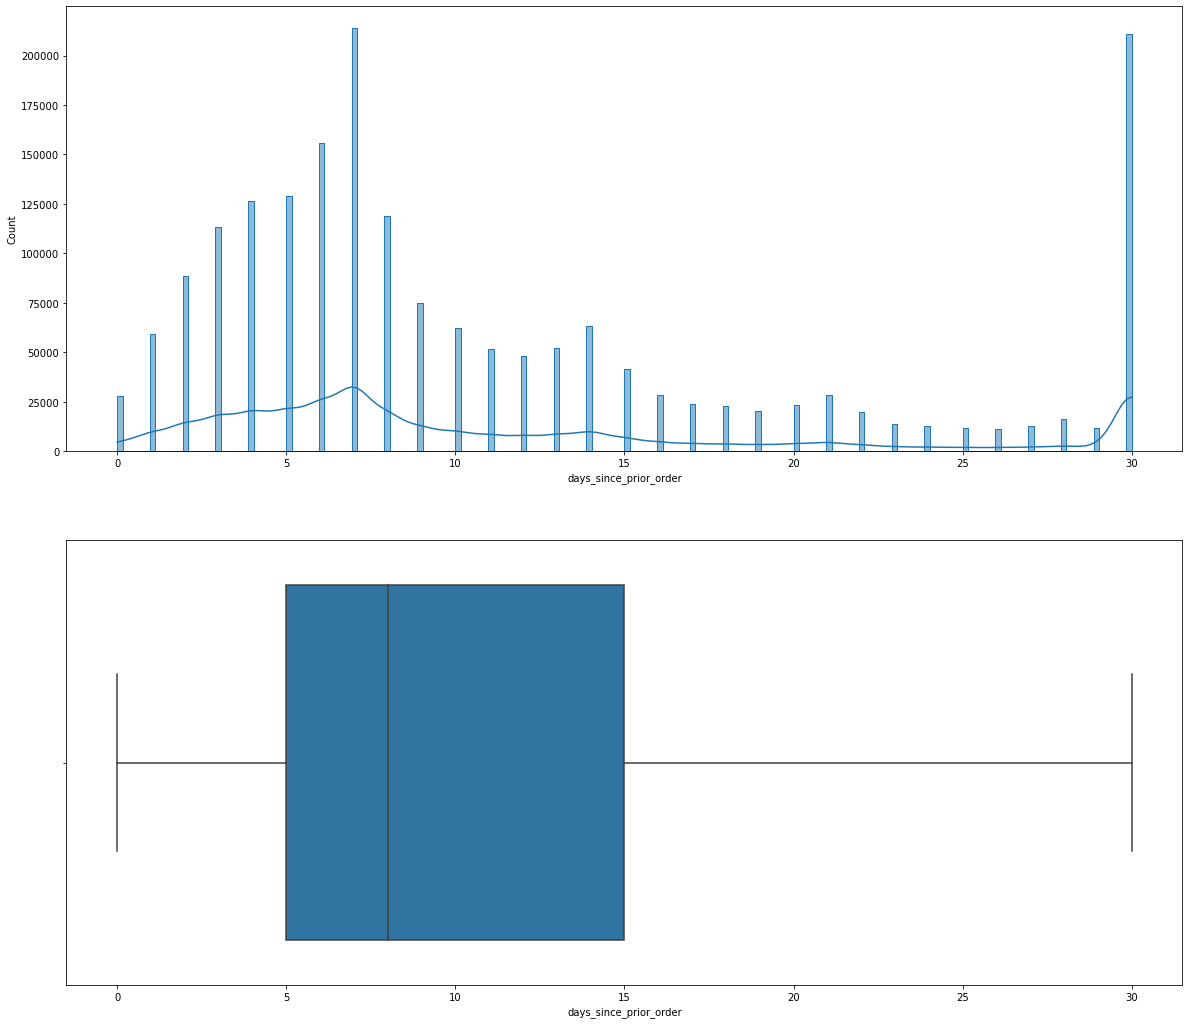

In [19]:
featureAnalysis('days_since_prior_order',dataset)

In [20]:
st.mode(dataset['days_since_prior_order'])

ModeResult(mode=array([7.]), count=array([214126]))

In [21]:
np.mean(dataset['days_since_prior_order'])

11.386034628229083

In [22]:
np.median(dataset['days_since_prior_order'].dropna(inplace=False))

8.0

In [23]:
minData = dataset[dataset['days_since_prior_order'] == 0].shape[0] 
maxData = dataset[dataset['days_since_prior_order'] == 30].shape[0]
medianData = dataset[dataset['days_since_prior_order'] == 8 ].shape[0]
modeData   = dataset[dataset['days_since_prior_order'] == 7].shape[0]
meanData   = dataset[dataset['days_since_prior_order'] == 11].shape[0]
All = minData + maxData + medianData + modeData + meanData

In [24]:
# print frequency of each values (zero , max, median , mode , mean)
print( "Zero : " + str(minData) + " percentage : " + str(minData/All))
print( "Max : "  + str(maxData)+  " percentage : " + str(maxData/All))
print( "Median : " + str(medianData)+ " percentage : " + str(medianData/All))
print( "Mode : " + str(modeData)+ " percentage : " + str(modeData/All))
print( "Mean : " + str(meanData)+ " percentage : " + str(meanData/All))

Zero : 27673 percentage : 0.04443242010818691
Max : 210814 percentage : 0.3384879200913279
Median : 118722 percentage : 0.19062283742580013
Mode : 214126 percentage : 0.3438057452421361
Mean : 51476 percentage : 0.08265107713254904


In [25]:
null_counts= dataset['days_since_prior_order'].isnull().sum()

In [26]:
total_nulls = dataset['days_since_prior_order'].isnull().sum()
num_nulls_to_fill_with_min = int(total_nulls * 0.04)
num_nulls_to_fill_with_max = int(total_nulls * 0.33)
num_nulls_to_fill_with_median = int(total_nulls * 0.20)
num_nulls_to_fill_with_mode = int(total_nulls * 0.34)
num_nulls_to_fill_with_mean = int(total_nulls * 0.09)


# Fill null values with specific numbers
dataset['days_since_prior_order'].fillna(value=0, limit=num_nulls_to_fill_with_min, inplace=True)
dataset['days_since_prior_order'].fillna(value=30, limit=num_nulls_to_fill_with_max, inplace=True)
dataset['days_since_prior_order'].fillna(value=8, limit=num_nulls_to_fill_with_median, inplace=True)
dataset['days_since_prior_order'].fillna(value=7, limit=num_nulls_to_fill_with_mode, inplace=True)
dataset['days_since_prior_order'].fillna(value=11, limit=num_nulls_to_fill_with_mean, inplace=True)



In [27]:
null_counts= dataset['days_since_prior_order'].isnull().sum()
null_counts

3

In [28]:
dataset['days_since_prior_order'].fillna(value=12, inplace=True)

In [29]:
null_counts= dataset['days_since_prior_order'].isnull().sum()
null_counts

0

,count,mean,std,min,25%,50%,75%,max
days_since_prior_order,2019501.0,11.600543,9.131322,0.0,5.0,8.0,16.0,30.0


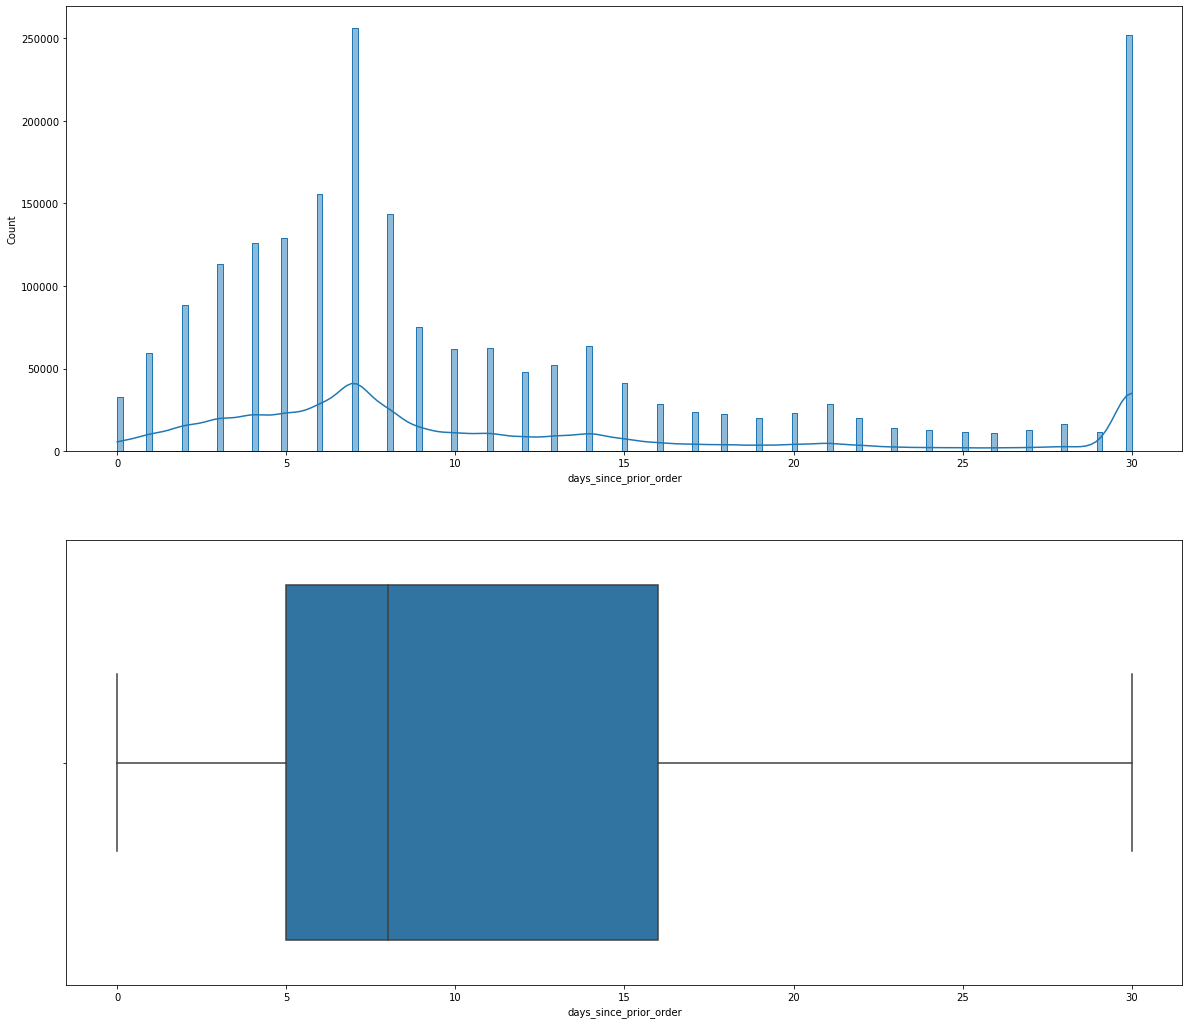

In [30]:
featureAnalysis('days_since_prior_order',dataset)

,count,mean,std,min,25%,50%,75%,max
days_since_prior_order,1895159.0,11.386035,8.97098,0.0,5.0,8.0,15.0,30.0


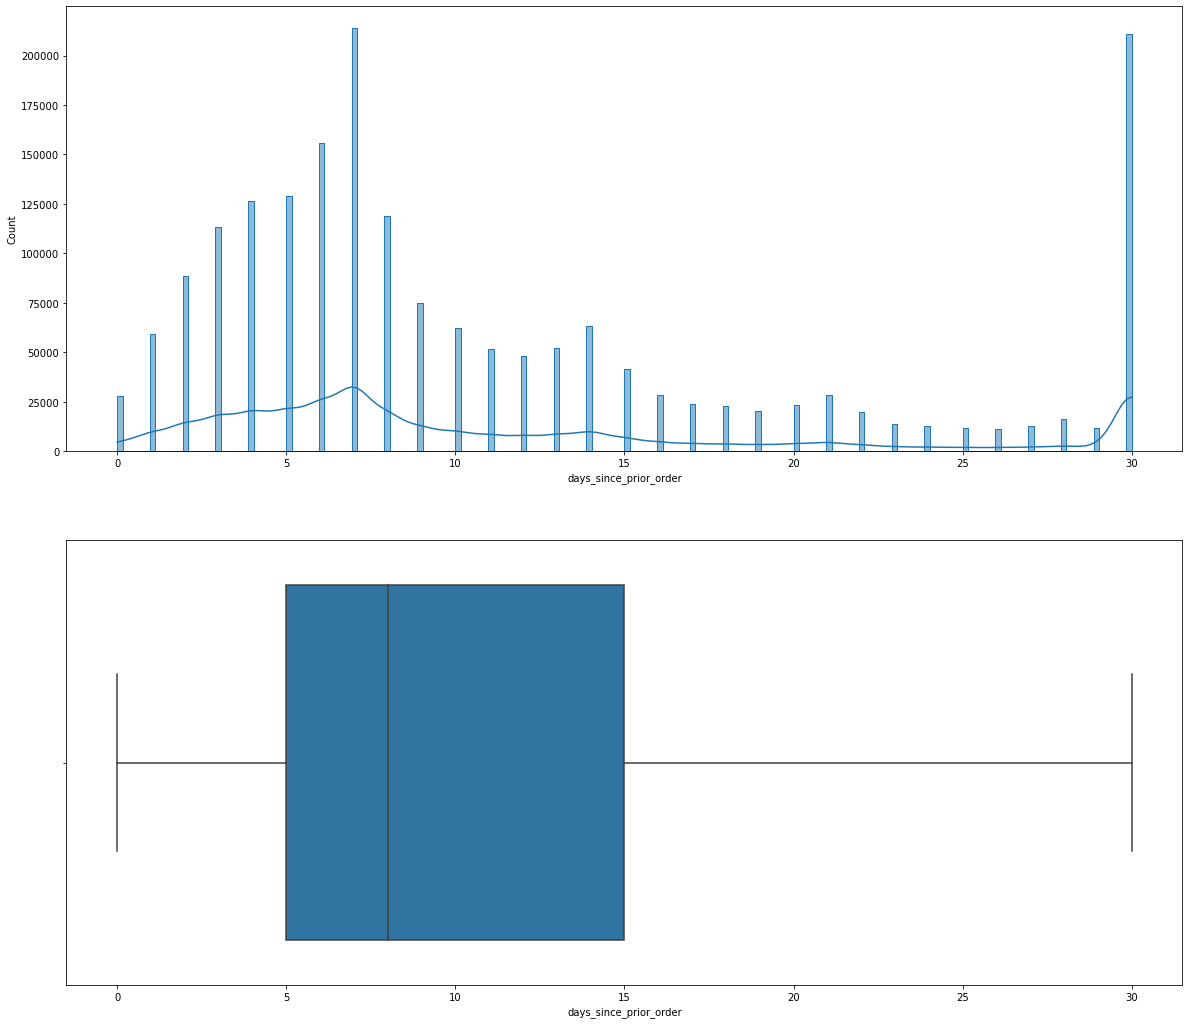

In [31]:
featureAnalysis('days_since_prior_order',dataset_orginal)

In [32]:
dataset.isnull().sum()

order_id                  0
user_id                   0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
department_id             0
department                0
product_name              0
dtype: int64

In [33]:
dataset_null = dataset.copy()

<a name="1.4"></a>
### Quick Overview on dataset

In [34]:
unique_count = {}
for column in dataset.columns:
    unique_count[column] = len(dataset[column].unique())

In [35]:
unique_count

{'order_id': 200000,
 'user_id': 105273,
 'order_number': 100,
 'order_dow': 7,
 'order_hour_of_day': 24,
 'days_since_prior_order': 31,
 'product_id': 134,
 'add_to_cart_order': 137,
 'reordered': 2,
 'department_id': 21,
 'department': 21,
 'product_name': 134}

**Observe Large unique valuse in the 'order_id' and 'user_id'**

In [36]:
unique_count['order_id'] / dataset.shape[0]

0.09903436541997256

In [37]:
unique_count['user_id'] / dataset.shape[0]

0.05212822375428385

**But they could still be worthy in the scale of the dataset records**

In [38]:
low_unique_values = dataset.drop(['user_id' , 'order_id' , 'product_name','department'],  axis=1)

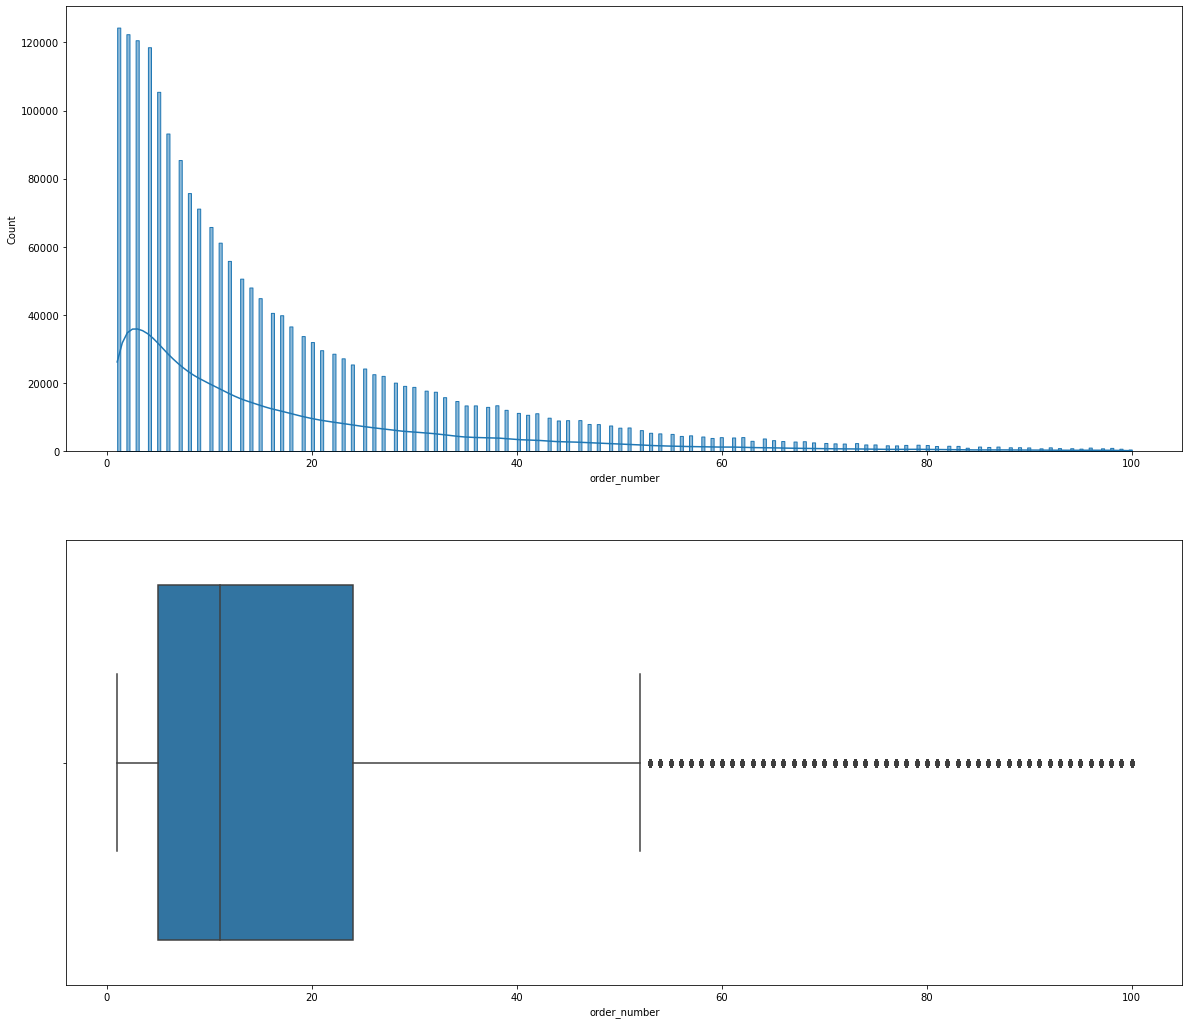

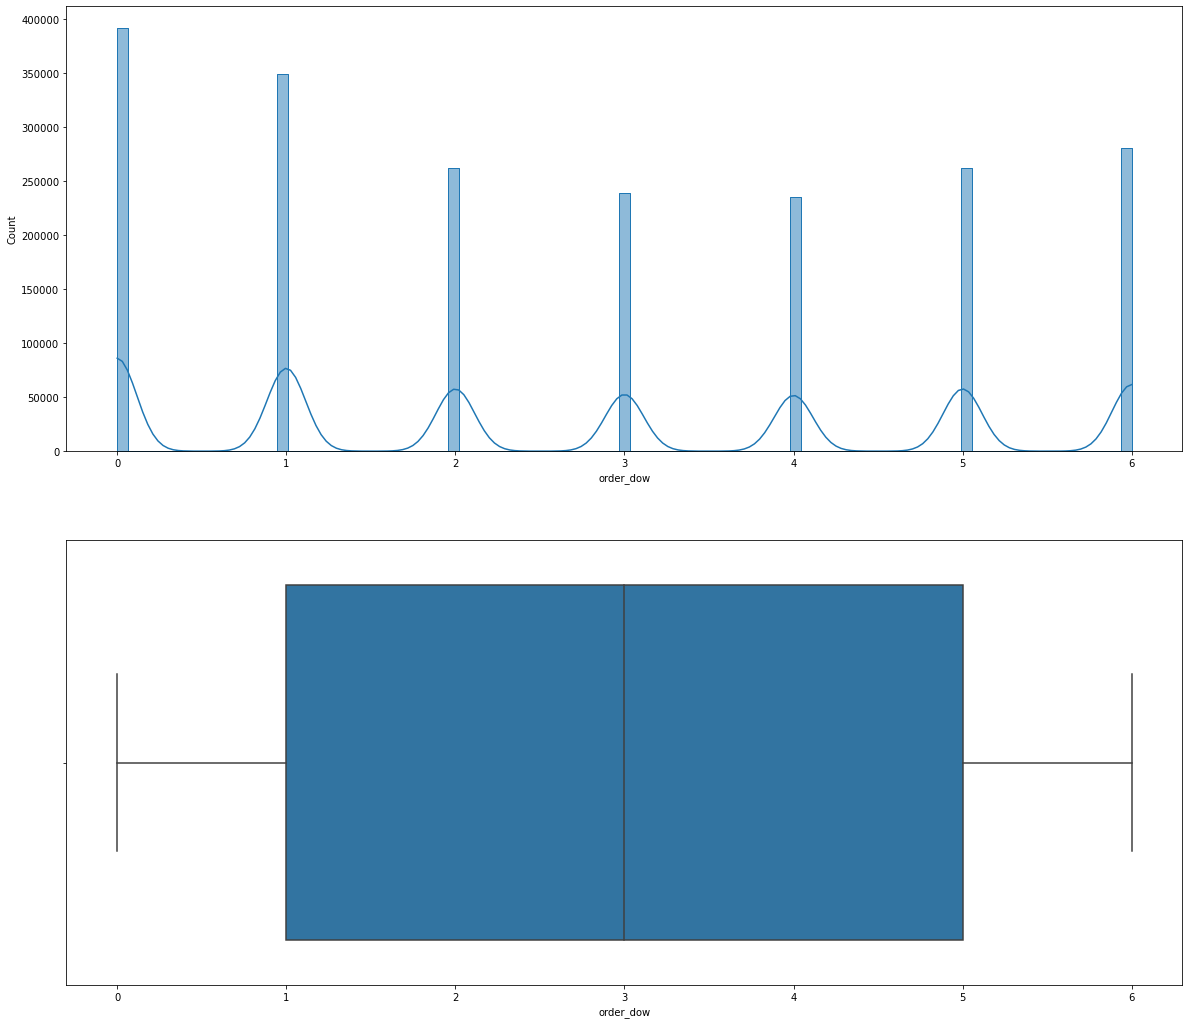

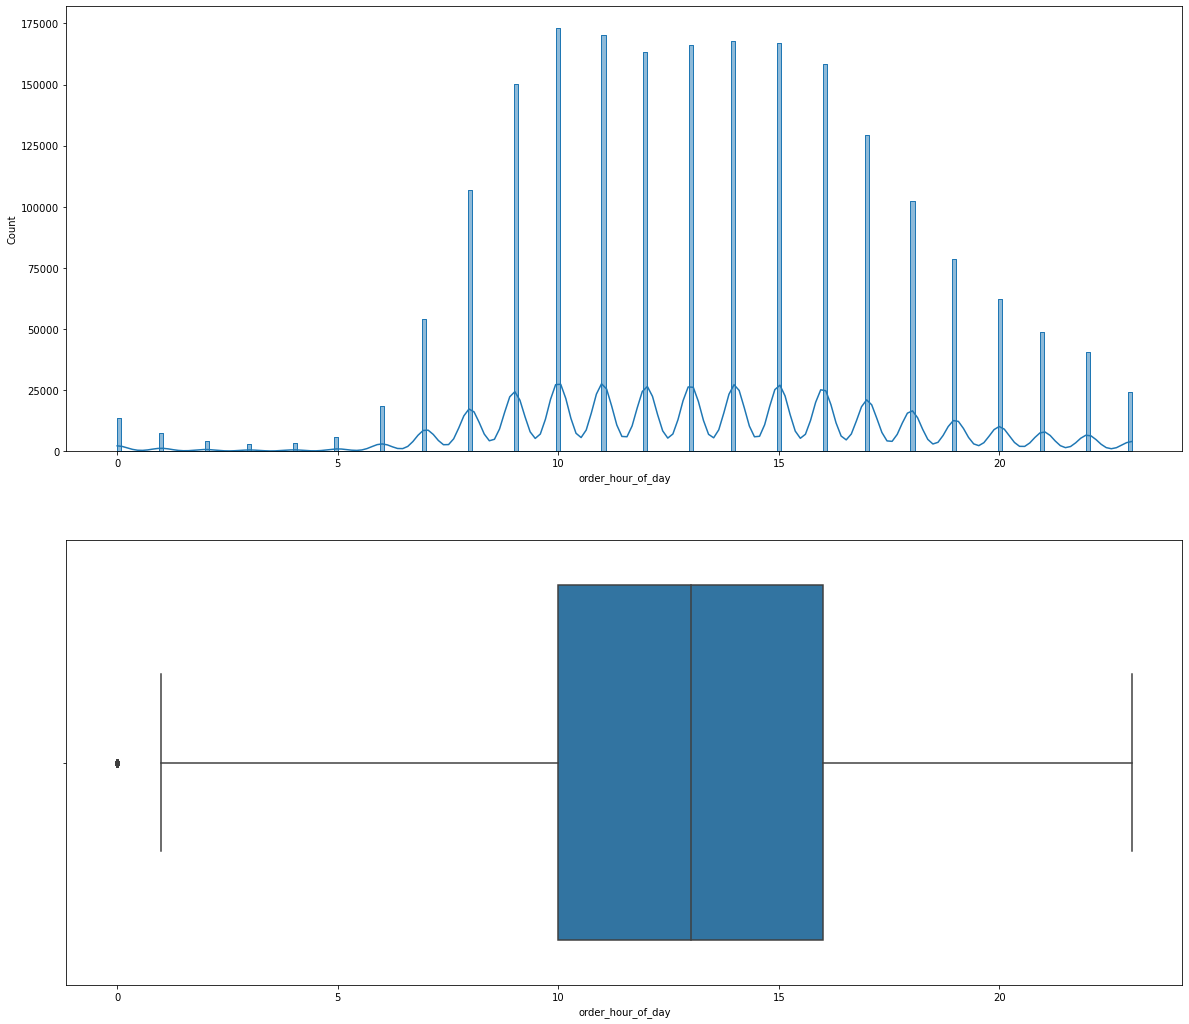

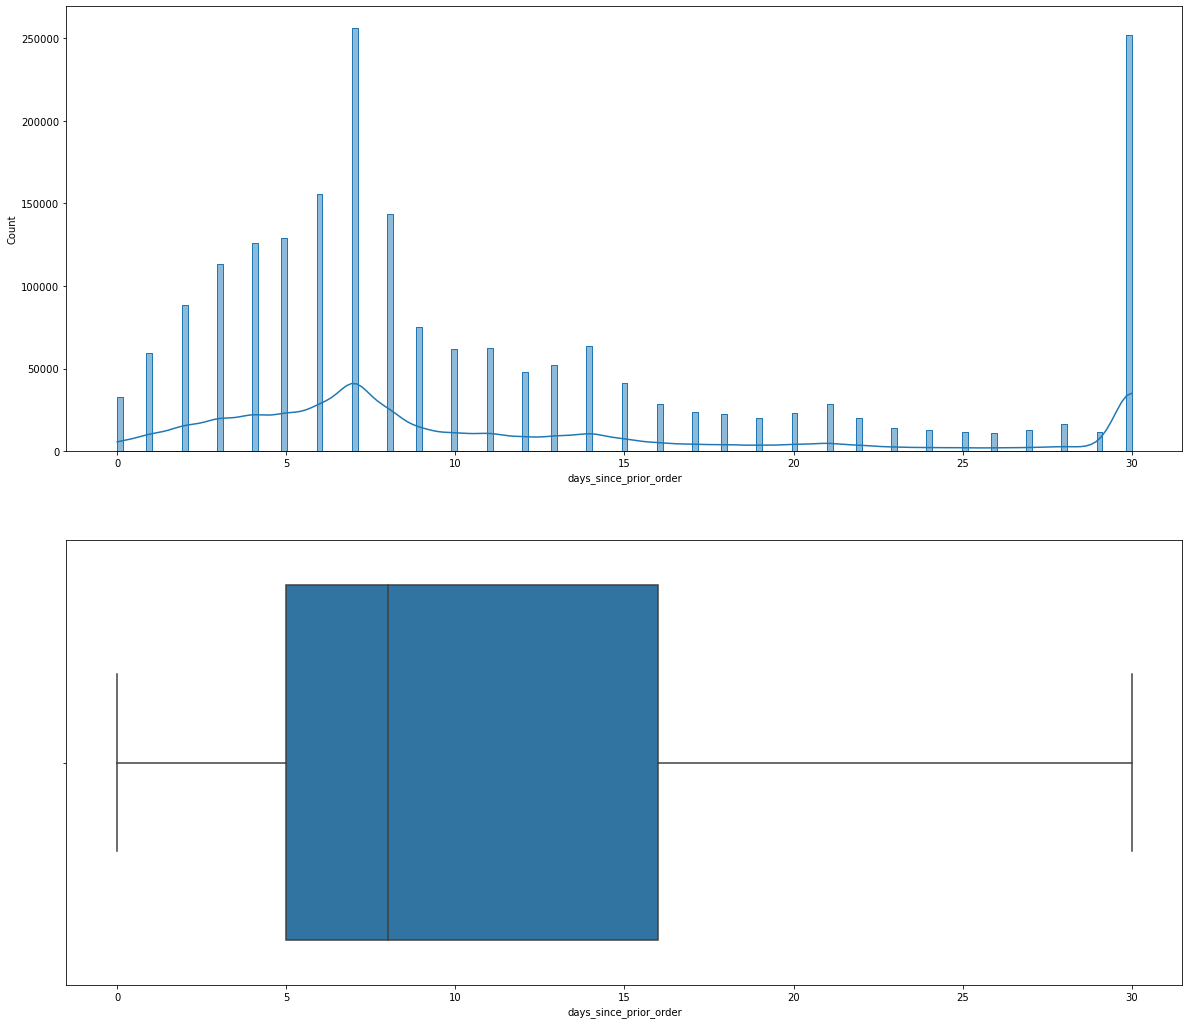

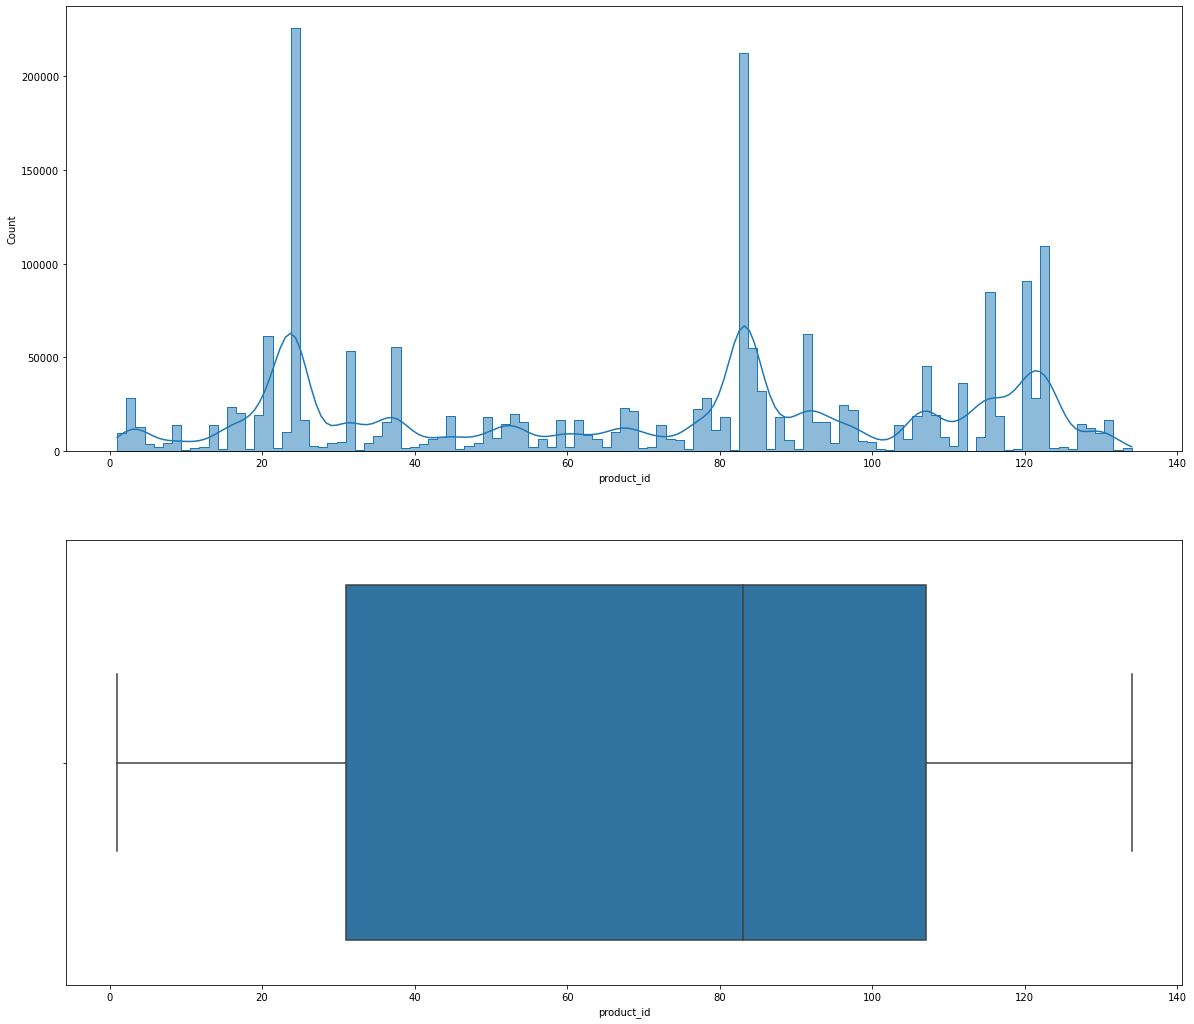

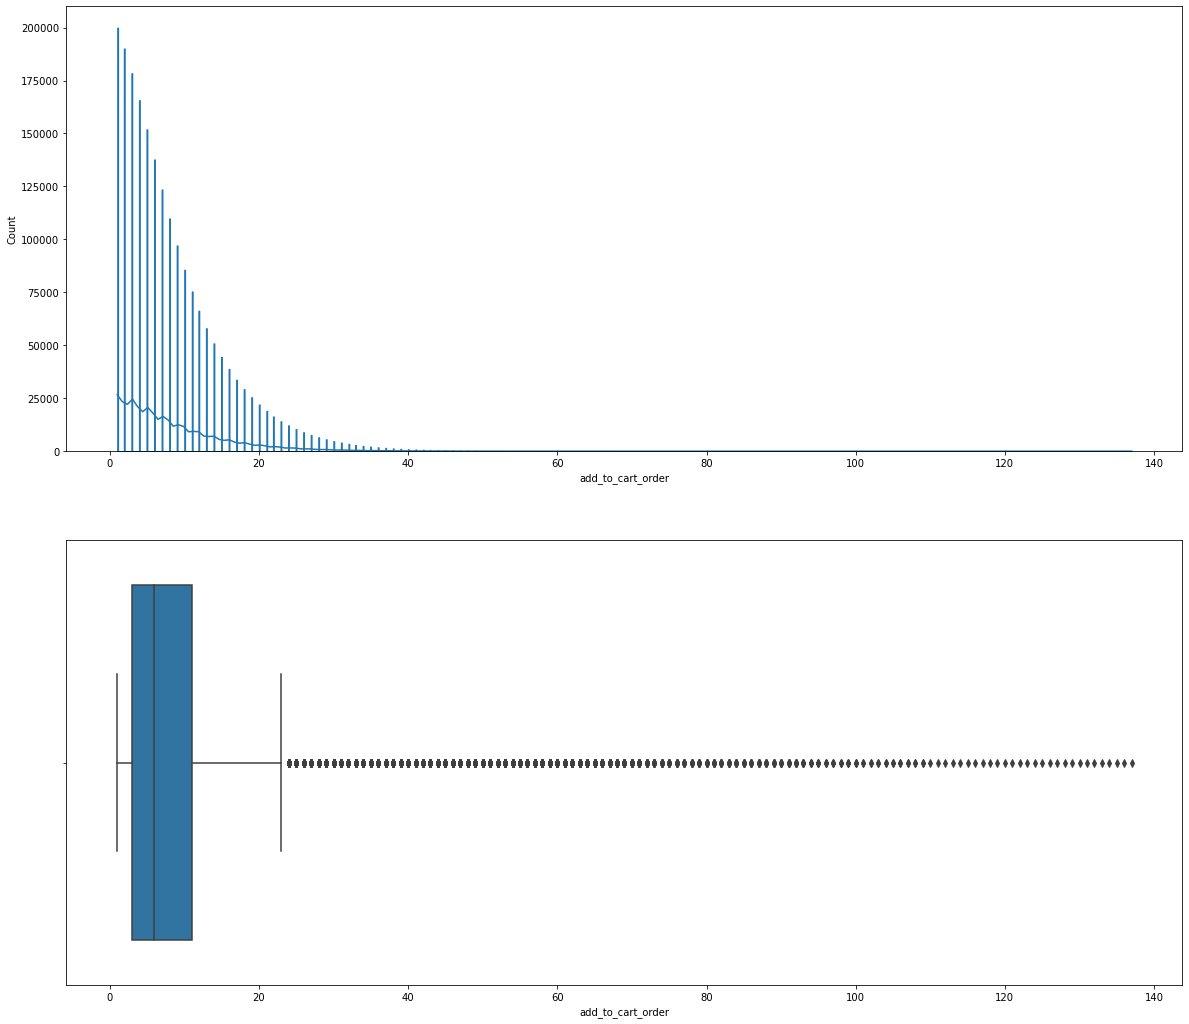

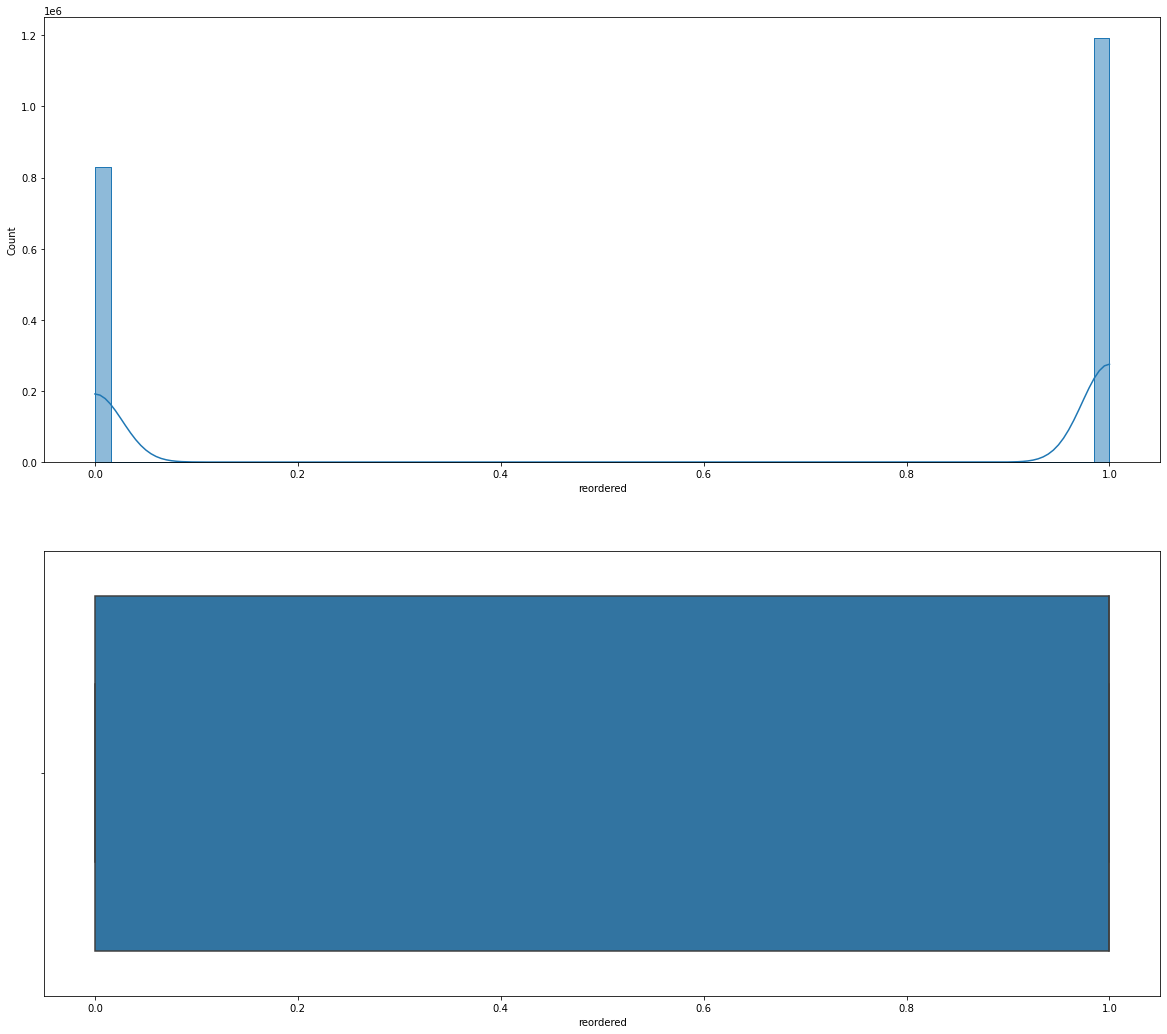

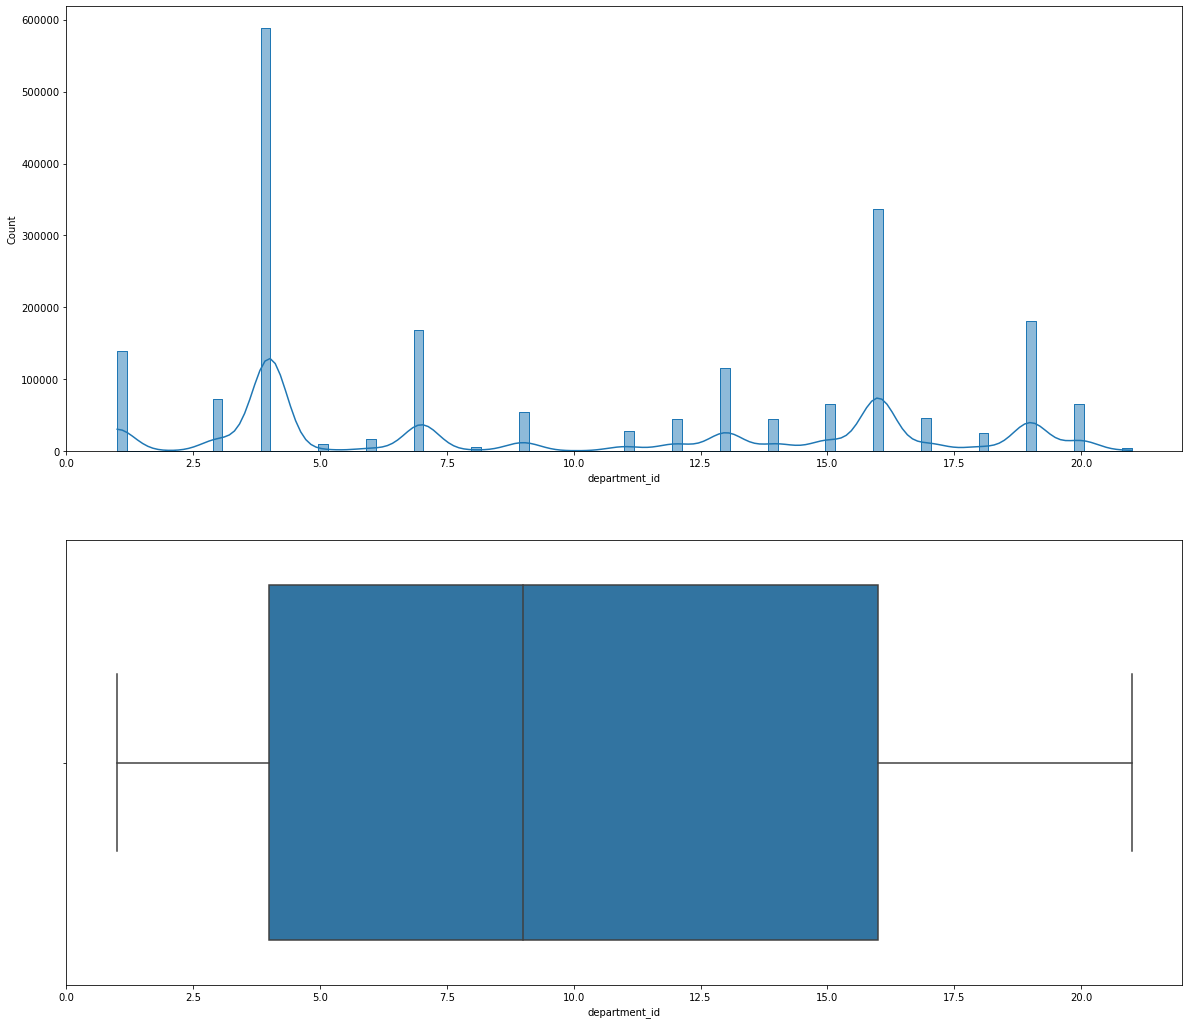

In [39]:
for column in low_unique_values.columns:
    featureAnalysis(column,low_unique_values)

In [40]:
#Using department_id and product_id instead of department and product_name so we drop them 
dataset.drop('product_name',inplace=True,axis=1)
dataset.drop('department',inplace=True,axis=1)

#### Time Based plot

<AxesSubplot:xlabel='order_hour_of_day', ylabel='order_number'>

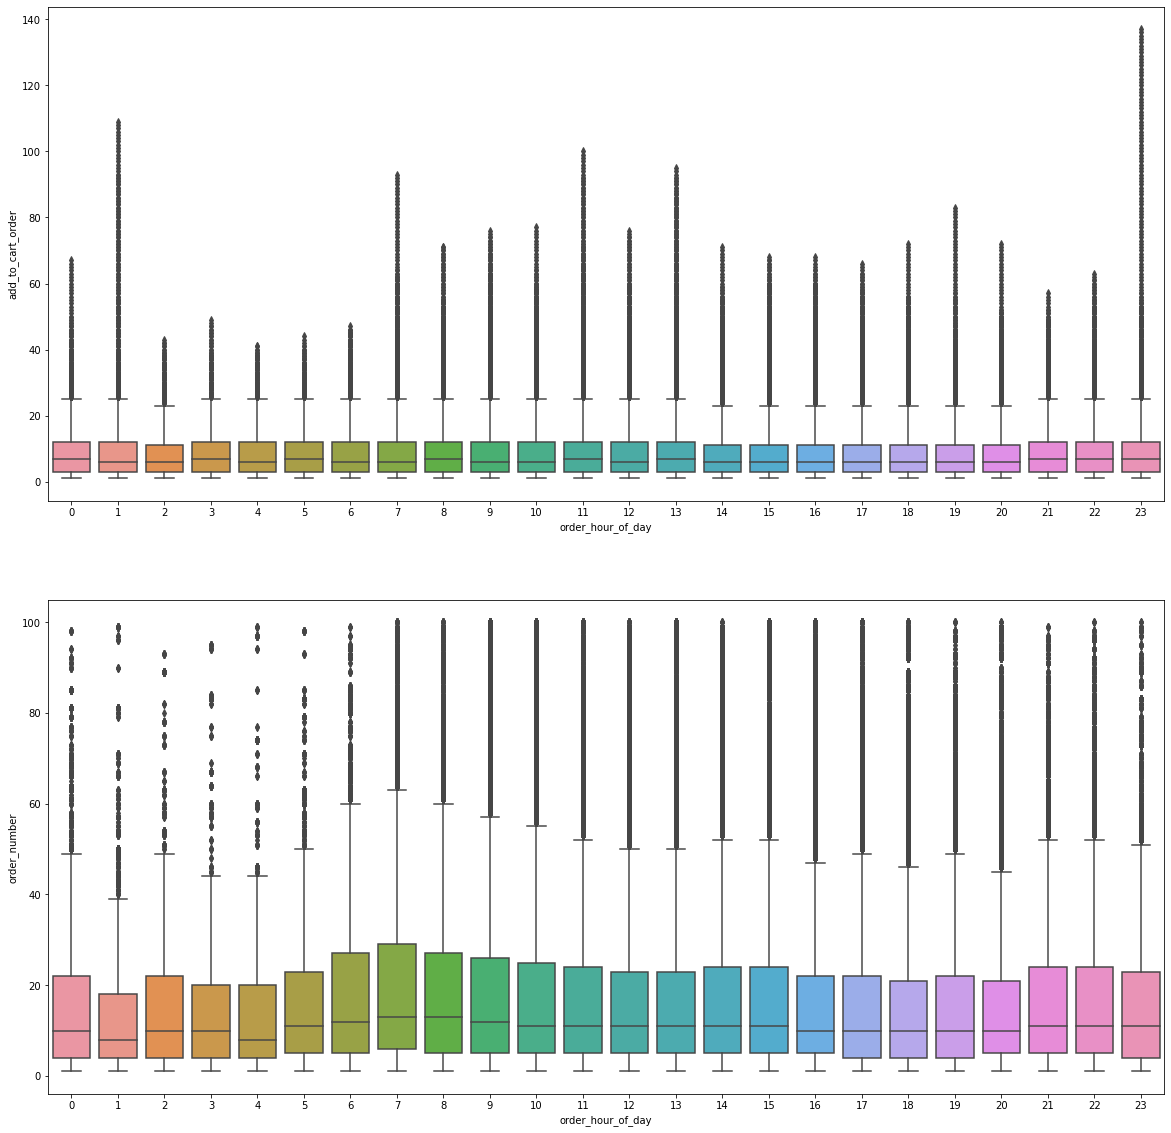

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
sns.boxplot(data=dataset , x = 'order_hour_of_day' , y = 'add_to_cart_order',ax=ax[0])
sns.boxplot(data=dataset , x = 'order_hour_of_day' , y = 'order_number',ax=ax[1])

<AxesSubplot:xlabel='order_dow', ylabel='order_number'>

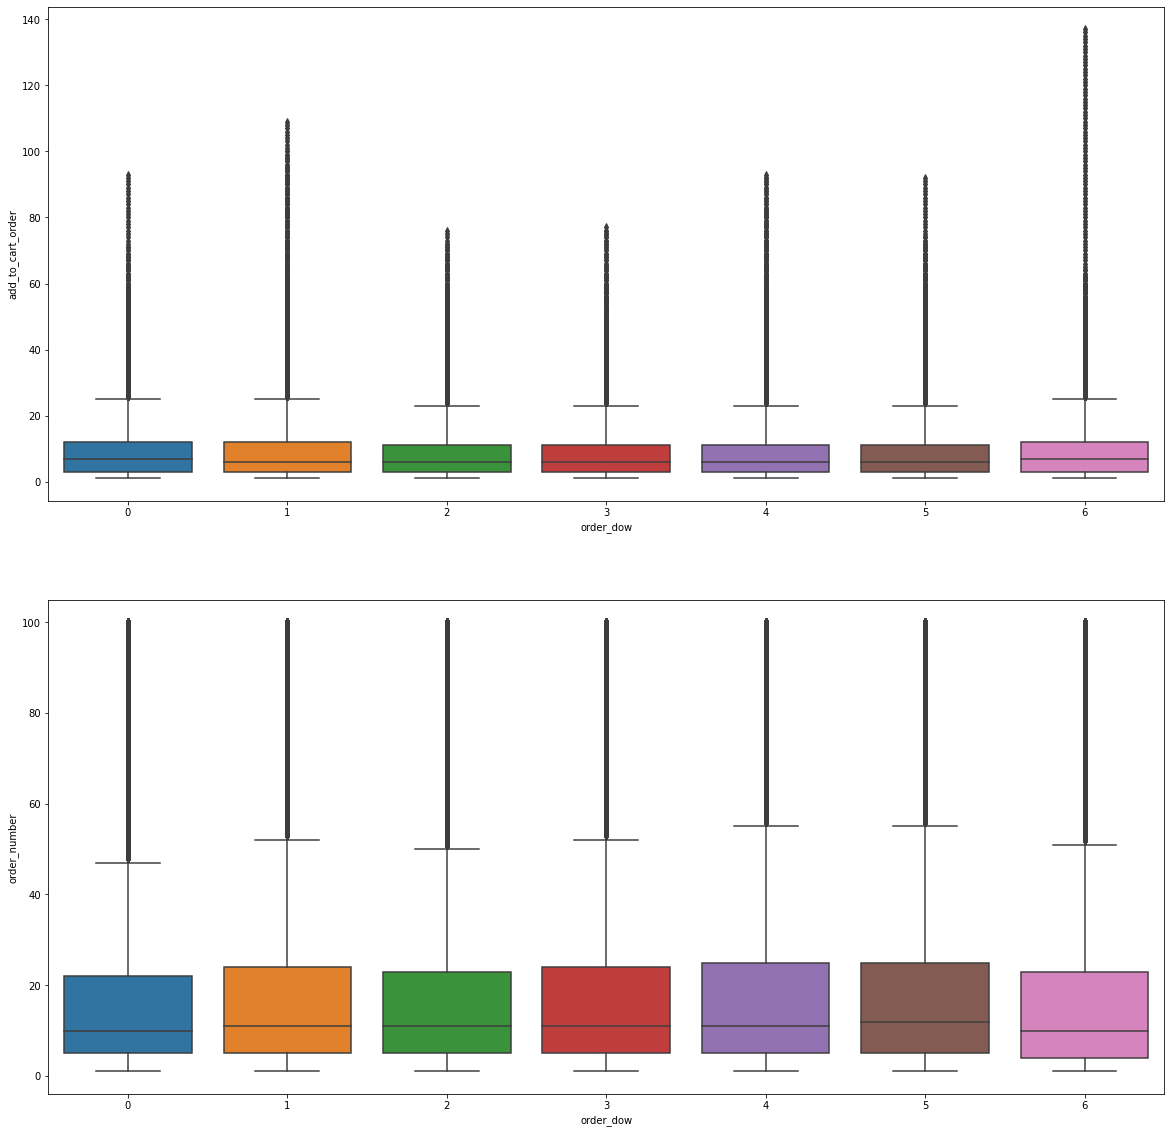

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
sns.boxplot(data=dataset , x = 'order_dow' , y = 'add_to_cart_order',ax=ax[0])
sns.boxplot(data=dataset , x = 'order_dow' , y = 'order_number',ax=ax[1])

<AxesSubplot:xlabel='days_since_prior_order', ylabel='order_number'>

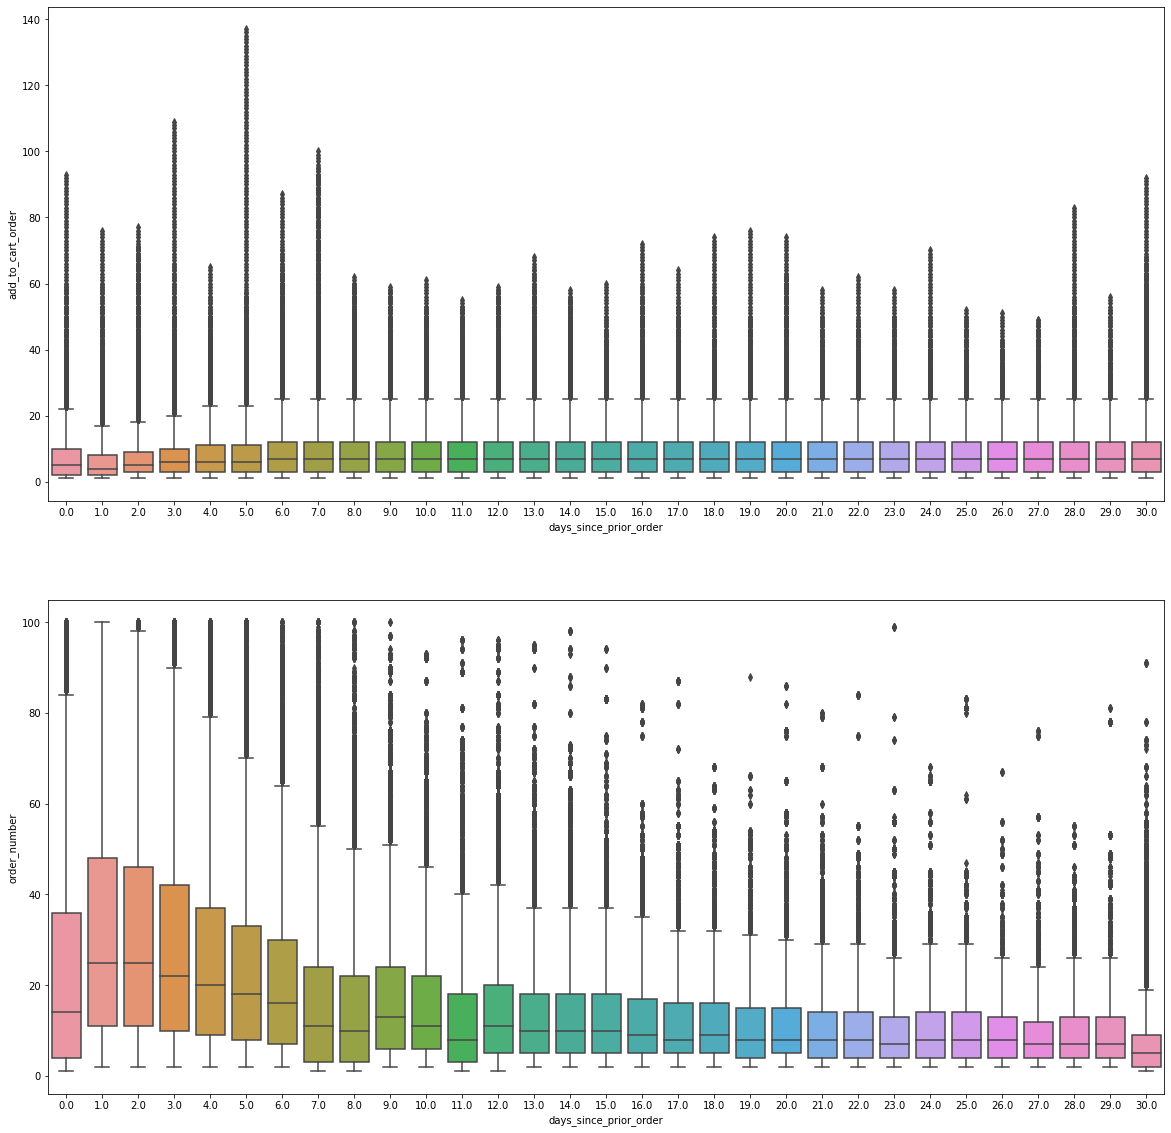

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
sns.boxplot(data=dataset , x = 'days_since_prior_order' , y = 'add_to_cart_order',ax=ax[0])
sns.boxplot(data=dataset , x = 'days_since_prior_order' , y = 'order_number',ax=ax[1])

# 

<a name="1.50"></a>
### Adding customers based Featues

In [44]:
dataset_behaviour = dataset.copy()

In [45]:
dataset

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id
0,2425083,49125,1,2,18,0.0,17,1,0,13
1,2425083,49125,1,2,18,0.0,91,2,0,16
2,2425083,49125,1,2,18,0.0,36,3,0,16
3,2425083,49125,1,2,18,0.0,83,4,0,4
4,2425083,49125,1,2,18,0.0,83,5,0,4
...,...,...,...,...,...,...,...,...,...,...
2019496,3390742,199430,16,3,18,5.0,83,8,0,4
2019497,458285,128787,42,2,19,3.0,115,1,1,7
2019498,458285,128787,42,2,19,3.0,32,2,1,4
2019499,458285,128787,42,2,19,3.0,32,3,1,4


In [46]:
len(dataset['user_id'].unique().tolist())

105273

#### Favorite ones

In [47]:
#---favorite order_hour_of_day
grouped = dataset.groupby(["user_id", "order_hour_of_day"]).size().reset_index(name="count")
max_values = grouped.groupby("user_id")["order_hour_of_day"].agg(lambda x: x.value_counts().index[0]).reset_index()
dataset = pd.merge(dataset, max_values, on="user_id", how="left")
dataset.rename(columns={"order_hour_of_day": "favorite_order_hour_of_day"}, inplace=True)

In [48]:
#---favorite product_id
grouped = dataset.groupby(["user_id", "product_id"]).size().reset_index(name="count")
max_values = grouped.groupby("user_id")["product_id"].agg(lambda x: x.value_counts().index[0]).reset_index()
dataset = pd.merge(dataset, max_values, on="user_id", how="left")
dataset.rename(columns={"product_id": "favorite_product_id"}, inplace=True)

In [49]:
#---favorite department_id
grouped = dataset.groupby(["user_id", "department_id"]).size().reset_index(name="count")
max_values = grouped.groupby("user_id")["department_id"].agg(lambda x: x.value_counts().index[0]).reset_index()
dataset = pd.merge(dataset, max_values, on="user_id", how="left")
dataset.rename(columns={"department_id": "favorite_department_id"}, inplace=True)

In [50]:
#mean of add_to_cart_order
mean = dataset.groupby("user_id")["add_to_cart_order"].mean().reset_index()
mean.rename(columns={"add_to_cart_order": "mean_add_to_cart_order"}, inplace=True)
dataset = pd.merge(dataset, mean, on="user_id", how="left")

In [51]:
dataset

,order_id,user_id,order_number,order_dow,order_hour_of_day_x,days_since_prior_order,product_id_x,add_to_cart_order,reordered,department_id_x,order_hour_of_day_y,product_id_y,department_id_y,mean_add_to_cart_order
0,2425083,49125,1,2,18,0.0,17,1,0,13,14,17,4,4.259259
1,2425083,49125,1,2,18,0.0,91,2,0,16,14,17,4,4.259259
2,2425083,49125,1,2,18,0.0,36,3,0,16,14,17,4,4.259259
3,2425083,49125,1,2,18,0.0,83,4,0,4,14,17,4,4.259259
4,2425083,49125,1,2,18,0.0,83,5,0,4,14,17,4,4.259259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019496,3390742,199430,16,3,18,5.0,83,8,0,4,13,2,1,9.161290
2019497,458285,128787,42,2,19,3.0,115,1,1,7,8,18,1,3.294118
2019498,458285,128787,42,2,19,3.0,32,2,1,4,8,18,1,3.294118
2019499,458285,128787,42,2,19,3.0,32,3,1,4,8,18,1,3.294118


In [52]:
dataset.isnull().sum()

order_id                  0
user_id                   0
order_number              0
order_dow                 0
order_hour_of_day_x       0
days_since_prior_order    0
product_id_x              0
add_to_cart_order         0
reordered                 0
department_id_x           0
order_hour_of_day_y       0
product_id_y              0
department_id_y           0
mean_add_to_cart_order    0
dtype: int64

<a name="1.5"></a>
## Outlier detection
Clustering and PCA are sensitve to outliers 

In [53]:
dataset_outlier = dataset.copy()

In [54]:
outlierDetection(dataset)

[('order_id', 0),
 ('user_id', 0),
 ('order_dow', 0),
 ('days_since_prior_order', 0),
 ('product_id_x', 0),
 ('reordered', 0),
 ('department_id_x', 0),
 ('order_hour_of_day_x', 13481),
 ('product_id_y', 41336),
 ('mean_add_to_cart_order', 52273),
 ('department_id_y', 53064),
 ('order_hour_of_day_y', 71479),
 ('add_to_cart_order', 84751),
 ('order_number', 110169)]

In [55]:
#using Qcut to make unique values less for features with high outliers number
bin_boundaries = [0, 4, 8, 12, 16, 20, 24]
bin_labels = [1, 2, 3, 4, 5, 6]
dataset['order_hour_of_day_x'] = pd.cut(dataset['order_hour_of_day_x'], bins=bin_boundaries, labels=bin_labels, right=False)
dataset['order_hour_of_day_y'] = pd.cut(dataset['order_hour_of_day_y'], bins=bin_boundaries, labels=bin_labels, right=False)

In [56]:
dataset['order_hour_of_day_x'].unique()

[5, 3, 1, 2, 4, 6]
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [57]:
dataset['order_hour_of_day_x'].isnull().sum()

0

In [58]:
dataset['order_hour_of_day_x'] = dataset['order_hour_of_day_x'].astype(int)
dataset['order_hour_of_day_y'] = dataset['order_hour_of_day_y'].astype(int)

,count,mean,std,min,25%,50%,75%,max
order_hour_of_day_y,2019501.0,3.418247,1.02643,1.0,3.0,3.0,4.0,6.0


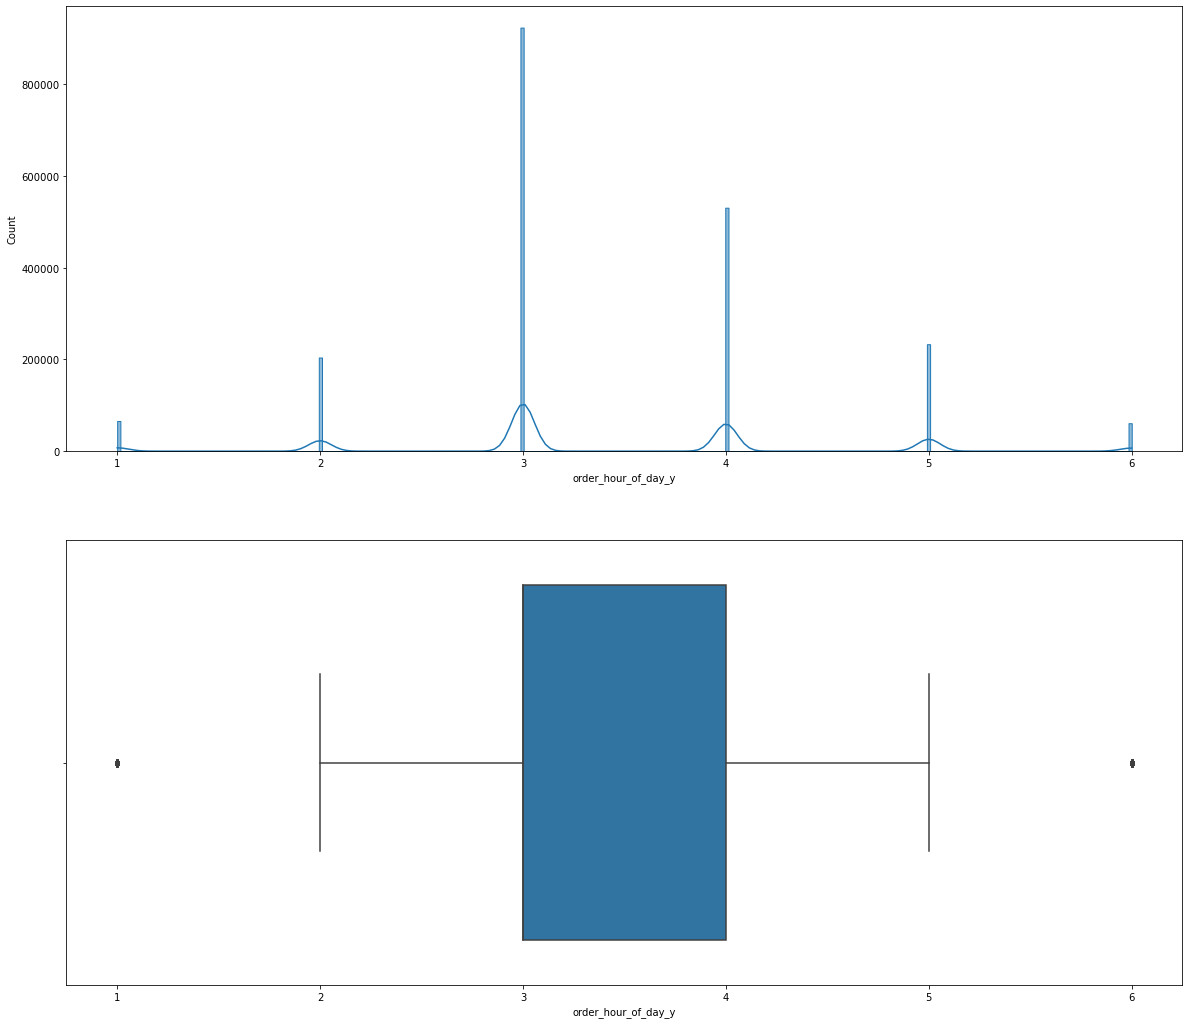

In [59]:
featureAnalysis('order_hour_of_day_y',dataset)

In [60]:
outlierDetection(dataset)

[('order_id', 0),
 ('user_id', 0),
 ('order_dow', 0),
 ('days_since_prior_order', 0),
 ('product_id_x', 0),
 ('reordered', 0),
 ('department_id_x', 0),
 ('product_id_y', 41336),
 ('mean_add_to_cart_order', 52273),
 ('department_id_y', 53064),
 ('add_to_cart_order', 84751),
 ('order_number', 110169)]

**Considering the size of dataset and PCA and clustering sensitivity to Outliers maybe we can remove them**

In [61]:
dataset = remove_outliers_iqr(dataset,'order_number')
outlierDetection(dataset)

[('order_id', 0),
 ('user_id', 0),
 ('order_dow', 0),
 ('days_since_prior_order', 0),
 ('product_id_x', 0),
 ('reordered', 0),
 ('department_id_x', 0),
 ('product_id_y', 40835),
 ('order_number', 43491),
 ('mean_add_to_cart_order', 48771),
 ('department_id_y', 52086),
 ('add_to_cart_order', 58759)]

In [62]:
dataset.shape

(1909332, 14)

In [63]:
dataset = remove_outliers_iqr(dataset,'add_to_cart_order')
outlierDetection(dataset)

[('order_id', 0),
 ('user_id', 0),
 ('order_dow', 0),
 ('days_since_prior_order', 0),
 ('product_id_x', 0),
 ('reordered', 0),
 ('department_id_x', 0),
 ('add_to_cart_order', 21630),
 ('mean_add_to_cart_order', 35604),
 ('product_id_y', 36813),
 ('order_number', 41929),
 ('department_id_y', 52021)]

In [64]:
dataset = remove_outliers_iqr(dataset,'order_number')
outlierDetection(dataset)

[('order_id', 0),
 ('user_id', 0),
 ('order_dow', 0),
 ('days_since_prior_order', 0),
 ('product_id_x', 0),
 ('reordered', 0),
 ('department_id_x', 0),
 ('order_number', 17563),
 ('add_to_cart_order', 21114),
 ('mean_add_to_cart_order', 34453),
 ('product_id_y', 36651),
 ('department_id_y', 51633)]

In [65]:
dataset = remove_outliers_iqr(dataset,'add_to_cart_order')
outlierDetection(dataset)

[('order_id', 0),
 ('user_id', 0),
 ('order_dow', 0),
 ('days_since_prior_order', 0),
 ('product_id_x', 0),
 ('add_to_cart_order', 0),
 ('reordered', 0),
 ('department_id_x', 0),
 ('order_number', 17340),
 ('product_id_y', 36646),
 ('mean_add_to_cart_order', 37467),
 ('department_id_y', 51596)]

In [66]:
dataset.shape

(1787530, 14)

,count,mean,std,min,25%,50%,75%,max
add_to_cart_order,1787530.0,7.426453,5.426494,1.0,3.0,6.0,11.0,23.0


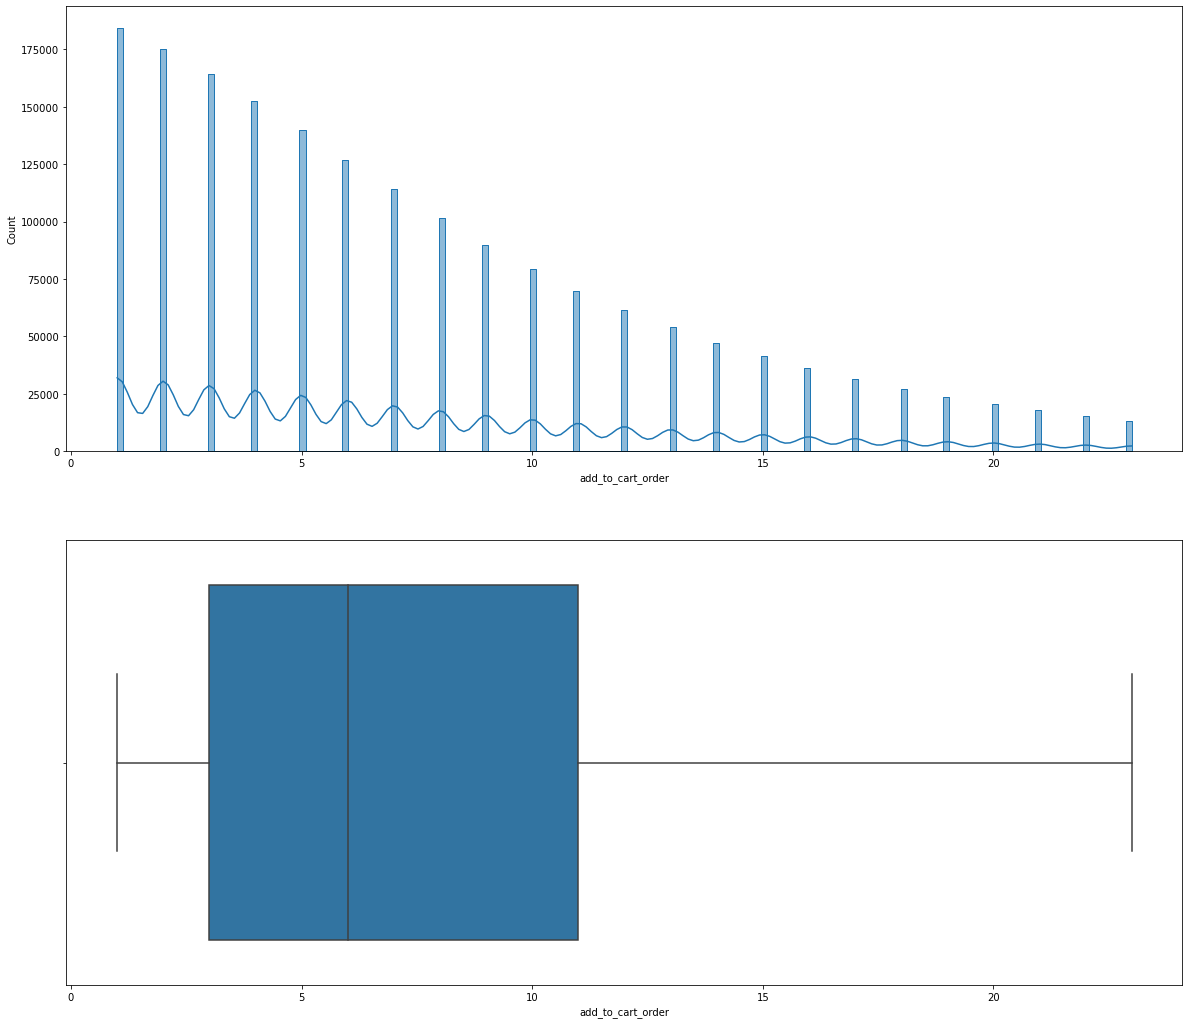

In [68]:
featureAnalysis('add_to_cart_order',dataset)

,count,mean,std,min,25%,50%,75%,max
order_number,1787530.0,13.336601,11.310824,1.0,4.0,10.0,20.0,46.0


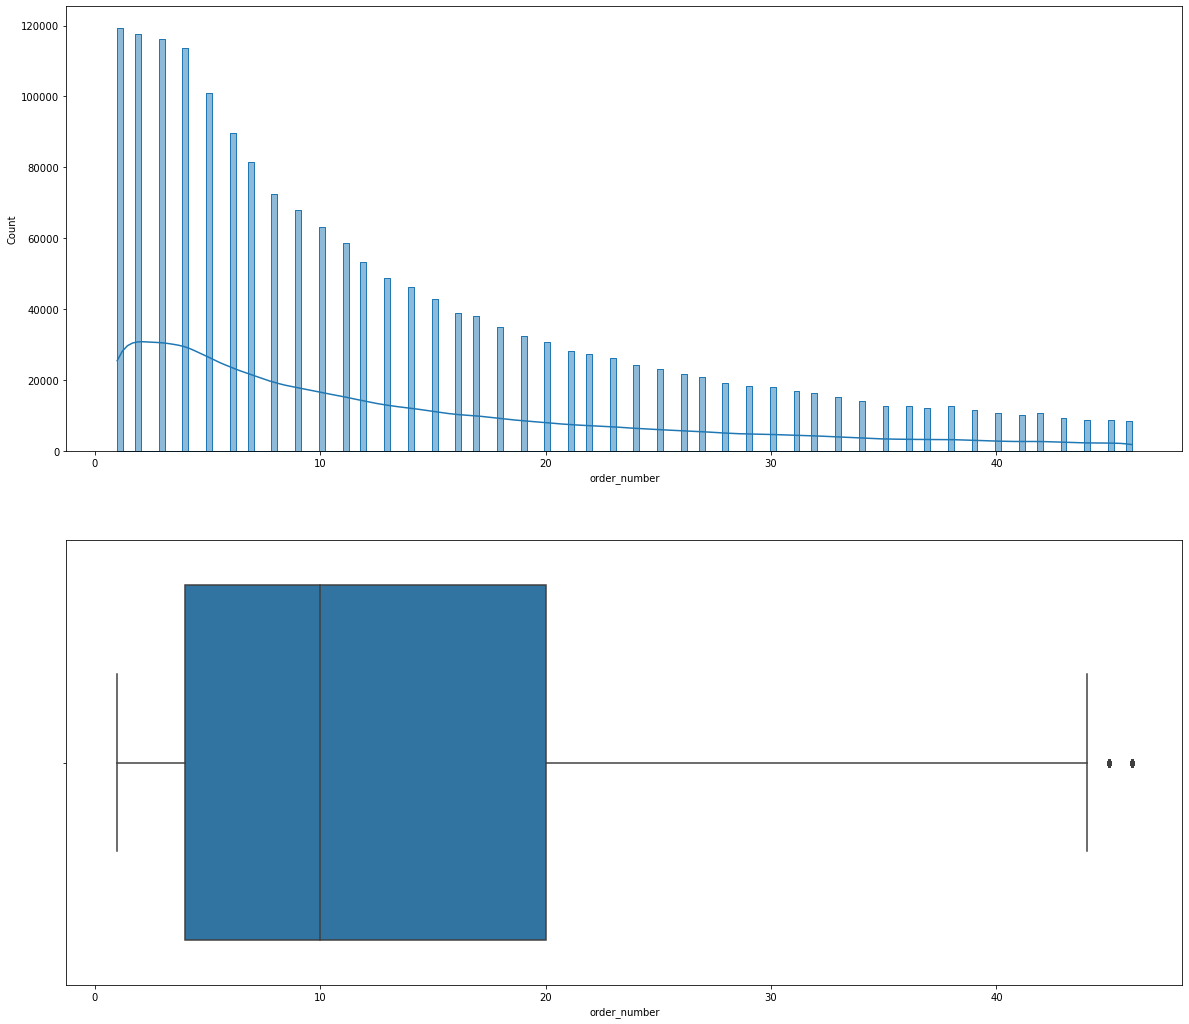

In [69]:
featureAnalysis('order_number',dataset)

**PCA is affected by scale, so you need to scale the features in your data before applying PCA.**

In [70]:
dataset['department_id_x'].unique()

array([13, 16,  4, 15, 12,  1,  3,  7, 14, 19,  6, 17, 11, 18, 20,  9, 21,
        5,  8,  2, 10], dtype=int64)

In [71]:
#Scale features 
features_to_scale = ['order_number', 'order_dow','days_since_prior_order','product_id_x','add_to_cart_order']
scaleNeeded = dataset[features_to_scale]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaleNeeded)
dataset[features_to_scale] = scaled_data

In [72]:
dataset.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day_x,days_since_prior_order,product_id_x,add_to_cart_order,reordered,department_id_x,order_hour_of_day_y,product_id_y,department_id_y,mean_add_to_cart_order
count,1.787530e+06,1.787530e+06,1.787530e+06,1.787530e+06,1.787530e+06,1.787530e+06,1.787530e+06,1.787530e+06,1.787530e+06,1.787530e+06,1.787530e+06,1.787530e+06,1.787530e+06,1.787530e+06
mean,1.706676e+06,1.030672e+05,7.216728e-15,-1.760200e-14,3.996898e+00,4.927747e-13,-1.499568e-18,3.345833e-15,5.768317e-01,9.902919e+00,3.465278e+00,1.274163e+01,2.040958e+00,8.014947e+00
std,9.866915e+05,5.949118e+04,1.000000e+00,1.000000e+00,1.076516e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.940618e-01,6.279139e+00,1.029649e+00,1.253433e+01,1.857271e+00,3.919600e+00
min,1.000000e+01,2.000000e+00,-1.090690e+00,-1.300636e+00,1.000000e+00,-1.315276e+00,-1.838444e+00,-1.184274e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,8.506930e+05,5.157200e+04,-8.254575e-01,-8.238428e-01,3.000000e+00,-6.640648e-01,-1.052623e+00,-8.157115e-01,0.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,1.000000e+00,5.113636e+00
50%,1.703657e+06,1.026490e+05,-2.949920e-01,1.297444e-01,4.000000e+00,-4.469945e-01,3.094655e-01,-2.628683e-01,1.000000e+00,9.000000e+00,3.000000e+00,9.000000e+00,1.000000e+00,7.486486e+00
75%,2.560517e+06,1.546570e+05,5.891172e-01,1.083331e+00,5.000000e+00,5.298223e-01,9.381219e-01,6.585372e-01,1.000000e+00,1.600000e+01,4.000000e+00,2.000000e+01,3.000000e+00,1.020833e+01
max,3.421080e+06,2.062090e+05,2.887801e+00,1.560125e+00,6.000000e+00,1.940780e+00,1.645360e+00,2.869910e+00,1.000000e+00,2.100000e+01,6.000000e+00,1.340000e+02,2.100000e+01,4.700000e+01


# 

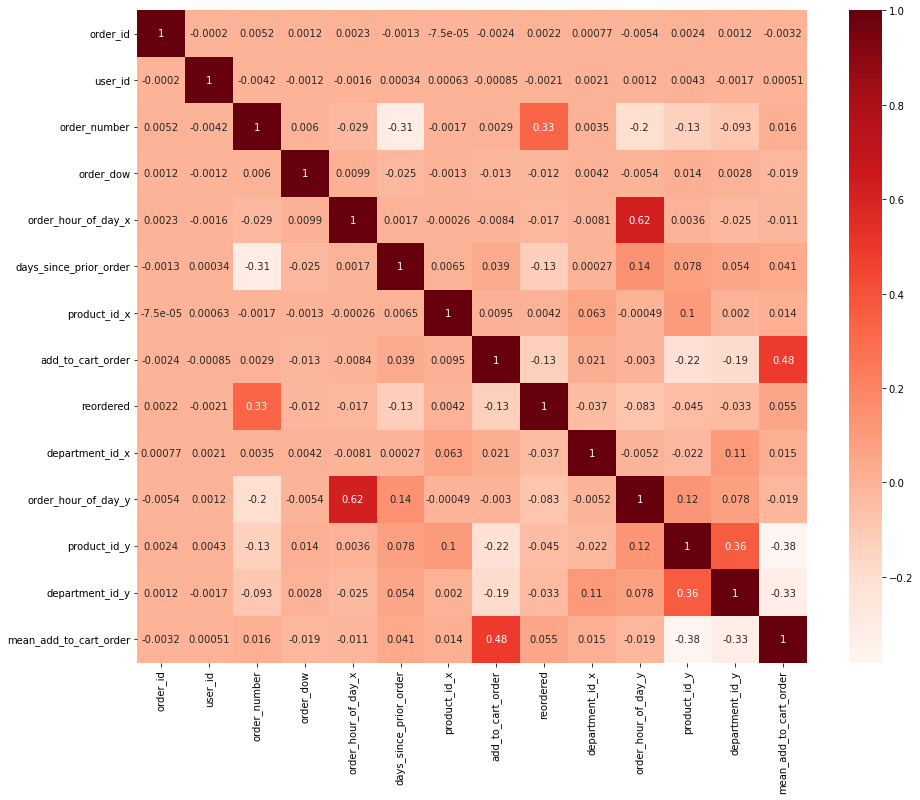

In [73]:
plt.figure(figsize=(15,12))
cor = dataset.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

array([[<AxesSubplot:title={'center':'order_id'}>,
        <AxesSubplot:title={'center':'user_id'}>,
        <AxesSubplot:title={'center':'order_number'}>,
        <AxesSubplot:title={'center':'order_dow'}>],
       [<AxesSubplot:title={'center':'order_hour_of_day_x'}>,
        <AxesSubplot:title={'center':'days_since_prior_order'}>,
        <AxesSubplot:title={'center':'product_id_x'}>,
        <AxesSubplot:title={'center':'add_to_cart_order'}>],
       [<AxesSubplot:title={'center':'reordered'}>,
        <AxesSubplot:title={'center':'department_id_x'}>,
        <AxesSubplot:title={'center':'order_hour_of_day_y'}>,
        <AxesSubplot:title={'center':'product_id_y'}>],
       [<AxesSubplot:title={'center':'department_id_y'}>,
        <AxesSubplot:title={'center':'mean_add_to_cart_order'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

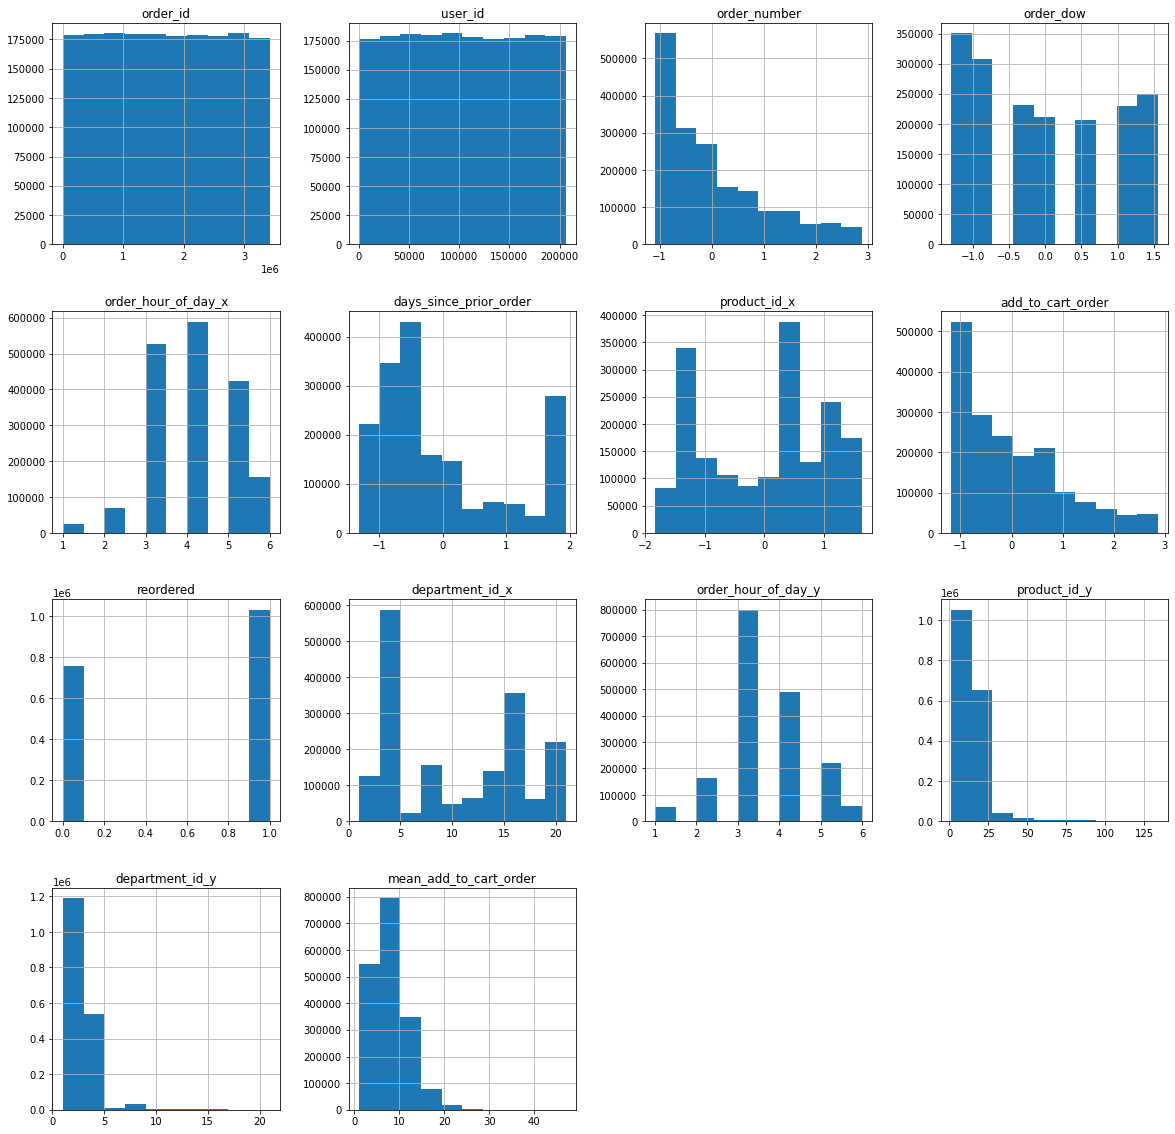

In [74]:
dataset.hist(figsize=(20,20))

In [74]:
#save changes
dataset_scale = dataset.copy()

# 

<a name="1.6"></a>
## Clustering on Customers

In [75]:
dataset

,order_id,user_id,order_number,order_dow,order_hour_of_day_x,days_since_prior_order,product_id_x,add_to_cart_order,reordered,department_id_x,order_hour_of_day_y,product_id_y,department_id_y,mean_add_to_cart_order
0,2425083,49125,-1.090690,-0.347049,5,-1.315276,-1.419340,-1.184274,0,13,4,17,4,4.259259
1,2425083,49125,-1.090690,-0.347049,5,-1.315276,0.519018,-0.999993,0,16,4,17,4,4.259259
2,2425083,49125,-1.090690,-0.347049,5,-1.315276,-0.921653,-0.815712,0,16,4,17,4,4.259259
3,2425083,49125,-1.090690,-0.347049,5,-1.315276,0.309466,-0.631430,0,4,4,17,4,4.259259
4,2425083,49125,-1.090690,-0.347049,5,-1.315276,0.309466,-0.447149,0,4,4,17,4,4.259259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019496,3390742,199430,0.235474,0.129744,5,-0.772600,0.309466,0.105694,0,4,4,2,1,9.161290
2019497,458285,128787,2.534157,-0.347049,5,-0.989670,1.147674,-1.184274,1,7,3,18,1,3.294118
2019498,458285,128787,2.534157,-0.347049,5,-0.989670,-1.026429,-0.999993,1,4,3,18,1,3.294118
2019499,458285,128787,2.534157,-0.347049,5,-0.989670,-1.026429,-0.815712,1,4,3,18,1,3.294118


In [76]:
len(dataset['user_id'].unique().tolist())

104799


**This quite large value to work it and do the segmenation on the customers**<br/>
<a name="1.6.1"></a>
### Sampling

In [77]:
sample50000= dataset.sample(n=50000)

In [78]:
sample50000

,order_id,user_id,order_number,order_dow,order_hour_of_day_x,days_since_prior_order,product_id_x,add_to_cart_order,reordered,department_id_x,order_hour_of_day_y,product_id_y,department_id_y,mean_add_to_cart_order
117947,3156984,48318,-0.648636,1.560125,6,-0.881135,-1.235981,-0.262868,0,4,4,8,1,7.240000
952161,2889244,148567,-0.913868,0.129744,4,0.421287,-0.607325,-0.447149,0,14,4,30,3,5.950000
1978707,2182099,52983,-0.029759,-1.300636,5,1.940780,0.309466,0.105694,1,4,2,2,1,8.517241
630586,1249859,51084,-0.737047,1.083331,3,-0.229924,-1.314563,-0.078587,0,16,3,9,1,9.000000
615819,511818,47330,0.147063,1.560125,5,1.940780,-1.235981,-0.815712,1,4,5,9,1,10.590909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211192,1800990,99813,0.589117,0.606538,3,0.421287,0.309466,-0.631430,1,4,3,4,1,11.500000
1188334,1121899,167526,-0.737047,-1.300636,3,-0.664065,0.309466,2.869910,1,4,3,4,1,12.512195
268362,2554725,205068,1.119583,0.129744,3,-0.989670,0.021331,0.289975,1,13,3,1,1,8.216667
1702542,2751529,152788,-0.294992,-0.347049,3,-1.206741,0.964316,-0.631430,1,16,3,3,1,14.000000


In [79]:
len(sample50000['user_id'].unique().tolist())

35245

**Still large**

In [80]:
#These are only usefull when we want to cluster customers
features = ['order_dow',
            'order_hour_of_day_x',
            'days_since_prior_order',
            'product_id_x',
            'add_to_cart_order',
            'reordered',
            'department_id_x',
            'order_hour_of_day_y',
            'product_id_y',
            'department_id_y',
            'mean_add_to_cart_order']

<a name="1.6.2"></a>
### 1. Kmeans

Silhouette scores (sorted in descending order):
Silhouette score for k=6: 0.3949133167244207
Silhouette score for k=5: 0.3872706135842142
Silhouette score for k=7: 0.35766023818378007
Silhouette score for k=8: 0.31769287638366206
Silhouette score for k=9: 0.2999827587645106
Silhouette score for k=10: 0.2608015254992985
Silhouette score for k=12: 0.2607507783271266
Silhouette score for k=11: 0.25984345538232323
Silhouette score for k=13: 0.2523224997632315
Silhouette score for k=14: 0.2506277539182407
Silhouette score for k=17: 0.2442591882672648
Silhouette score for k=15: 0.24249491578464288
Silhouette score for k=18: 0.23090268819362203
Silhouette score for k=16: 0.22782736780591242
Silhouette score for k=19: 0.2160660671613142


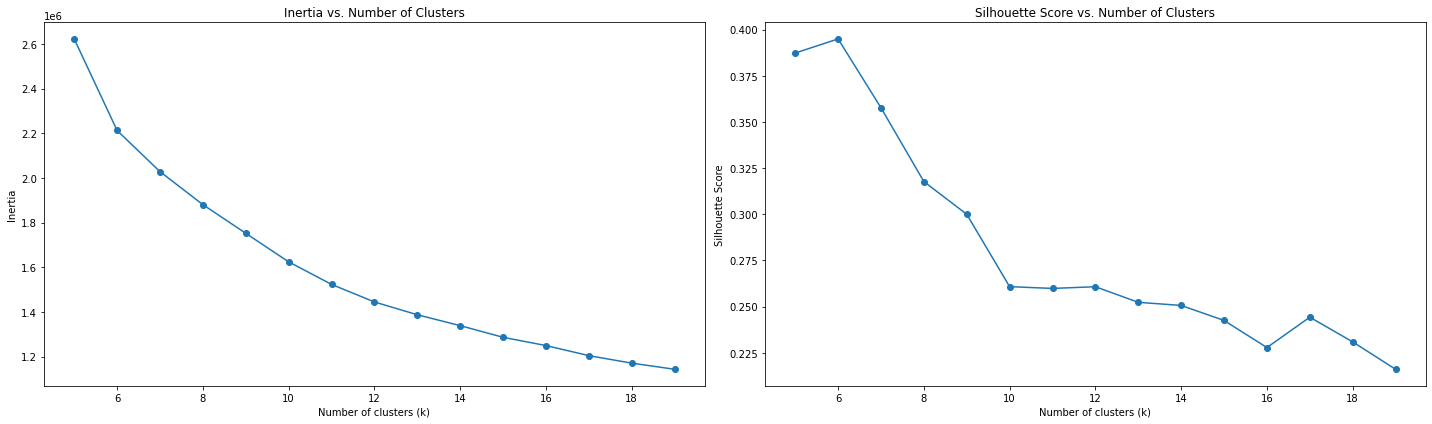

In [110]:
KmeansMethod(sample50000[features],5,20)

In [ ]:
#elbow and silhoutte => using k=6

In [111]:
featuresY = ['order_dow',
            'days_since_prior_order',
            'add_to_cart_order',
            'reordered',
            'order_hour_of_day_y',
            'product_id_y',
            'department_id_y',
            'mean_add_to_cart_order']

Silhouette scores (sorted in descending order):
Silhouette score for k=5: 0.41153182152034407
Silhouette score for k=7: 0.32631039800316436
Silhouette score for k=6: 0.3247908618986978
Silhouette score for k=8: 0.31782714889124053
Silhouette score for k=10: 0.315233166607751
Silhouette score for k=9: 0.31376496389183567
Silhouette score for k=11: 0.28844727838631545
Silhouette score for k=12: 0.2715297657578848
Silhouette score for k=13: 0.26653082190512467
Silhouette score for k=14: 0.24512533782991833
Silhouette score for k=17: 0.2344334742027005
Silhouette score for k=15: 0.2301792176456537
Silhouette score for k=16: 0.22840380833335264
Silhouette score for k=19: 0.21849942470371475
Silhouette score for k=18: 0.21592562995755787


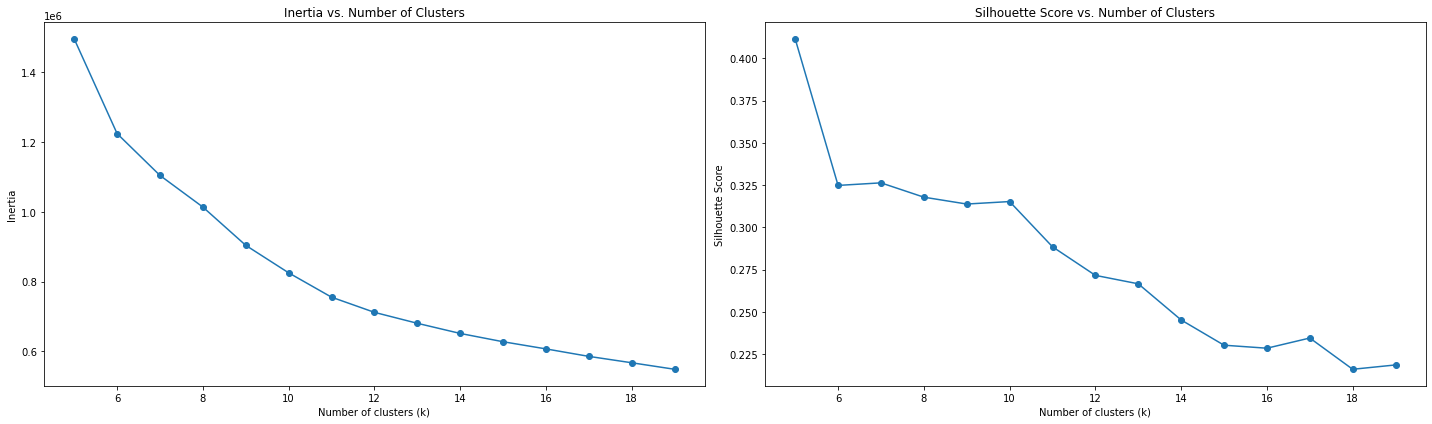

In [112]:
KmeansMethod(sample50000[featuresY],5,20)

In [113]:
featuresY2 = ['order_dow',
            'days_since_prior_order',
            'reordered',
            'order_hour_of_day_y',
            'product_id_y',
            'department_id_y',
            'mean_add_to_cart_order']

Silhouette scores (sorted in descending order):
Silhouette score for k=5: 0.41976676577681576
Silhouette score for k=7: 0.3355027254994742
Silhouette score for k=6: 0.3339010096377813
Silhouette score for k=10: 0.3267526108551223
Silhouette score for k=9: 0.32505765195982417
Silhouette score for k=8: 0.3247849496838811
Silhouette score for k=11: 0.2995709588166953
Silhouette score for k=12: 0.28203779158076064
Silhouette score for k=13: 0.2561576609010902
Silhouette score for k=14: 0.255302210955249
Silhouette score for k=15: 0.2531789076284008
Silhouette score for k=16: 0.23790021525010366
Silhouette score for k=19: 0.22506643608643861
Silhouette score for k=17: 0.22427950782513867
Silhouette score for k=18: 0.21950899363857315


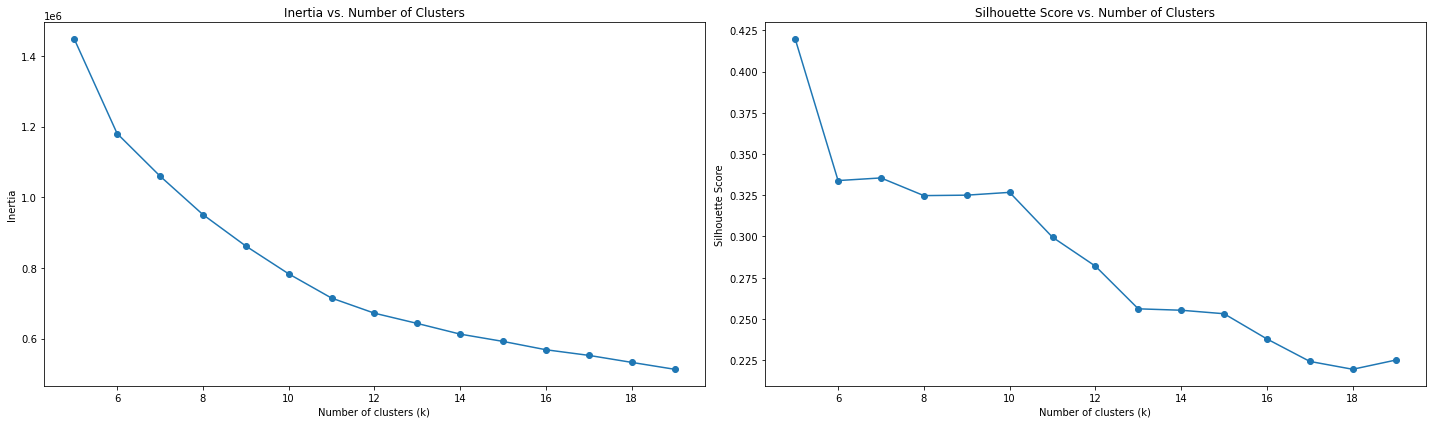

In [114]:
KmeansMethod(sample50000[featuresY2],5,20)

In [117]:
sample50000

,order_id,user_id,order_number,order_dow,order_hour_of_day_x,days_since_prior_order,product_id_x,add_to_cart_order,reordered,department_id_x,order_hour_of_day_y,product_id_y,department_id_y,mean_add_to_cart_order
365343,97404,81472,-0.471814,-1.300636,3,0.204217,0.440436,0.105694,0,13,3,3,1,7.571429
1116316,174600,49367,0.500706,0.129744,6,-0.338459,0.309466,0.474256,1,4,4,2,1,8.645833
760834,2191014,199507,-0.383403,0.606538,6,-0.664065,-0.738295,-0.078587,0,3,6,24,3,9.500000
1163542,2220217,177109,-1.090690,0.606538,5,-0.555530,-0.685907,2.869910,0,19,5,5,1,13.000000
1216219,3305017,147111,-0.294992,0.606538,4,-0.229924,-1.235981,2.685629,0,4,4,16,1,10.616667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929858,3213809,191068,-0.560225,-1.300636,3,0.529822,0.571406,0.289975,0,3,3,2,3,6.000000
1302803,395453,74594,-1.090690,0.129744,5,-0.555530,0.938122,-1.184274,0,19,5,6,1,16.000000
207983,2112581,107454,-1.002279,1.560125,5,1.940780,-0.921653,-0.999993,0,16,5,16,4,8.000000
980297,438653,128775,0.942761,1.560125,4,-0.446994,1.173868,1.211380,1,1,3,2,1,16.153846


In [118]:
sample50000.drop(['order_id','user_id'],inplace = True , axis=1)

In [122]:
IPCA_randomSample10 = IPCAmethod(sample50000,10,500)
IPCA_randomSample8 = IPCAmethod(sample50000,8,500)
IPCA_randomSample6 = IPCAmethod(sample50000,6,500)

Silhouette scores (sorted in descending order):
Silhouette score for k=6: 0.39241057559423653
Silhouette score for k=5: 0.3848566133947254
Silhouette score for k=7: 0.3550170439737456
Silhouette score for k=8: 0.31686868890213193
Silhouette score for k=9: 0.27588782357357633
Silhouette score for k=11: 0.26053380261898884
Silhouette score for k=10: 0.2582415500976745
Silhouette score for k=12: 0.2580659291141915
Silhouette score for k=13: 0.2513848542321119
Silhouette score for k=14: 0.24590432237556595
Silhouette score for k=15: 0.2340587911037758
Silhouette score for k=16: 0.2302868259055107
Silhouette score for k=18: 0.2290656417558261
Silhouette score for k=17: 0.22485464487753815
Silhouette score for k=19: 0.21676387607974207


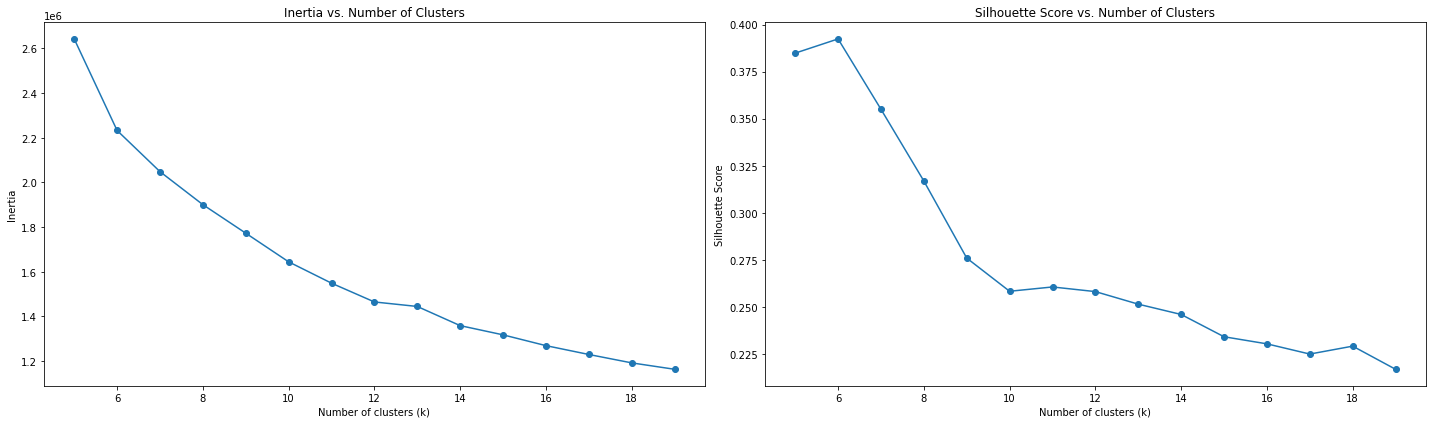

In [123]:
KmeansMethod(IPCA_randomSample10,5,20)

Silhouette scores (sorted in descending order):
Silhouette score for k=6: 0.4017105298881628
Silhouette score for k=5: 0.3938984344938028
Silhouette score for k=7: 0.3664927457802761
Silhouette score for k=8: 0.32583863179598316
Silhouette score for k=9: 0.3081620889985955
Silhouette score for k=11: 0.27086384874206526
Silhouette score for k=10: 0.26794261627978566
Silhouette score for k=14: 0.2631741096946547
Silhouette score for k=13: 0.2605505822575489
Silhouette score for k=12: 0.25955602181646775
Silhouette score for k=17: 0.2529916623437825
Silhouette score for k=15: 0.25127948064570604
Silhouette score for k=18: 0.2399222583280078
Silhouette score for k=16: 0.23597319767903577
Silhouette score for k=19: 0.227439820593889


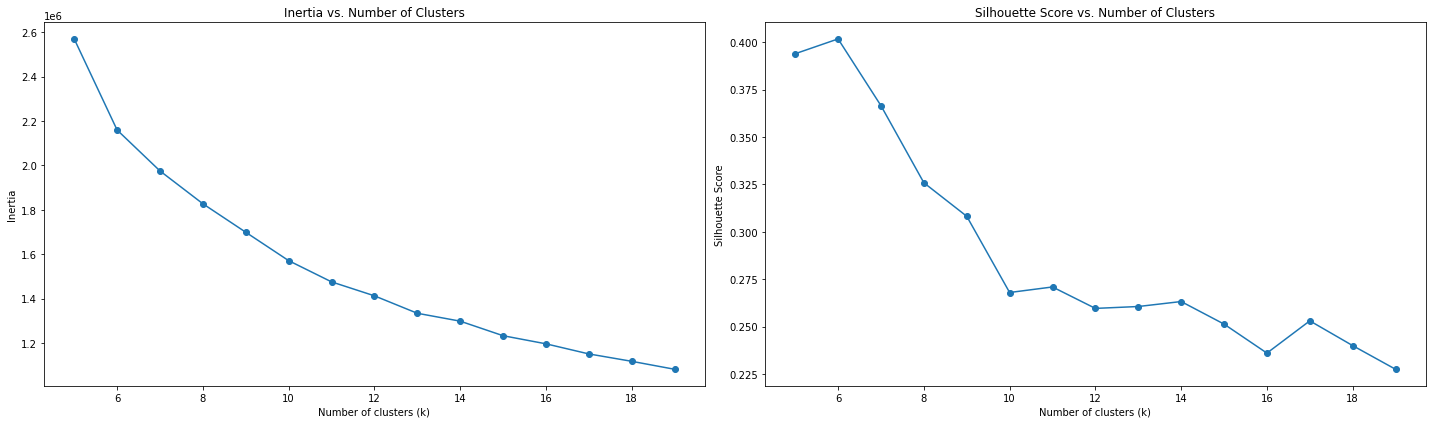

In [124]:
KmeansMethod(IPCA_randomSample8,5,20)

Silhouette scores (sorted in descending order):
Silhouette score for k=6: 0.4156920436888368
Silhouette score for k=5: 0.40751262108401876
Silhouette score for k=7: 0.3808178872007224
Silhouette score for k=8: 0.34151765999815836
Silhouette score for k=10: 0.3026954672861006
Silhouette score for k=9: 0.3019569262897755
Silhouette score for k=11: 0.285028745148745
Silhouette score for k=13: 0.2805293238596952
Silhouette score for k=12: 0.27811395142437184
Silhouette score for k=16: 0.27420110023812505
Silhouette score for k=15: 0.2726108882087694
Silhouette score for k=14: 0.26862496805757285
Silhouette score for k=17: 0.2594652616934627
Silhouette score for k=18: 0.251738210613106
Silhouette score for k=19: 0.24563567419499108


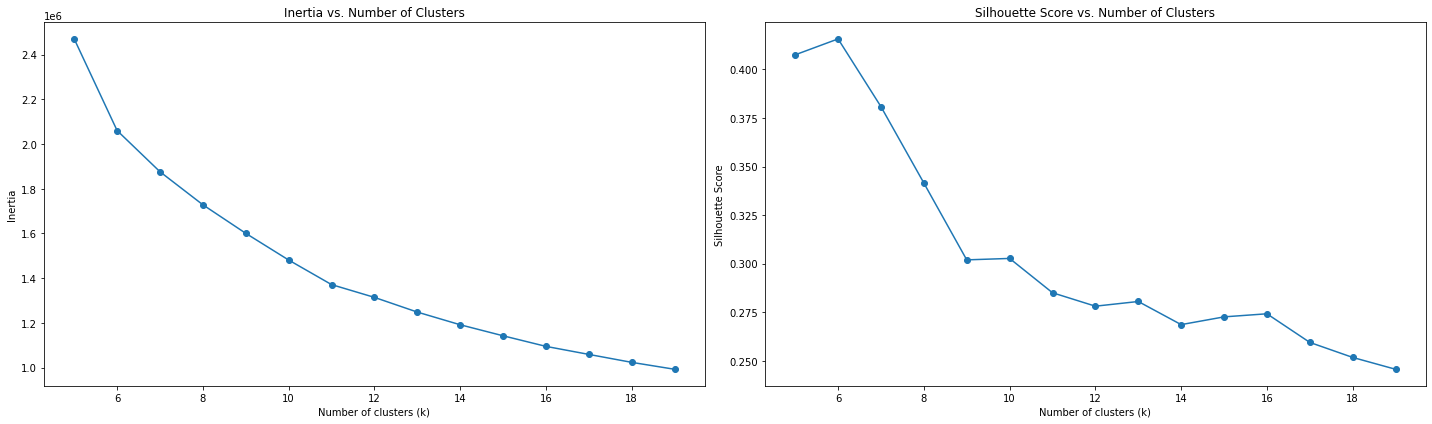

In [125]:
KmeansMethod(IPCA_randomSample6,5,20)

In [285]:
featuresY2_2 = ['order_dow',
            'days_since_prior_order',
            'reordered',
            'order_hour_of_day_y',
            'mean_add_to_cart_order']

In [142]:
sample50000_clustering5 = sample50000.copy()

**set 5 and 6 to optimal k values**

In [129]:
kmeans5 = KMeans(n_clusters=5, random_state=42)
# Fit K-means to your data
kmeans5.fit(sample50000[featuresY2])
# Get the cluster labels for each data point
cluster_labels5 = kmeans5.labels_
# Add the 'cluster' column to your DataFrame and assign the cluster labels
sample50000['cluster'] = cluster_labels5
# Print the updated DataFrame with the 'cluster' column
sample50000

,order_number,order_dow,order_hour_of_day_x,days_since_prior_order,product_id_x,add_to_cart_order,reordered,department_id_x,order_hour_of_day_y,product_id_y,department_id_y,mean_add_to_cart_order,cluster
365343,-0.471814,-1.300636,3,0.204217,0.440436,0.105694,0,13,3,3,1,7.571429,1
1116316,0.500706,0.129744,6,-0.338459,0.309466,0.474256,1,4,4,2,1,8.645833,1
760834,-0.383403,0.606538,6,-0.664065,-0.738295,-0.078587,0,3,6,24,3,9.500000,3
1163542,-1.090690,0.606538,5,-0.555530,-0.685907,2.869910,0,19,5,5,1,13.000000,1
1216219,-0.294992,0.606538,4,-0.229924,-1.235981,2.685629,0,4,4,16,1,10.616667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
929858,-0.560225,-1.300636,3,0.529822,0.571406,0.289975,0,3,3,2,3,6.000000,1
1302803,-1.090690,0.129744,5,-0.555530,0.938122,-1.184274,0,19,5,6,1,16.000000,1
207983,-1.002279,1.560125,5,1.940780,-0.921653,-0.999993,0,16,5,16,4,8.000000,0
980297,0.942761,1.560125,4,-0.446994,1.173868,1.211380,1,1,3,2,1,16.153846,1


In [131]:
sample50000['cluster'].unique()

array([1, 3, 0, 4, 2])

In [132]:
sample50000_cluster0 = sample50000[sample50000['cluster'] == 0]
sample50000_cluster1 = sample50000[sample50000['cluster'] == 1]
sample50000_cluster2 = sample50000[sample50000['cluster'] == 2]
sample50000_cluster3 = sample50000[sample50000['cluster'] == 3]
sample50000_cluster4 = sample50000[sample50000['cluster'] == 4]

###  Try after Encodig the data

In [85]:
dataset_encoder = pd.get_dummies(sample50000, columns = ['product_id_x' ,'department_id_x' ])

In [86]:
dataset_encoder

,order_id,user_id,order_number,order_dow,order_hour_of_day_x,days_since_prior_order,add_to_cart_order,reordered,order_hour_of_day_y,product_id_y,department_id_y,mean_add_to_cart_order,product_id_x_-1.8384438340599185,product_id_x_-1.8122498172343406,product_id_x_-1.7860558004087626,product_id_x_-1.7598617835831847,product_id_x_-1.7336677667576066,product_id_x_-1.7074737499320287,product_id_x_-1.6812797331064506,product_id_x_-1.6550857162808728,product_id_x_-1.6288916994552949,product_id_x_-1.6026976826297168,product_id_x_-1.576503665804139,product_id_x_-1.5503096489785608,product_id_x_-1.524115632152983,product_id_x_-1.4979216153274049,product_id_x_-1.471727598501827,product_id_x_-1.4455335816762491,product_id_x_-1.419339564850671,product_id_x_-1.3931455480250932,product_id_x_-1.366951531199515,product_id_x_-1.3407575143739372,product_id_x_-1.314563497548359,product_id_x_-1.2883694807227812,product_id_x_-1.2621754638972034,product_id_x_-1.2359814470716253,product_id_x_-1.2097874302460474,product_id_x_-1.1835934134204693,product_id_x_-1.1573993965948914,product_id_x_-1.1312053797693133,product_id_x_-1.1050113629437355,product_id_x_-1.0788173461181574,product_id_x_-1.0526233292925795,product_id_x_-1.0264293124670016,product_id_x_-1.0002352956414235,product_id_x_-0.9740412788158457,product_id_x_-0.9478472619902677,product_id_x_-0.9216532451646897,product_id_x_-0.8954592283391117,product_id_x_-0.8692652115135338,product_id_x_-0.8430711946879558,product_id_x_-0.8168771778623778,product_id_x_-0.7906831610367998,product_id_x_-0.7644891442112219,product_id_x_-0.738295127385644,product_id_x_-0.712101110560066,product_id_x_-0.685907093734488,product_id_x_-0.65971307690891,product_id_x_-0.633519060083332,product_id_x_-0.607325043257754,product_id_x_-0.5811310264321762,product_id_x_-0.5549370096065982,product_id_x_-0.5287429927810202,product_id_x_-0.5025489759554422,product_id_x_-0.47635495912986425,product_id_x_-0.45016094230428627,product_id_x_-0.42396692547870835,product_id_x_-0.39777290865313036,product_id_x_-0.3715788918275524,product_id_x_-0.34538487500197446,product_id_x_-0.3191908581763965,product_id_x_-0.2929968413508185,product_id_x_-0.2668028245252405,product_id_x_-0.24060880769966256,product_id_x_-0.2144147908740846,product_id_x_-0.18822077404850662,product_id_x_-0.16202675722292867,product_id_x_-0.1358327403973507,product_id_x_-0.10963872357177273,product_id_x_-0.08344470674619477,product_id_x_-0.0572506899206168,product_id_x_-0.031056673095038834,product_id_x_-0.004862656269460868,product_id_x_0.021331360556117097,product_id_x_0.047525377381695065,product_id_x_0.07371939420727303,product_id_x_0.099913411032851,product_id_x_0.12610742785842896,product_id_x_0.15230144468400694,product_id_x_0.1784954615095849,product_id_x_0.20468947833516285,product_id_x_0.23088349516074083,product_id_x_0.2570775119863188,product_id_x_0.28327152881189677,product_id_x_0.30946554563747475,product_id_x_0.3356595624630527,product_id_x_0.36185357928863066,product_id_x_0.38804759611420864,product_id_x_0.4142416129397866,product_id_x_0.44043562976536454,product_id_x_0.4666296465909425,product_id_x_0.4928236634165205,product_id_x_0.5190176802420985,product_id_x_0.5452116970676765,product_id_x_0.5714057138932543,product_id_x_0.5975997307188323,product_id_x_0.6237937475444103,product_id_x_0.6499877643699883,product_id_x_0.6761817811955663,product_id_x_0.7023757980211442,product_id_x_0.7285698148467222,product_id_x_0.7547638316723002,product_id_x_0.7809578484978781,product_id_x_0.8071518653234561,product_id_x_0.833345882149034,product_id_x_0.859539898974612,product_id_x_0.88573391580019,product_id_x_0.911927932625768,product_id_x_0.938121949451346,product_id_x_0.9643159662769238,product_id_x_0.9905099831025018,product_id_x_1.0167039999280798,product_id_x_1.042898016753658,product_id_x_1.0690920335792358,product_id_x_1.0952860504048136,product_id_x_1.1214800672303917,product_id_x_1.1476740840559696,product_id_x_1.1738681008815477,product_id_x_1.20006211770

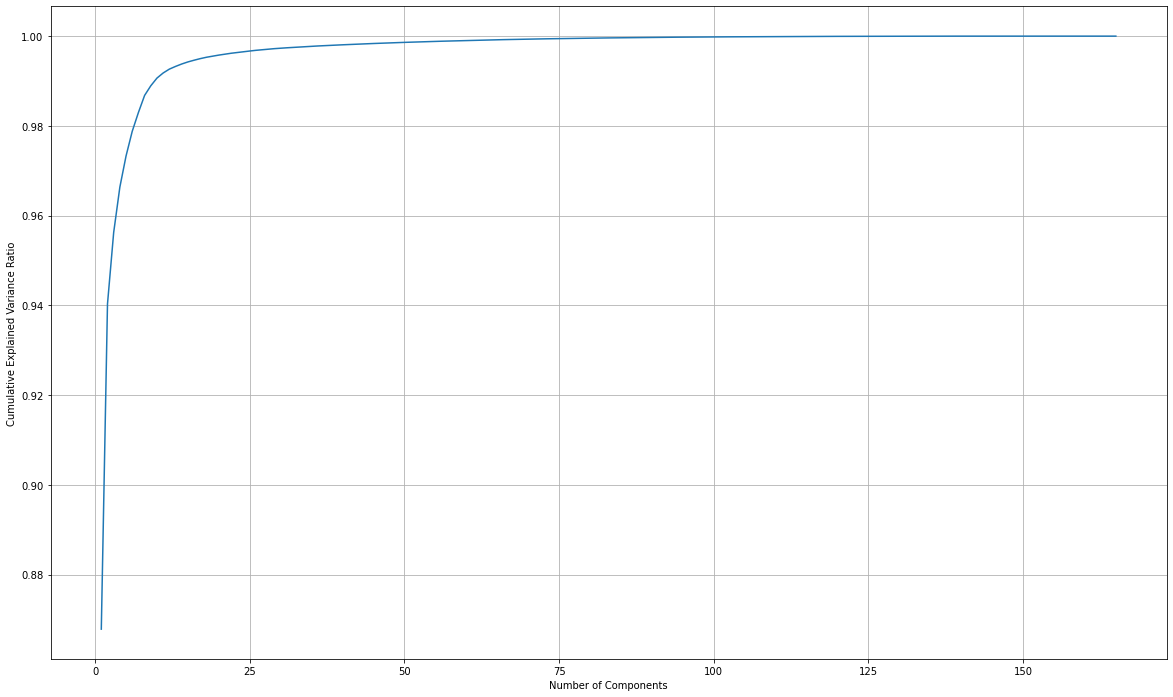

In [89]:
# But now it's necessary to apply PCA
X = dataset_encoder.drop(['order_id', 'user_id'], axis =1 )
pca = PCA()
pca.fit(X)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(20, 12))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [92]:
n_components = 80
pca = PCA(n_components=n_components)
X_pca80 = pca.fit_transform(X)

Silhouette scores (sorted in descending order):
Silhouette score for k=5: 0.3773167707827875
Silhouette score for k=7: 0.28680882929765206
Silhouette score for k=6: 0.2865218091010067
Silhouette score for k=9: 0.2703826829599226
Silhouette score for k=8: 0.2641005618115741
Silhouette score for k=11: 0.242004644699393
Silhouette score for k=10: 0.24064497362235776
Silhouette score for k=12: 0.2271315350920884
Silhouette score for k=13: 0.22143943156994614
Silhouette score for k=14: 0.19688349735339802
Silhouette score for k=15: 0.19551033572392454
Silhouette score for k=18: 0.17779959046241417
Silhouette score for k=16: 0.17674074673375567
Silhouette score for k=17: 0.16903182129701738
Silhouette score for k=19: 0.1601679829124062
Silhouette score for k=20: 0.15783892969579438
Silhouette score for k=22: 0.15400417735205071
Silhouette score for k=21: 0.15247162030009406
Silhouette score for k=25: 0.14738894626629465
Silhouette score for k=23: 0.14504621008992621
Silhouette score for k=24

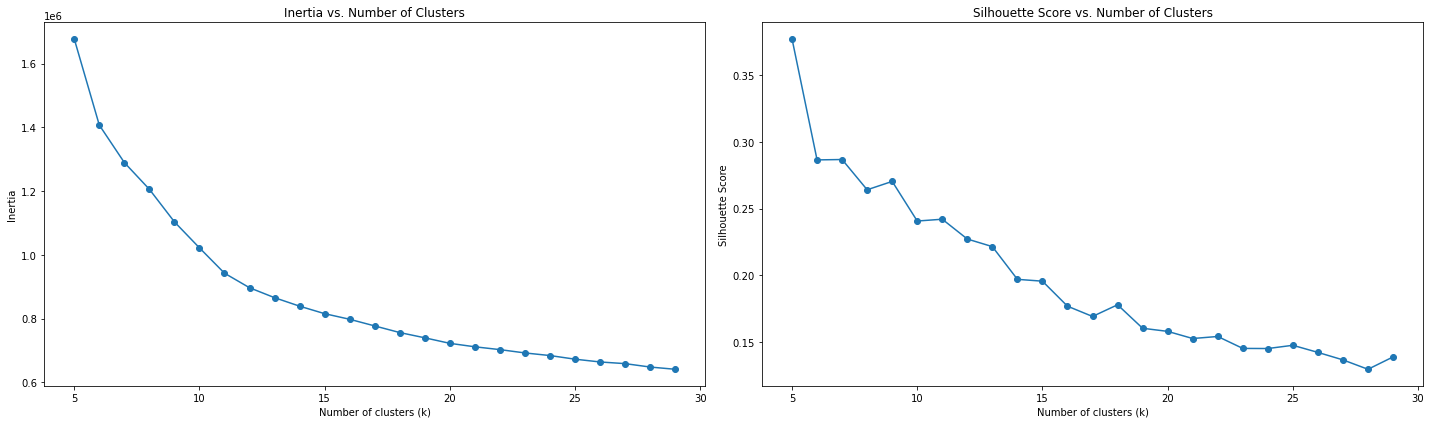

In [93]:
KmeansMethod(X_pca80,5,30)

Silhouette scores (sorted in descending order):
Silhouette score for k=3: 0.5181229670241162
Silhouette score for k=4: 0.3834739464242931
Silhouette score for k=5: 0.3773167707827875
Silhouette score for k=7: 0.28680882929765206
Silhouette score for k=6: 0.2865218091010067
Silhouette score for k=9: 0.2703826829599226
Silhouette score for k=8: 0.2641005618115741


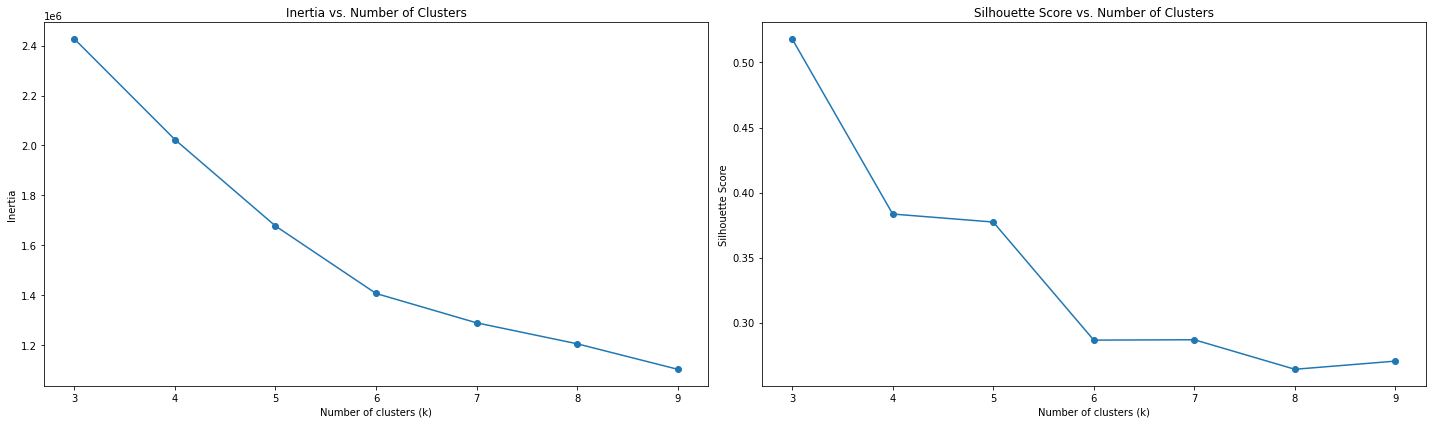

In [94]:
KmeansMethod(X_pca80,3,10)

In [97]:
sample50000_encode3 = dataset_encoder.copy()

In [98]:
kmeans3 = KMeans(n_clusters=3, random_state=42)
# Fit K-means to your data
kmeans3.fit(X_pca80)
# Get the cluster labels for each data point
cluster_labels3 = kmeans3.labels_
# Add the 'cluster' column to your DataFrame and assign the cluster labels
sample50000_encode3['cluster'] = cluster_labels3
# Print the updated DataFrame with the 'cluster' column
sample50000_encode3

,order_id,user_id,order_number,order_dow,order_hour_of_day_x,days_since_prior_order,add_to_cart_order,reordered,order_hour_of_day_y,product_id_y,department_id_y,mean_add_to_cart_order,product_id_x_-1.8384438340599185,product_id_x_-1.8122498172343406,product_id_x_-1.7860558004087626,product_id_x_-1.7598617835831847,product_id_x_-1.7336677667576066,product_id_x_-1.7074737499320287,product_id_x_-1.6812797331064506,product_id_x_-1.6550857162808728,product_id_x_-1.6288916994552949,product_id_x_-1.6026976826297168,product_id_x_-1.576503665804139,product_id_x_-1.5503096489785608,product_id_x_-1.524115632152983,product_id_x_-1.4979216153274049,product_id_x_-1.471727598501827,product_id_x_-1.4455335816762491,product_id_x_-1.419339564850671,product_id_x_-1.3931455480250932,product_id_x_-1.366951531199515,product_id_x_-1.3407575143739372,product_id_x_-1.314563497548359,product_id_x_-1.2883694807227812,product_id_x_-1.2621754638972034,product_id_x_-1.2359814470716253,product_id_x_-1.2097874302460474,product_id_x_-1.1835934134204693,product_id_x_-1.1573993965948914,product_id_x_-1.1312053797693133,product_id_x_-1.1050113629437355,product_id_x_-1.0788173461181574,product_id_x_-1.0526233292925795,product_id_x_-1.0264293124670016,product_id_x_-1.0002352956414235,product_id_x_-0.9740412788158457,product_id_x_-0.9478472619902677,product_id_x_-0.9216532451646897,product_id_x_-0.8954592283391117,product_id_x_-0.8692652115135338,product_id_x_-0.8430711946879558,product_id_x_-0.8168771778623778,product_id_x_-0.7906831610367998,product_id_x_-0.7644891442112219,product_id_x_-0.738295127385644,product_id_x_-0.712101110560066,product_id_x_-0.685907093734488,product_id_x_-0.65971307690891,product_id_x_-0.633519060083332,product_id_x_-0.607325043257754,product_id_x_-0.5811310264321762,product_id_x_-0.5549370096065982,product_id_x_-0.5287429927810202,product_id_x_-0.5025489759554422,product_id_x_-0.47635495912986425,product_id_x_-0.45016094230428627,product_id_x_-0.42396692547870835,product_id_x_-0.39777290865313036,product_id_x_-0.3715788918275524,product_id_x_-0.34538487500197446,product_id_x_-0.3191908581763965,product_id_x_-0.2929968413508185,product_id_x_-0.2668028245252405,product_id_x_-0.24060880769966256,product_id_x_-0.2144147908740846,product_id_x_-0.18822077404850662,product_id_x_-0.16202675722292867,product_id_x_-0.1358327403973507,product_id_x_-0.10963872357177273,product_id_x_-0.08344470674619477,product_id_x_-0.0572506899206168,product_id_x_-0.031056673095038834,product_id_x_-0.004862656269460868,product_id_x_0.021331360556117097,product_id_x_0.047525377381695065,product_id_x_0.07371939420727303,product_id_x_0.099913411032851,product_id_x_0.12610742785842896,product_id_x_0.15230144468400694,product_id_x_0.1784954615095849,product_id_x_0.20468947833516285,product_id_x_0.23088349516074083,product_id_x_0.2570775119863188,product_id_x_0.28327152881189677,product_id_x_0.30946554563747475,product_id_x_0.3356595624630527,product_id_x_0.36185357928863066,product_id_x_0.38804759611420864,product_id_x_0.4142416129397866,product_id_x_0.44043562976536454,product_id_x_0.4666296465909425,product_id_x_0.4928236634165205,product_id_x_0.5190176802420985,product_id_x_0.5452116970676765,product_id_x_0.5714057138932543,product_id_x_0.5975997307188323,product_id_x_0.6237937475444103,product_id_x_0.6499877643699883,product_id_x_0.6761817811955663,product_id_x_0.7023757980211442,product_id_x_0.7285698148467222,product_id_x_0.7547638316723002,product_id_x_0.7809578484978781,product_id_x_0.8071518653234561,product_id_x_0.833345882149034,product_id_x_0.859539898974612,product_id_x_0.88573391580019,product_id_x_0.911927932625768,product_id_x_0.938121949451346,product_id_x_0.9643159662769238,product_id_x_0.9905099831025018,product_id_x_1.0167039999280798,product_id_x_1.042898016753658,product_id_x_1.0690920335792358,product_id_x_1.0952860504048136,product_id_x_1.1214800672303917,product_id_x_1.1476740840559696,product_id_x_1.1738681008815477,product_id_x_1.20006211770

In [99]:
sample50000_encode3['cluster'].unique()

array([0, 1, 2])

In [100]:
sample50000_encode0  = sample50000_encode3[sample50000_encode3['cluster'] == 0]
sample50000_encode1 = sample50000_encode3[sample50000_encode3['cluster'] == 1]
sample50000_encode2 = sample50000_encode3[sample50000_encode3['cluster'] == 2]

# 

<a name="1.6.3"></a>
### 2. Agglomerative Clustering

In [145]:
sample50000

,order_number,order_dow,order_hour_of_day_x,days_since_prior_order,product_id_x,add_to_cart_order,reordered,department_id_x,order_hour_of_day_y,product_id_y,department_id_y,mean_add_to_cart_order
365343,-0.471814,-1.300636,3,0.204217,0.440436,0.105694,0,13,3,3,1,7.571429
1116316,0.500706,0.129744,6,-0.338459,0.309466,0.474256,1,4,4,2,1,8.645833
760834,-0.383403,0.606538,6,-0.664065,-0.738295,-0.078587,0,3,6,24,3,9.500000
1163542,-1.090690,0.606538,5,-0.555530,-0.685907,2.869910,0,19,5,5,1,13.000000
1216219,-0.294992,0.606538,4,-0.229924,-1.235981,2.685629,0,4,4,16,1,10.616667
...,...,...,...,...,...,...,...,...,...,...,...,...
929858,-0.560225,-1.300636,3,0.529822,0.571406,0.289975,0,3,3,2,3,6.000000
1302803,-1.090690,0.129744,5,-0.555530,0.938122,-1.184274,0,19,5,6,1,16.000000
207983,-1.002279,1.560125,5,1.940780,-0.921653,-0.999993,0,16,5,16,4,8.000000
980297,0.942761,1.560125,4,-0.446994,1.173868,1.211380,1,1,3,2,1,16.153846


In [ ]:
Silhouette Score: 0.24575102027495904

Silhouette Score: 0.291441478992455


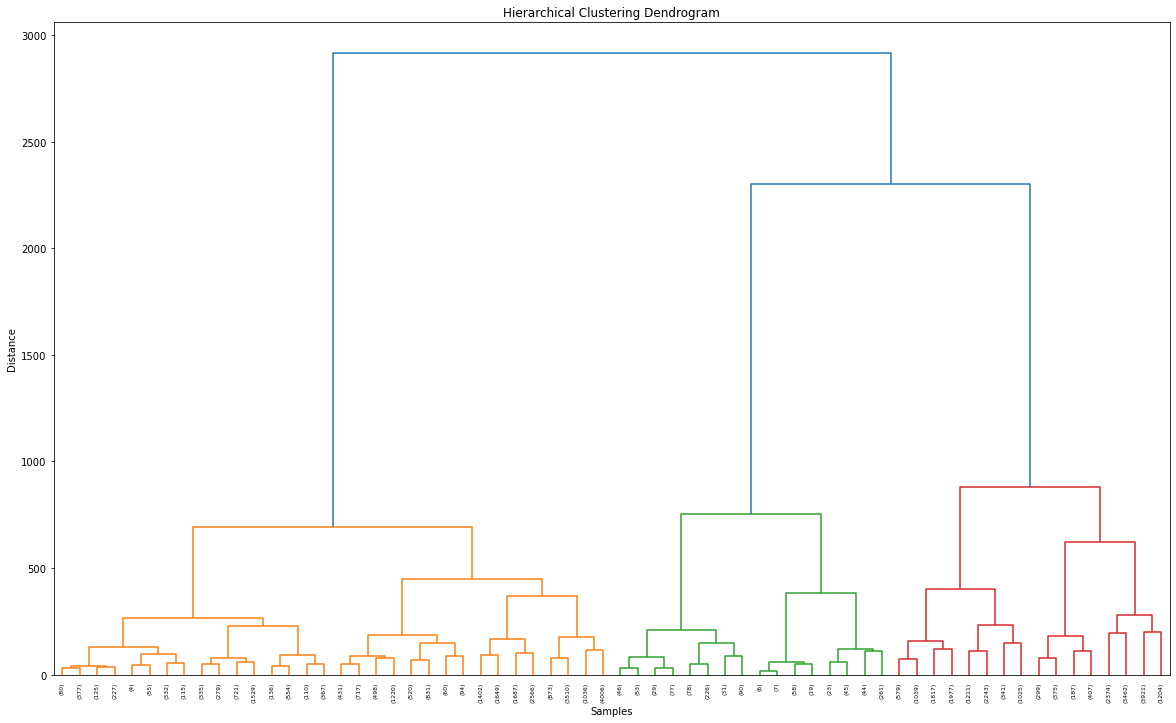

In [150]:
AgglomerativeClusteringMethod(sample50000[featuresY2],10)

Silhouette Score: 0.300256343626183


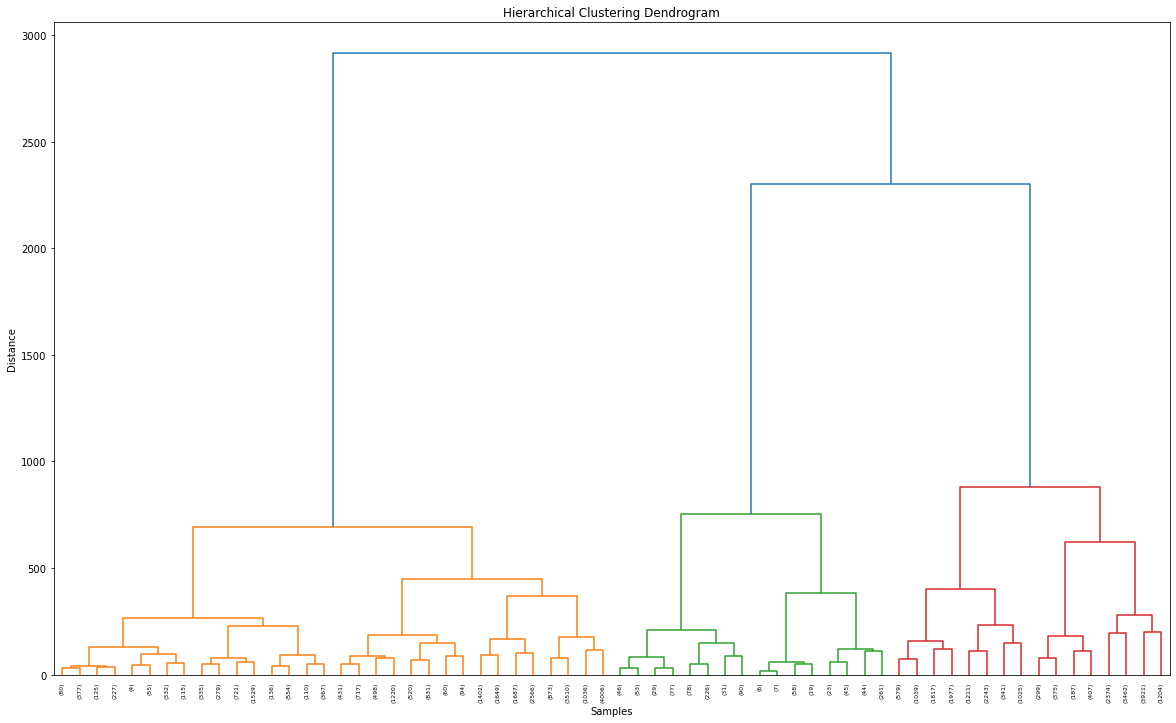

In [151]:
AgglomerativeClusteringMethod(sample50000[featuresY2],8)

Silhouette Score: 0.32718896483966653


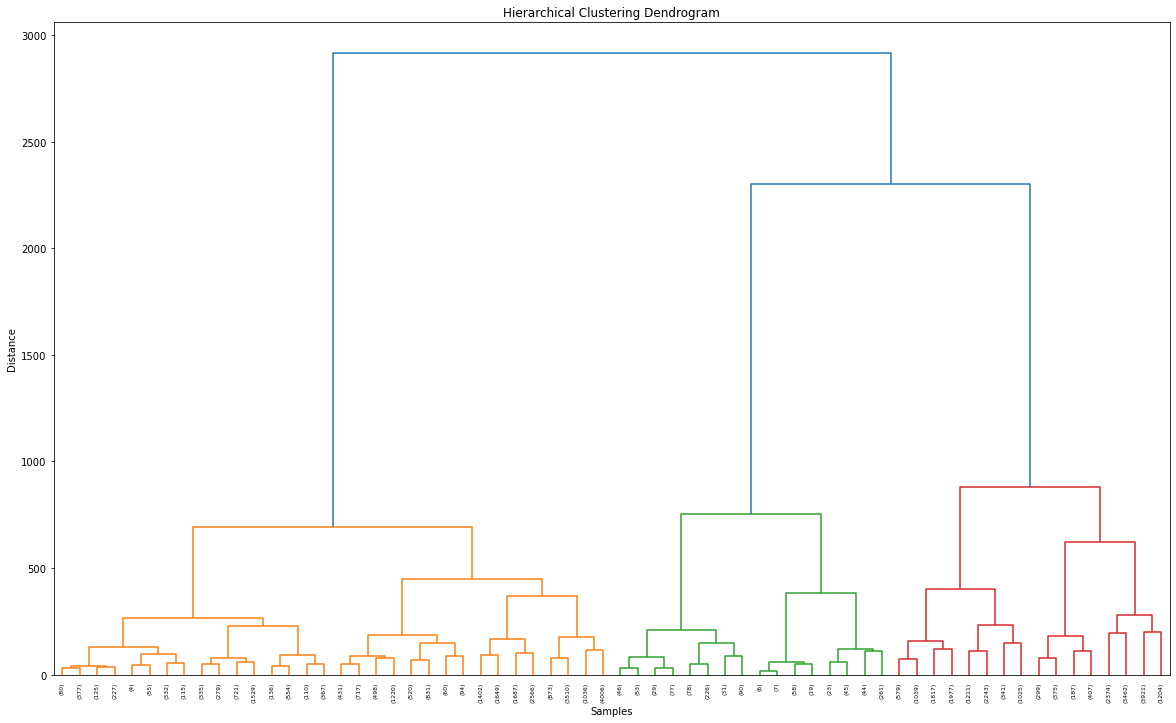

In [152]:
AgglomerativeClusteringMethod(sample50000[featuresY2],6)

### One hot

Silhouette Score: 0.24105457854843254


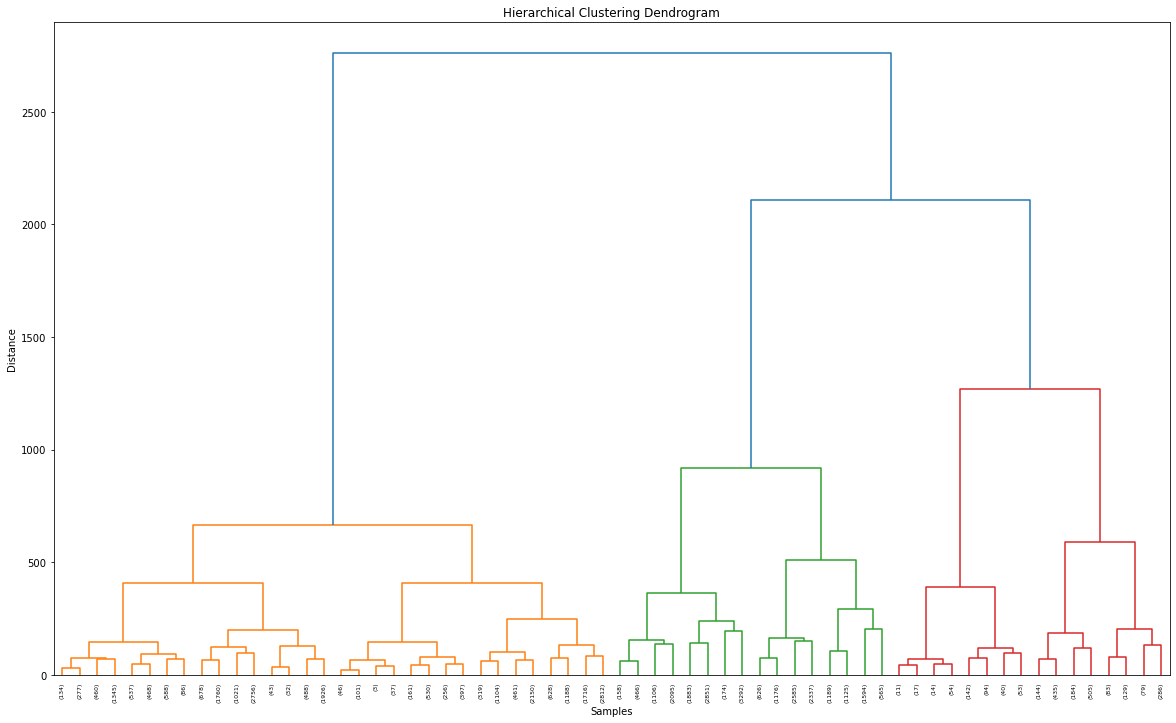

In [101]:
AgglomerativeClusteringMethod(X_pca80,6)

<a name="1.6.4"></a>
### 3. Divisive Clustering

Not getting better result!

<a name="1.7"></a>
## Clusters information

### 2.Encoding datset

In [122]:
def comparePlots(feature,dataset):
    print("\n")
    print("\n")
    fig, ax = plt.subplots(2, 1, figsize=(20, 12))
    pyplot.hist(data0[feature], alpha=0.5, label='Zero')
    pyplot.hist(data1[feature], alpha=0.5, label='One')
    pyplot.hist(data2[feature], alpha=0.5, label='Two')
    pyplot.legend(loc='upper right')
    sns.boxplot(x=dataset['cluster'], y=feature, data=dataset,ax=ax[0]).set_title(str(feature),fontsize = 20)
    pyplot.show()
    print("\n")
    print("\n")


In [107]:
indexes0 = sample50000_encode0.index.tolist()
indexes1 = sample50000_encode1.index.tolist()
indexes2 = sample50000_encode2.index.tolist()

In [108]:
#Using the indexes and find them in firs dataset(no scaling and real values)
data0 = [dataset_null.loc[i] for i in indexes0]
data1 = [dataset_null.loc[i] for i in indexes1]
data2 = [dataset_null.loc[i] for i in indexes2]
# Convert them to dataframe
data0 = pd.DataFrame(data0)
data1 = pd.DataFrame(data1)
data2 = pd.DataFrame(data2)
#Adding labels 
data0['cluster'] = 0
data1['cluster'] = 1
data2['cluster'] = 2

In [111]:
dataCluster_encode = pd.concat([data0, data1, data2], ignore_index=True)
# Display the merged DataFrame
dataCluster_encode

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name,cluster
0,3156984,48318,6,6,22,4.0,24,6,0,4,produce,fresh fruits,0
1,2182099,52983,13,0,16,30.0,83,8,1,4,produce,fresh vegetables,0
2,1249859,51084,5,5,10,10.0,21,7,0,16,dairy eggs,packaged cheese,0
3,511818,47330,15,6,17,30.0,24,3,1,4,produce,fresh fruits,0
4,3230234,146381,29,3,16,6.0,91,15,1,16,dairy eggs,soy lactosefree,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,25948,153299,11,2,15,28.0,84,1,1,16,dairy eggs,milk,2
49996,1748665,29199,18,1,11,3.0,107,2,0,19,snacks,chips pretzels,2
49997,1946721,537,3,3,12,0.0,111,5,0,17,household,plates bowls cups flatware,2
49998,2541827,67686,3,1,6,8.0,106,2,0,12,meat seafood,hot dogs bacon sausage,2


In [124]:
orginal_features = dataCluster_encode.columns.tolist()

In [113]:
orginal_features

['order_id',
 'user_id',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order',
 'product_id',
 'add_to_cart_order',
 'reordered',
 'department_id',
 'department',
 'product_name',
 'cluster']

### Frequency 

In [186]:
def barPlot(dataset,feature,color,y):
    freq = {}
    total_values = len(dataset)

    for element in dataset[feature]:
        freq[element] = freq.get(element, 0) + 1


    sorted_freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    elements = [item[0] for item in sorted_freq]
    frequencies = [item[1] for item in sorted_freq]
    elements = elements[::-1]
    frequencies = frequencies[::-1]
    
    plt.figure(figsize=(20, y))
    plt.barh(elements, frequencies, color=color)

    # Customize the plot
    plt.xlabel('Frequency')
    plt.ylabel('Elements')
    plt.title('Bar Plot with Frequency')
    
        # Sort the elements based on frequency
    sorted_elements = sorted(freq.keys(), key=lambda x: freq[x], reverse=True)

    # Print the top 3 elements, frequencies, and percentages
    for i in range(min(5, len(sorted_elements))):
        element = sorted_elements[i]
        frequency = freq[element]
        percentage = frequency / total_values * 100
        print(f"{element}: Frequency = {frequency}, Percentage = {percentage:.2f}%")
    # Display the plot
    plt.show()
    
    

### Departmen

Cluster 1 : 
produce: Frequency = 7401, Percentage = 27.38%
dairy eggs: Frequency = 4443, Percentage = 16.43%
snacks: Frequency = 2666, Percentage = 9.86%
beverages: Frequency = 2040, Percentage = 7.55%
frozen: Frequency = 1856, Percentage = 6.87%


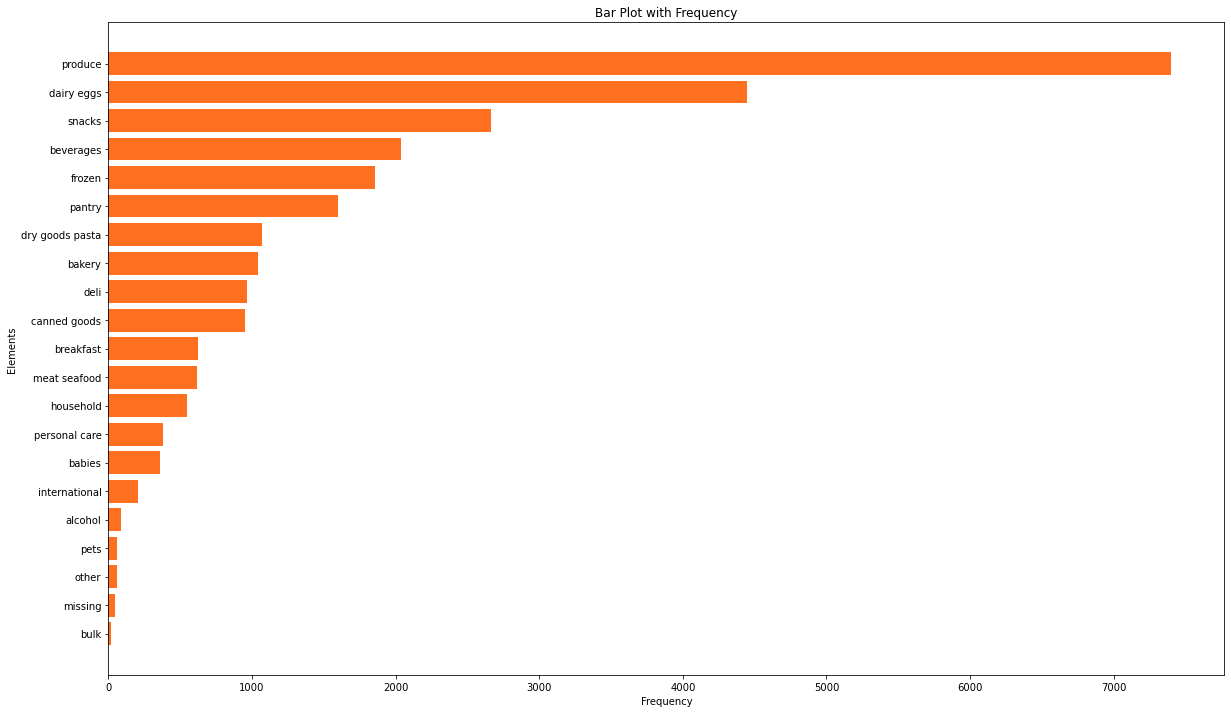

Cluster 2 : 
produce: Frequency = 7401, Percentage = 27.38%
dairy eggs: Frequency = 4443, Percentage = 16.43%
snacks: Frequency = 2666, Percentage = 9.86%
beverages: Frequency = 2040, Percentage = 7.55%
frozen: Frequency = 1856, Percentage = 6.87%


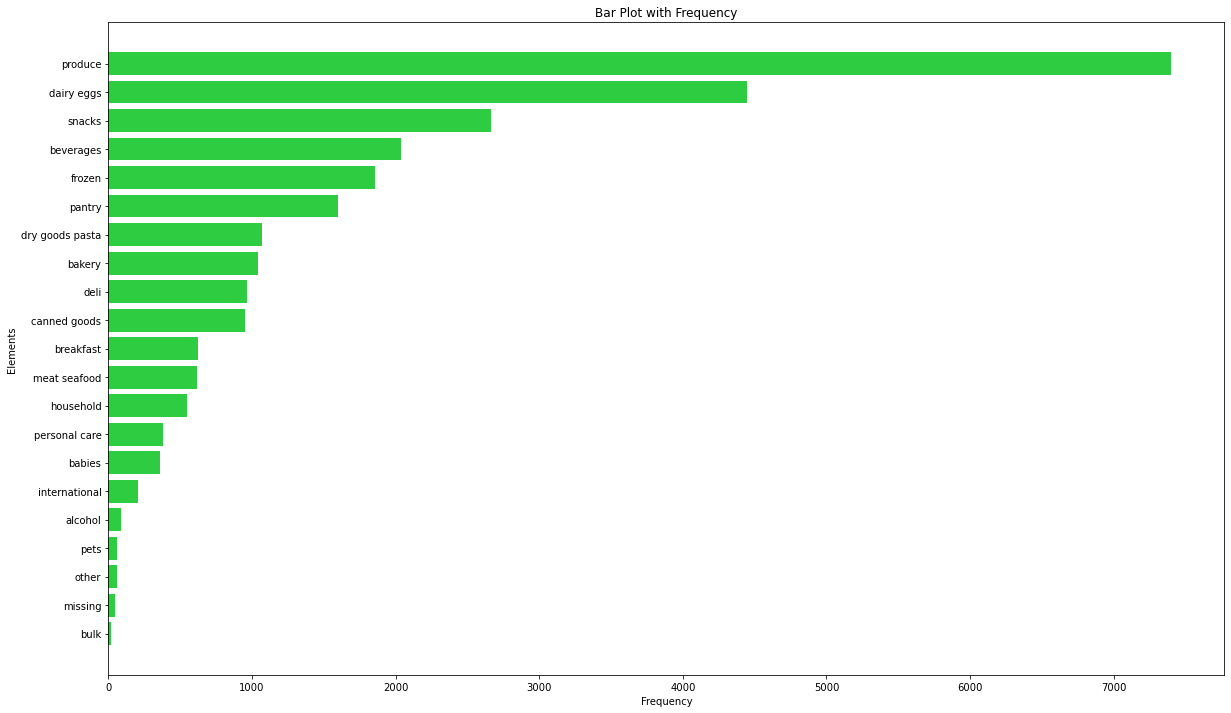

Cluster 3 : 
produce: Frequency = 7401, Percentage = 27.38%
dairy eggs: Frequency = 4443, Percentage = 16.43%
snacks: Frequency = 2666, Percentage = 9.86%
beverages: Frequency = 2040, Percentage = 7.55%
frozen: Frequency = 1856, Percentage = 6.87%


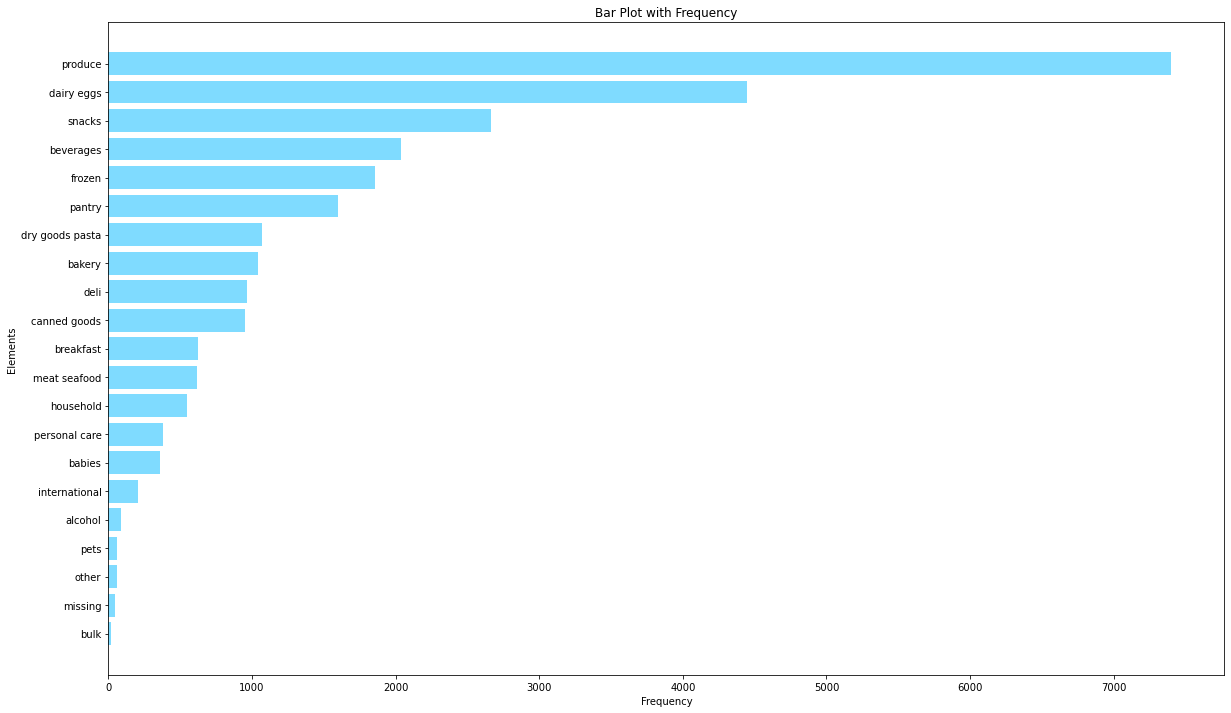

In [170]:
print('Cluster 1 : ')
barPlot(data0,'department',"#FF6F20",12)
print('Cluster 2 : ')
barPlot(data0,'department',"#2ECC40",12)
print('Cluster 3 : ')
barPlot(data0,'department',"#7FDBFF",12)

### Product

Cluster 1 : 
fresh fruits: Frequency = 2901, Percentage = 10.73%
fresh vegetables: Frequency = 2667, Percentage = 9.86%
packaged vegetables fruits: Frequency = 1424, Percentage = 5.27%
yogurt: Frequency = 1256, Percentage = 4.65%
packaged cheese: Frequency = 874, Percentage = 3.23%


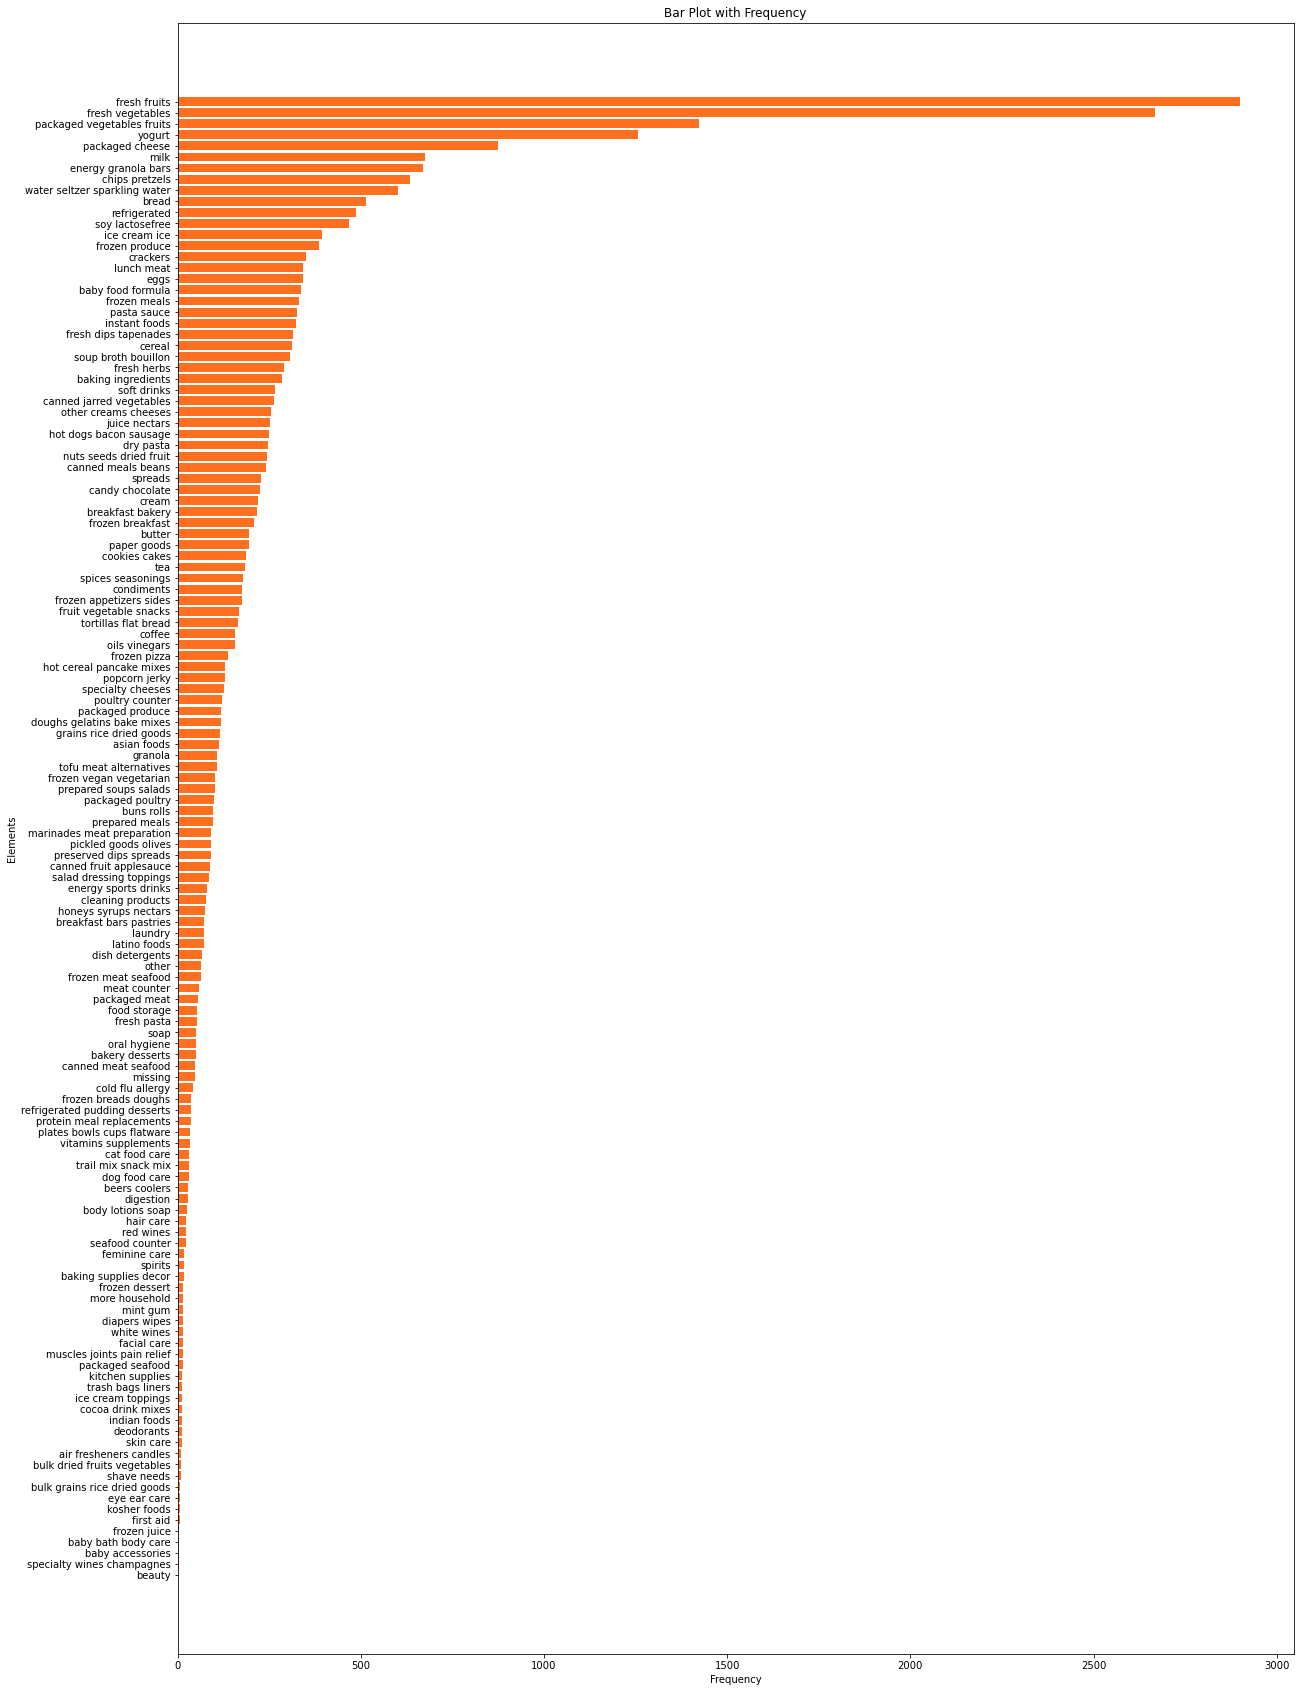

Cluster 2 : 
fresh fruits: Frequency = 2832, Percentage = 12.95%
fresh vegetables: Frequency = 2527, Percentage = 11.56%
packaged vegetables fruits: Frequency = 1228, Percentage = 5.62%
yogurt: Frequency = 962, Percentage = 4.40%
packaged cheese: Frequency = 665, Percentage = 3.04%


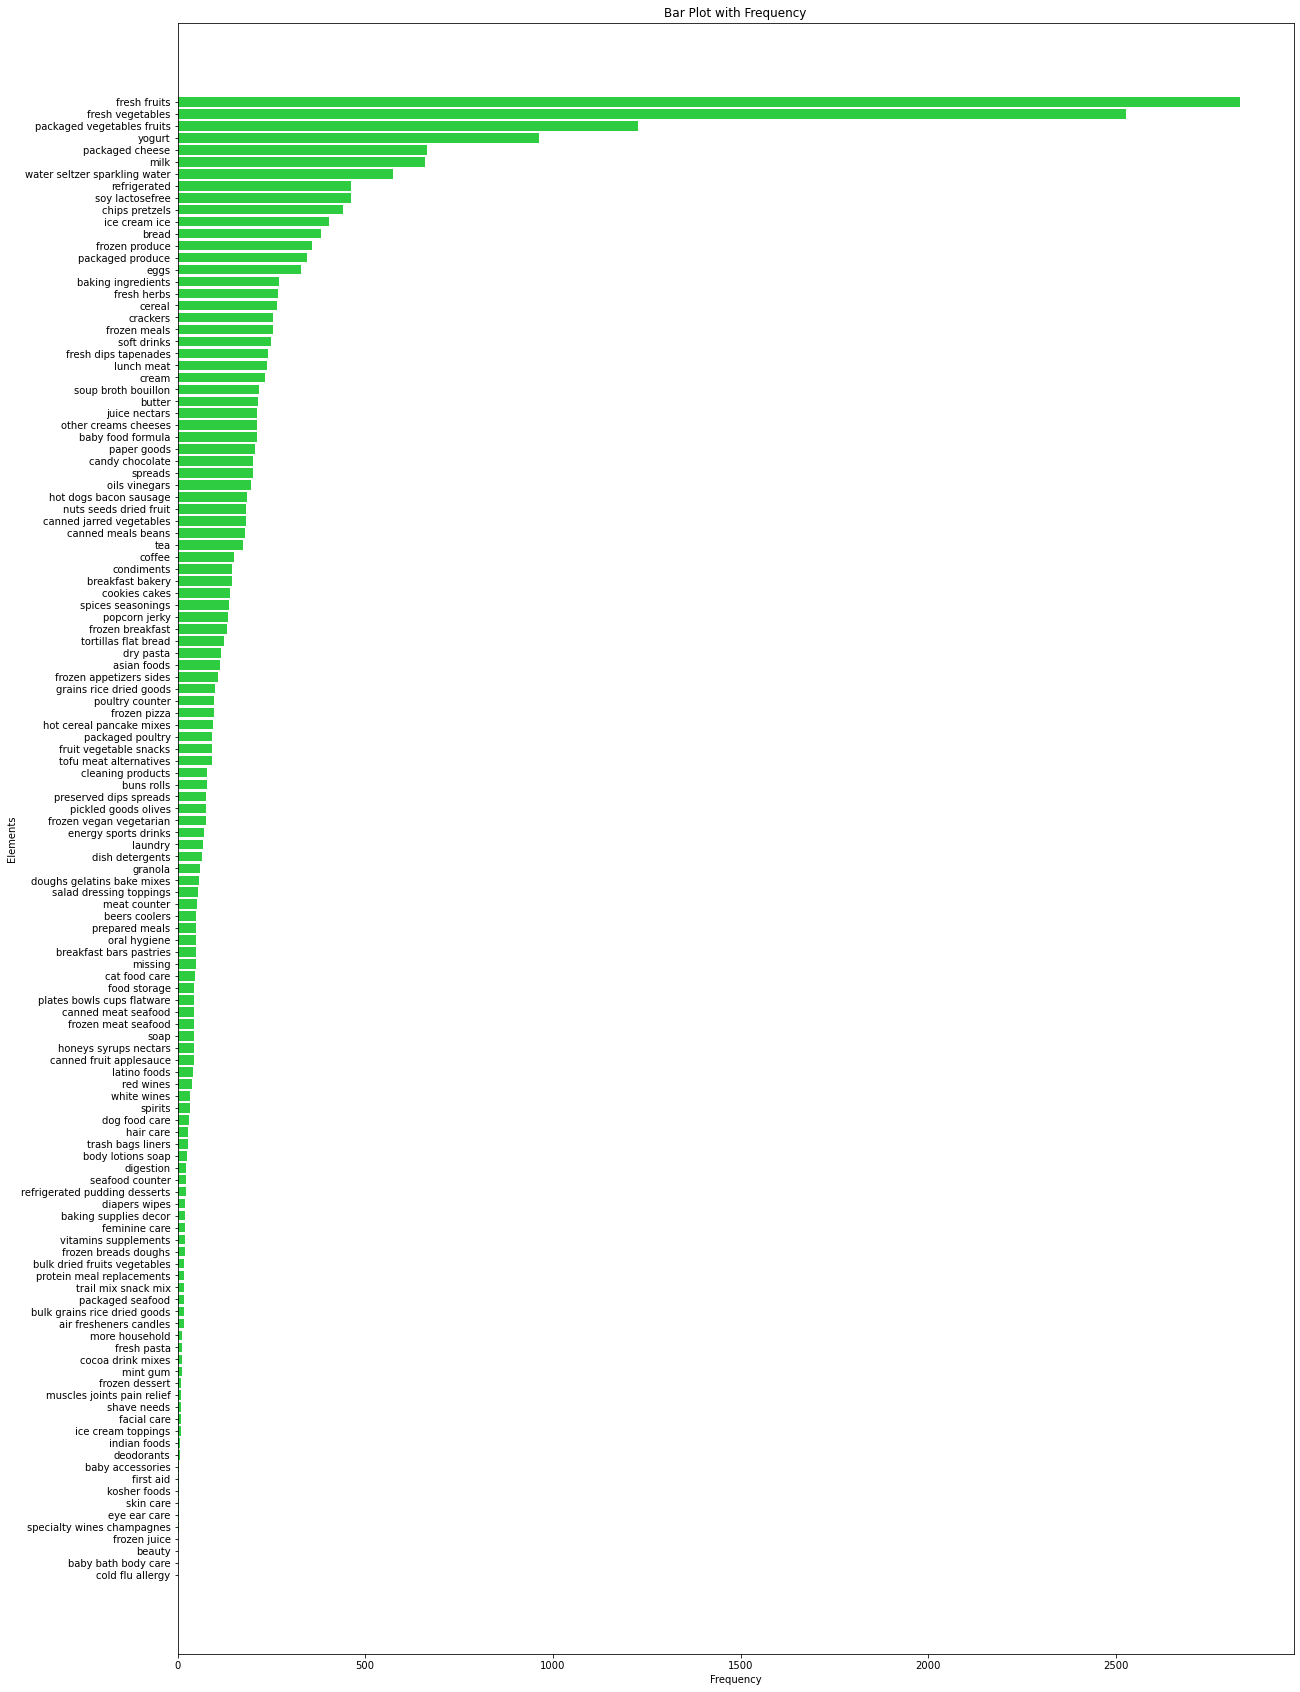

Cluster 3 : 
water seltzer sparkling water: Frequency = 115, Percentage = 10.45%
fresh vegetables: Frequency = 107, Percentage = 9.72%
yogurt: Frequency = 65, Percentage = 5.90%
packaged vegetables fruits: Frequency = 58, Percentage = 5.27%
soft drinks: Frequency = 52, Percentage = 4.72%


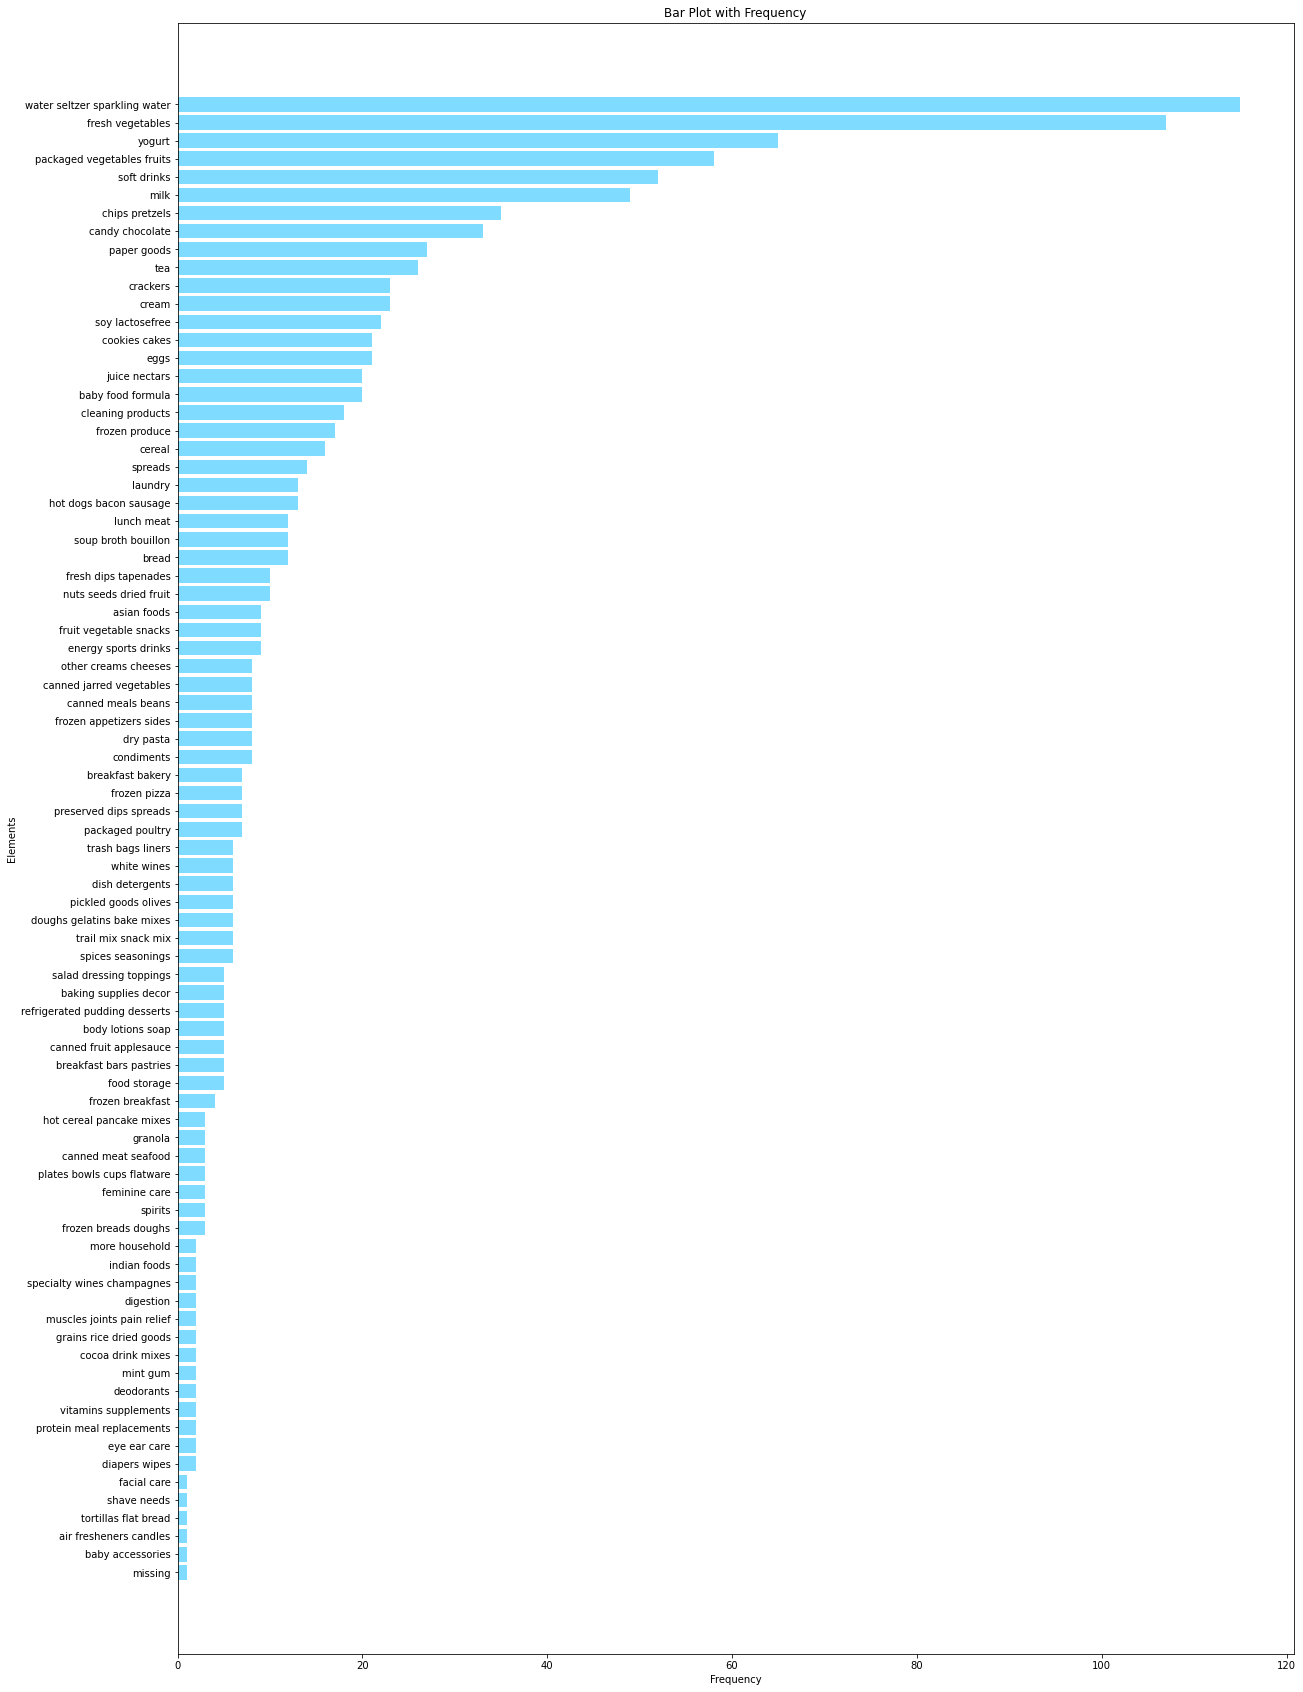

In [173]:
print('Cluster 1 : ')
barPlot(data0,'product_name',"#FF6F20",30)
print('Cluster 2 : ')
barPlot(data1,'product_name',"#2ECC40",30)
print('Cluster 3 : ')
barPlot(data2,'product_name',"#7FDBFF",30)

In [190]:
def barPlot2(dataset, feature, color, y):
    freq = {}
    total_values = len(dataset)

    for element in dataset[feature]:
        freq[element] = freq.get(element, 0) + 1

    sorted_freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    elements = [item[0] for item in sorted_freq]
    frequencies = [item[1] for item in sorted_freq]
    
    plt.figure(figsize=(20, y))
    plt.barh(range(len(elements)), frequencies[::-1], color=color)  # Reverse the frequencies

    # Customize the plot
    plt.xlabel('Frequency')
    plt.ylabel('Elements')
    plt.title('Bar Plot with Frequency')

    # Sort the elements based on frequency
    sorted_elements = sorted(elements, key=lambda x: freq[x], reverse=True)

    # Print the top 5 elements, frequencies, and percentages
    for i in range(min(5, len(sorted_elements))):
        element = sorted_elements[i]
        frequency = freq[element]
        percentage = frequency / total_values * 100
        print(f"{element}: Frequency = {frequency}, Percentage = {percentage:.2f}%")

    # Set y-axis tick labels to the sorted elements
    plt.yticks(range(len(elements)), sorted_elements[::-1])  # Reverse the elements

    # Display the plot
    plt.show()

### Order Day

Cluster 1 : 
0: Frequency = 5594, Percentage = 20.69%
1: Frequency = 4745, Percentage = 17.55%
6: Frequency = 3760, Percentage = 13.91%
2: Frequency = 3369, Percentage = 12.46%
5: Frequency = 3301, Percentage = 12.21%


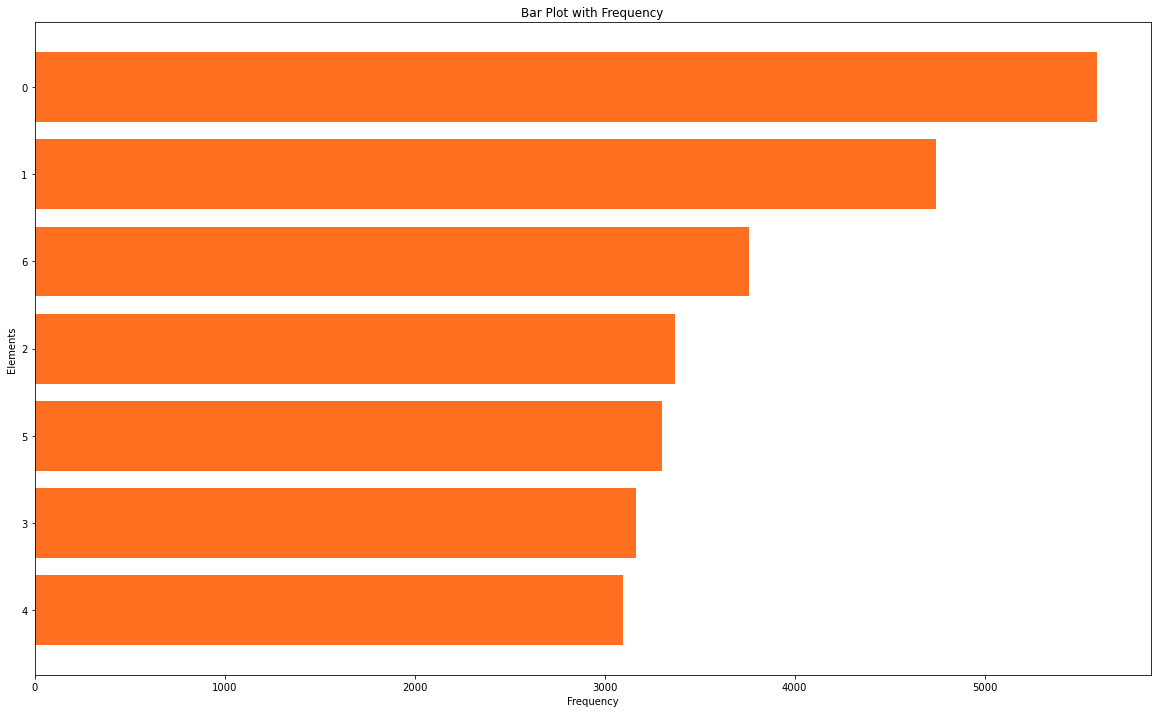

Cluster 2 : 
0: Frequency = 4144, Percentage = 18.95%
1: Frequency = 3729, Percentage = 17.06%
6: Frequency = 3055, Percentage = 13.97%
5: Frequency = 2911, Percentage = 13.31%
2: Frequency = 2898, Percentage = 13.25%


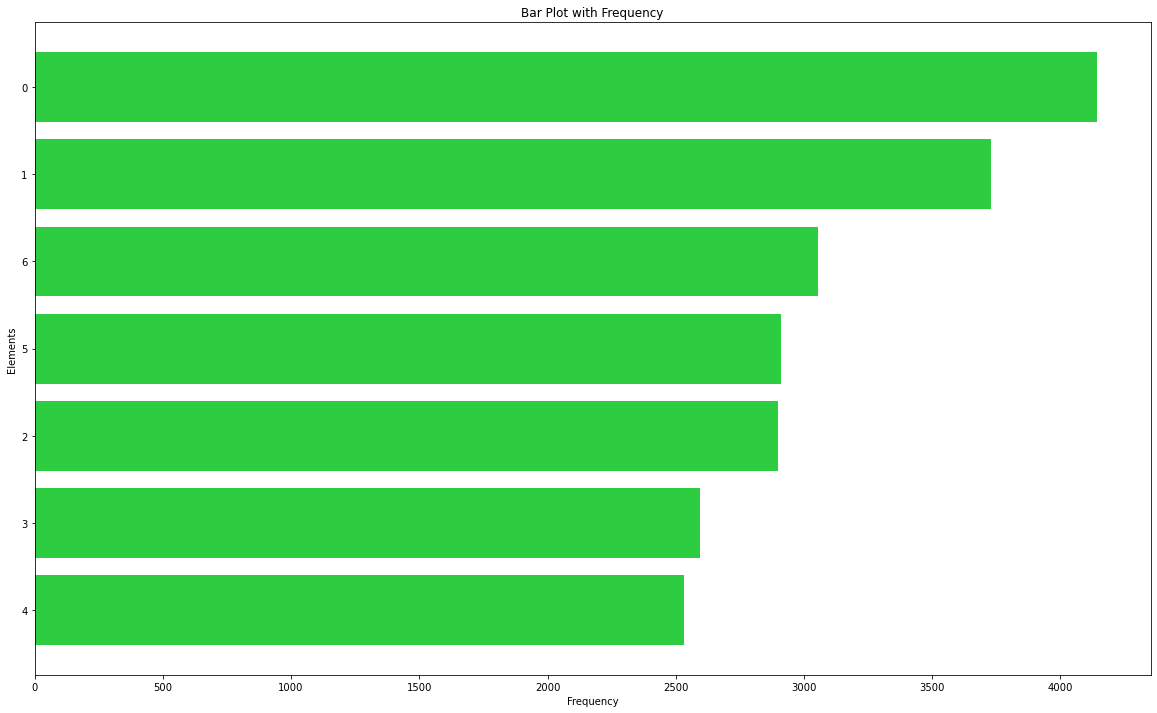

Cluster 3 : 
1: Frequency = 195, Percentage = 17.71%
3: Frequency = 162, Percentage = 14.71%
0: Frequency = 156, Percentage = 14.17%
2: Frequency = 156, Percentage = 14.17%
5: Frequency = 150, Percentage = 13.62%


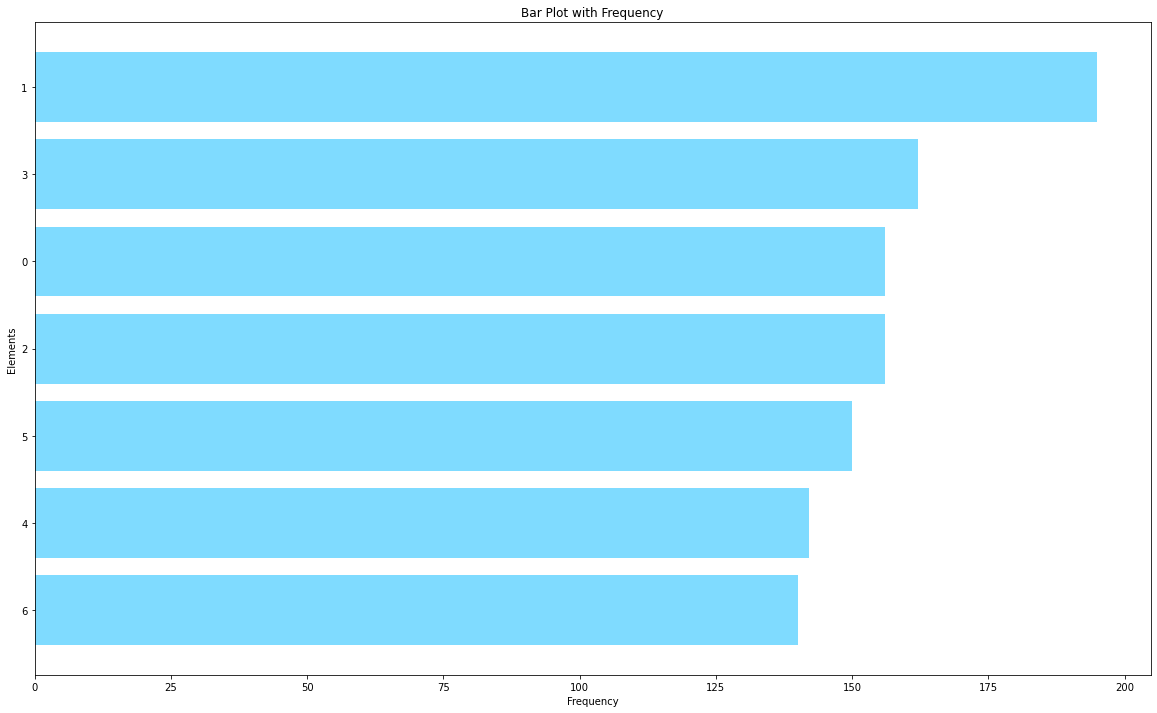

In [191]:
print('Cluster 1 : ')
barPlot2(data0,'order_dow',"#FF6F20",12)
print('Cluster 2 : ')
barPlot2(data1,'order_dow',"#2ECC40",12)
print('Cluster 3 : ')
barPlot2(data2,'order_dow',"#7FDBFF",12)

## Order hour

Cluster 1 : 
14: Frequency = 2374, Percentage = 8.78%
11: Frequency = 2301, Percentage = 8.51%
15: Frequency = 2267, Percentage = 8.39%
10: Frequency = 2236, Percentage = 8.27%
12: Frequency = 2224, Percentage = 8.23%


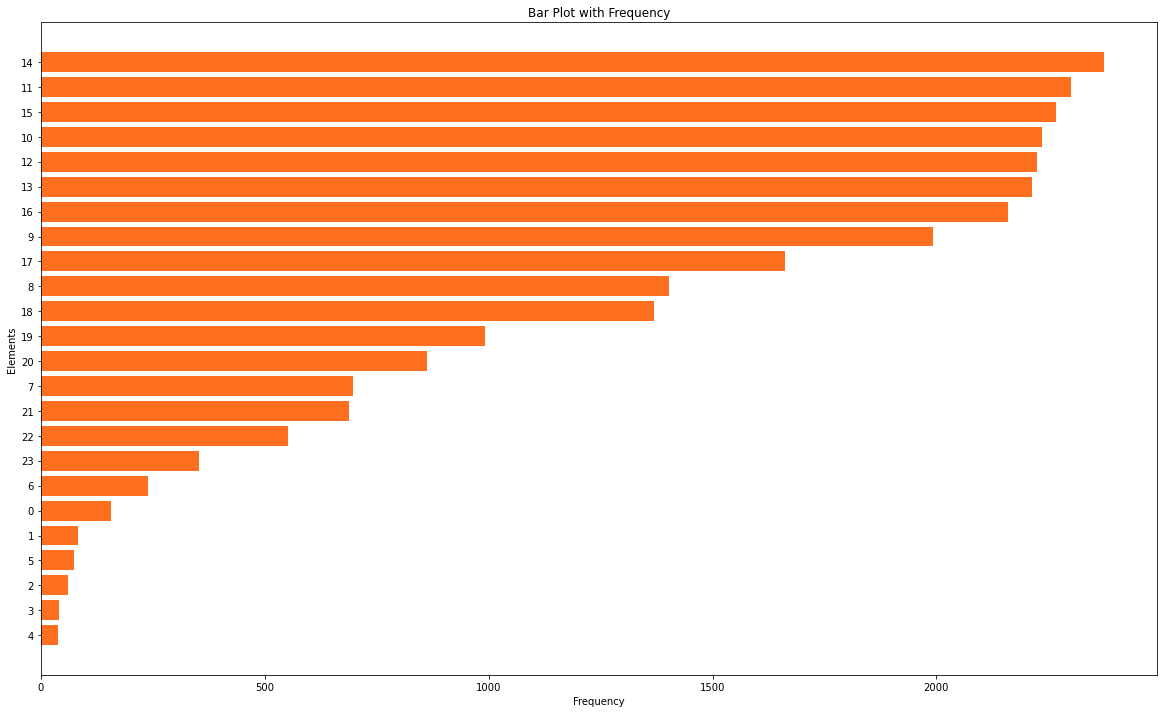

Cluster 2 : 
14: Frequency = 1810, Percentage = 8.28%
11: Frequency = 1806, Percentage = 8.26%
15: Frequency = 1804, Percentage = 8.25%
10: Frequency = 1802, Percentage = 8.24%
13: Frequency = 1797, Percentage = 8.22%


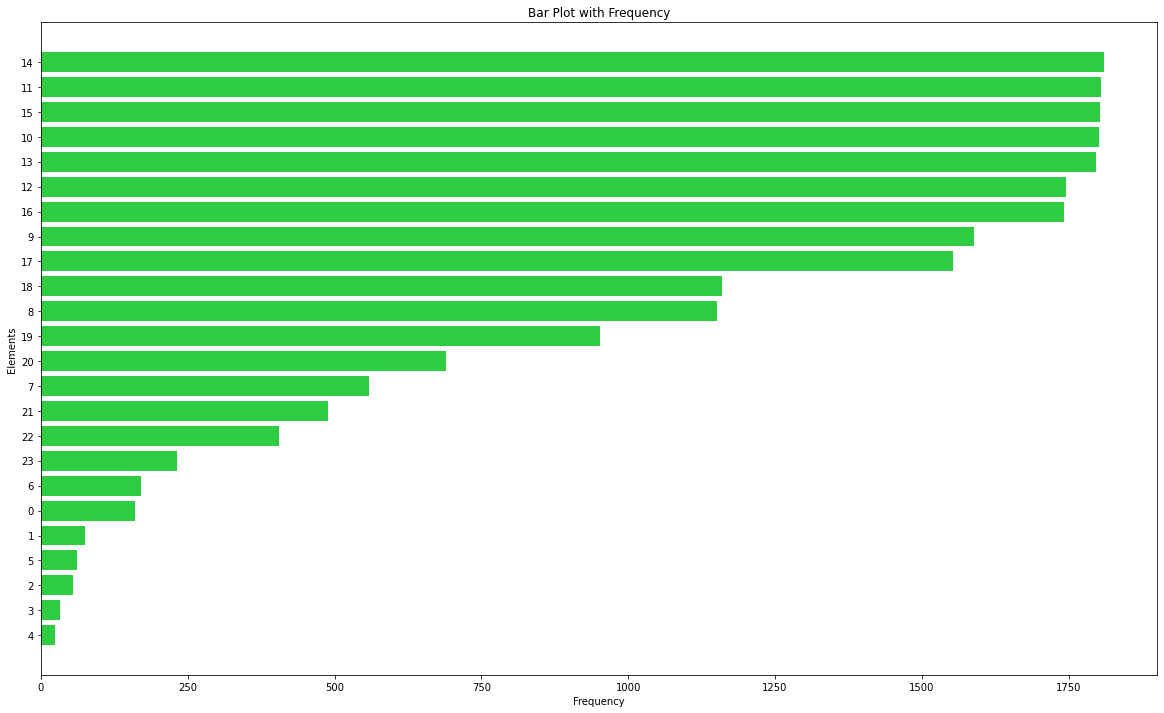

Cluster 3 : 
9: Frequency = 109, Percentage = 9.90%
11: Frequency = 100, Percentage = 9.08%
15: Frequency = 100, Percentage = 9.08%
10: Frequency = 94, Percentage = 8.54%
13: Frequency = 90, Percentage = 8.17%


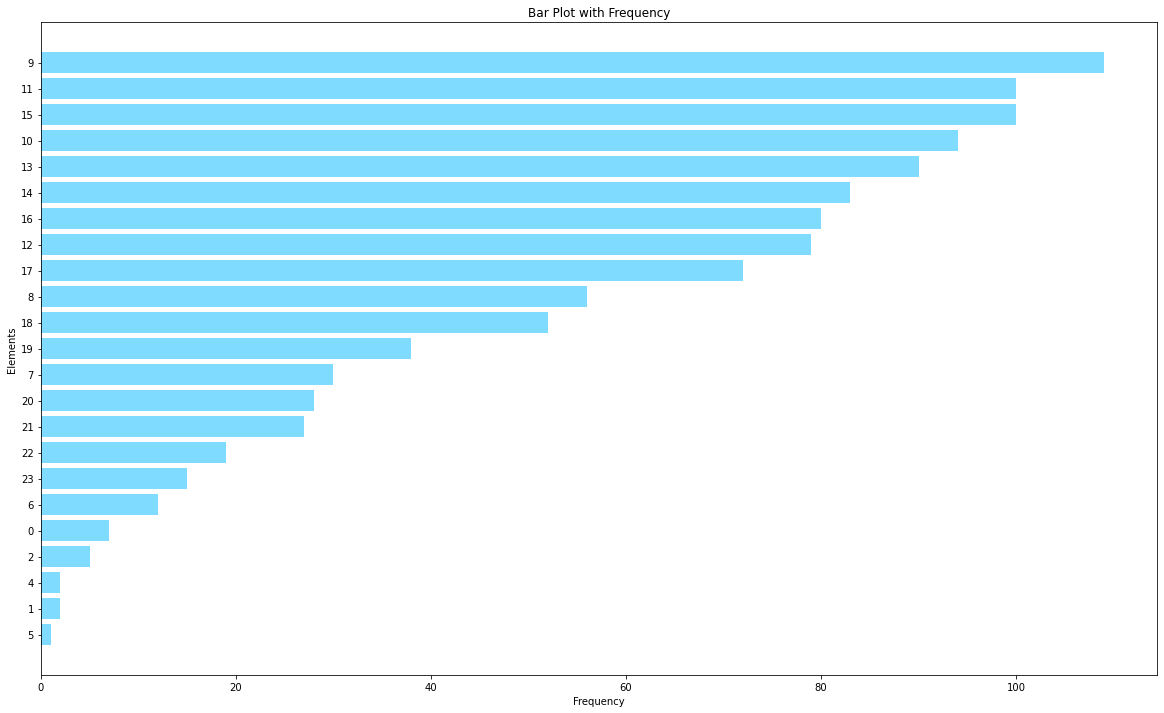

In [192]:
print('Cluster 1 : ')
barPlot2(data0,'order_hour_of_day',"#FF6F20",12)
print('Cluster 2 : ')
barPlot2(data1,'order_hour_of_day',"#2ECC40",12)
print('Cluster 3 : ')
barPlot2(data2,'order_hour_of_day',"#7FDBFF",12)

## Days since prior order

Cluster 1 : 
7.0: Frequency = 3674, Percentage = 13.59%
30.0: Frequency = 3112, Percentage = 11.51%
6.0: Frequency = 2159, Percentage = 7.99%
8.0: Frequency = 2035, Percentage = 7.53%
5.0: Frequency = 1835, Percentage = 6.79%


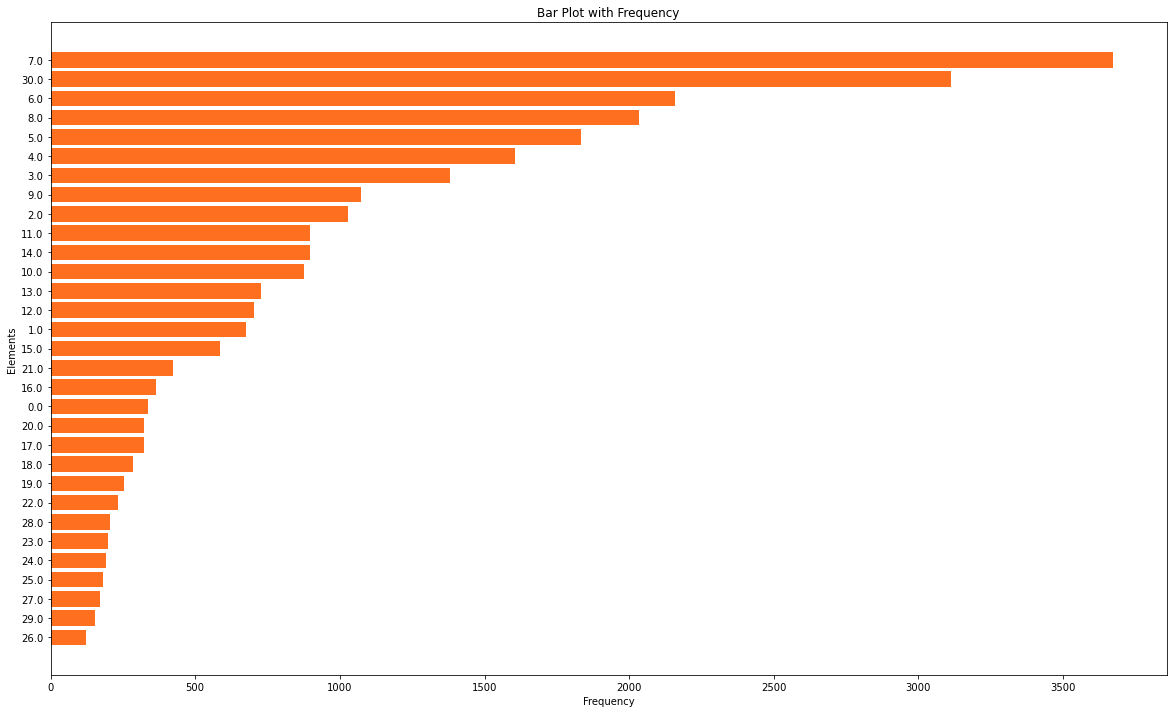

Cluster 2 : 
30.0: Frequency = 3287, Percentage = 15.03%
7.0: Frequency = 2606, Percentage = 11.92%
8.0: Frequency = 1588, Percentage = 7.26%
6.0: Frequency = 1548, Percentage = 7.08%
5.0: Frequency = 1228, Percentage = 5.62%


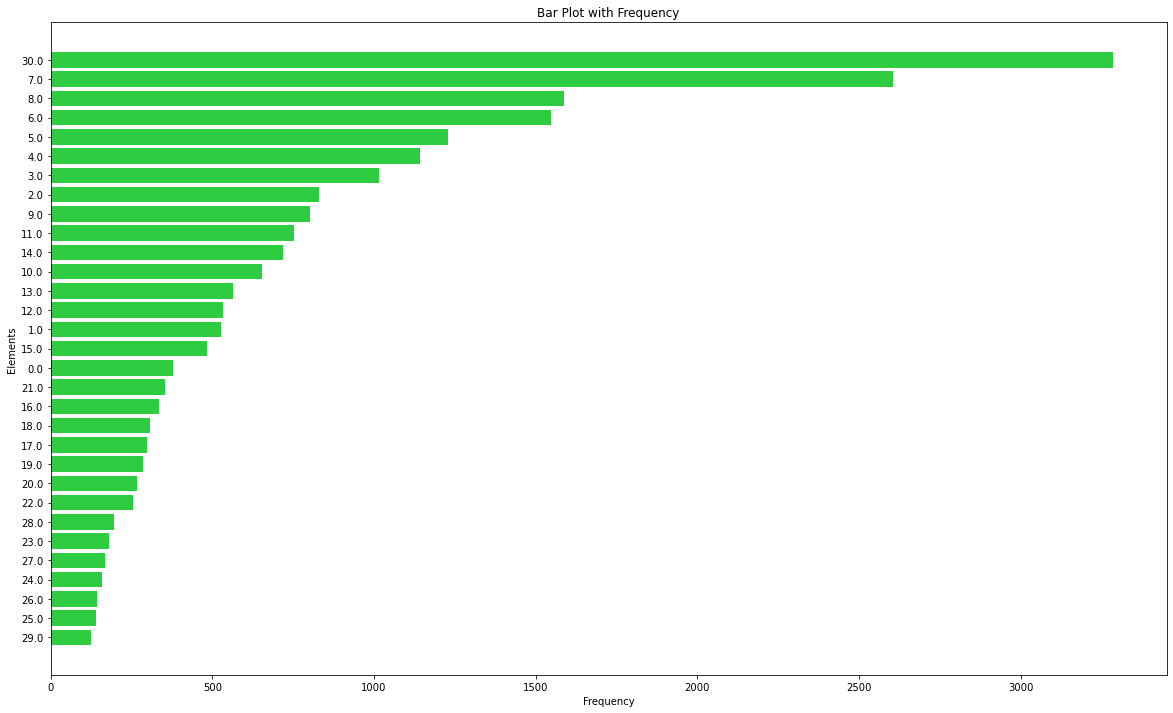

Cluster 3 : 
30.0: Frequency = 228, Percentage = 20.71%
7.0: Frequency = 106, Percentage = 9.63%
8.0: Frequency = 74, Percentage = 6.72%
6.0: Frequency = 59, Percentage = 5.36%
4.0: Frequency = 48, Percentage = 4.36%


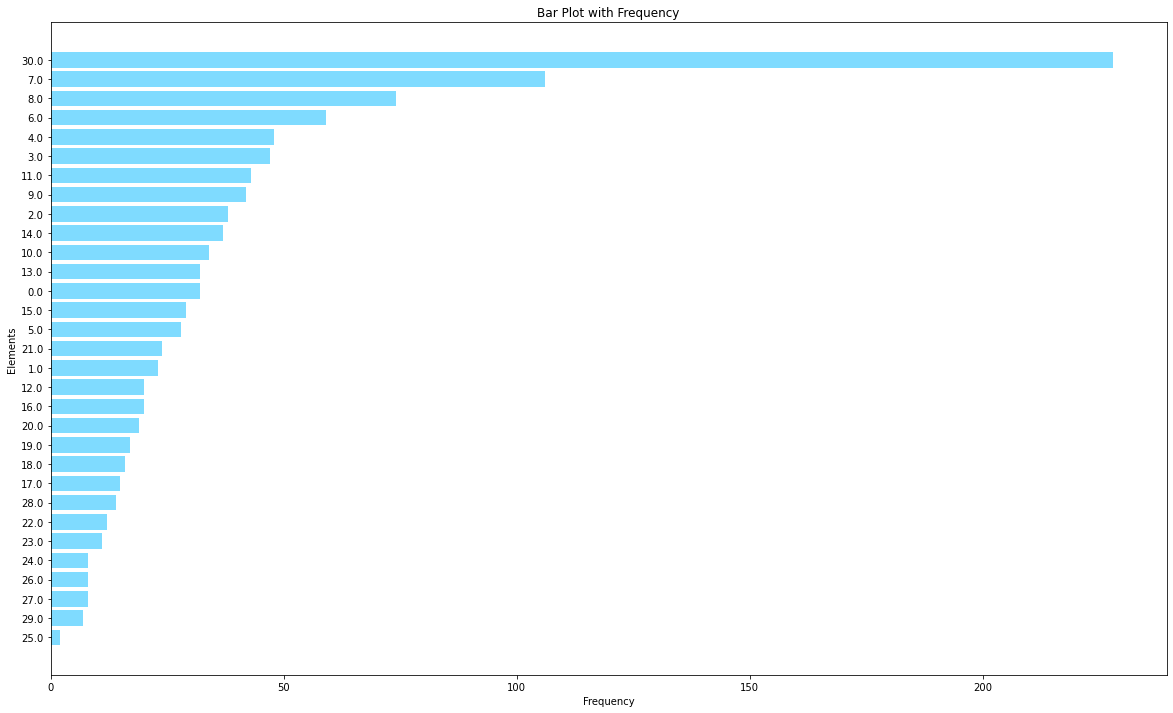

In [194]:
print('Cluster 1 : ')
barPlot2(data0,'days_since_prior_order',"#FF6F20",12)
print('Cluster 2 : ')
barPlot2(data1,'days_since_prior_order',"#2ECC40",12)
print('Cluster 3 : ')
barPlot2(data2,'days_since_prior_order',"#7FDBFF",12)

But consider the fact that " In FMCG industry the cost to acquire a customer after a long stall period is very high. That is the reason you do not have values over 30 because, from the business point of view, it becomes very expensive with little returns" ( from discussion in Kaggle https://www.kaggle.com/datasets/hunter0007/ecommerce-dataset-for-predictive-marketing-2023/discussion/382613)
So maybe it's not a very stable thing and we can see in all three clusters it has a high frequency (meaning our customers usually visit the supermarket in long period of time)

In [196]:
Weekly_purchases =dataCluster_encode[dataCluster_encode['days_since_prior_order'] < 8 ]

In [197]:
len(Weekly_purchases)

22350

on the other hand, we have Weekly purchases too as you can see about half the data(sampling data) related to these purchases 

Weekly purchases : 
fresh fruits: Frequency = 2621, Percentage = 11.73%
fresh vegetables: Frequency = 2399, Percentage = 10.73%
packaged vegetables fruits: Frequency = 1224, Percentage = 5.48%
yogurt: Frequency = 1051, Percentage = 4.70%
packaged cheese: Frequency = 671, Percentage = 3.00%


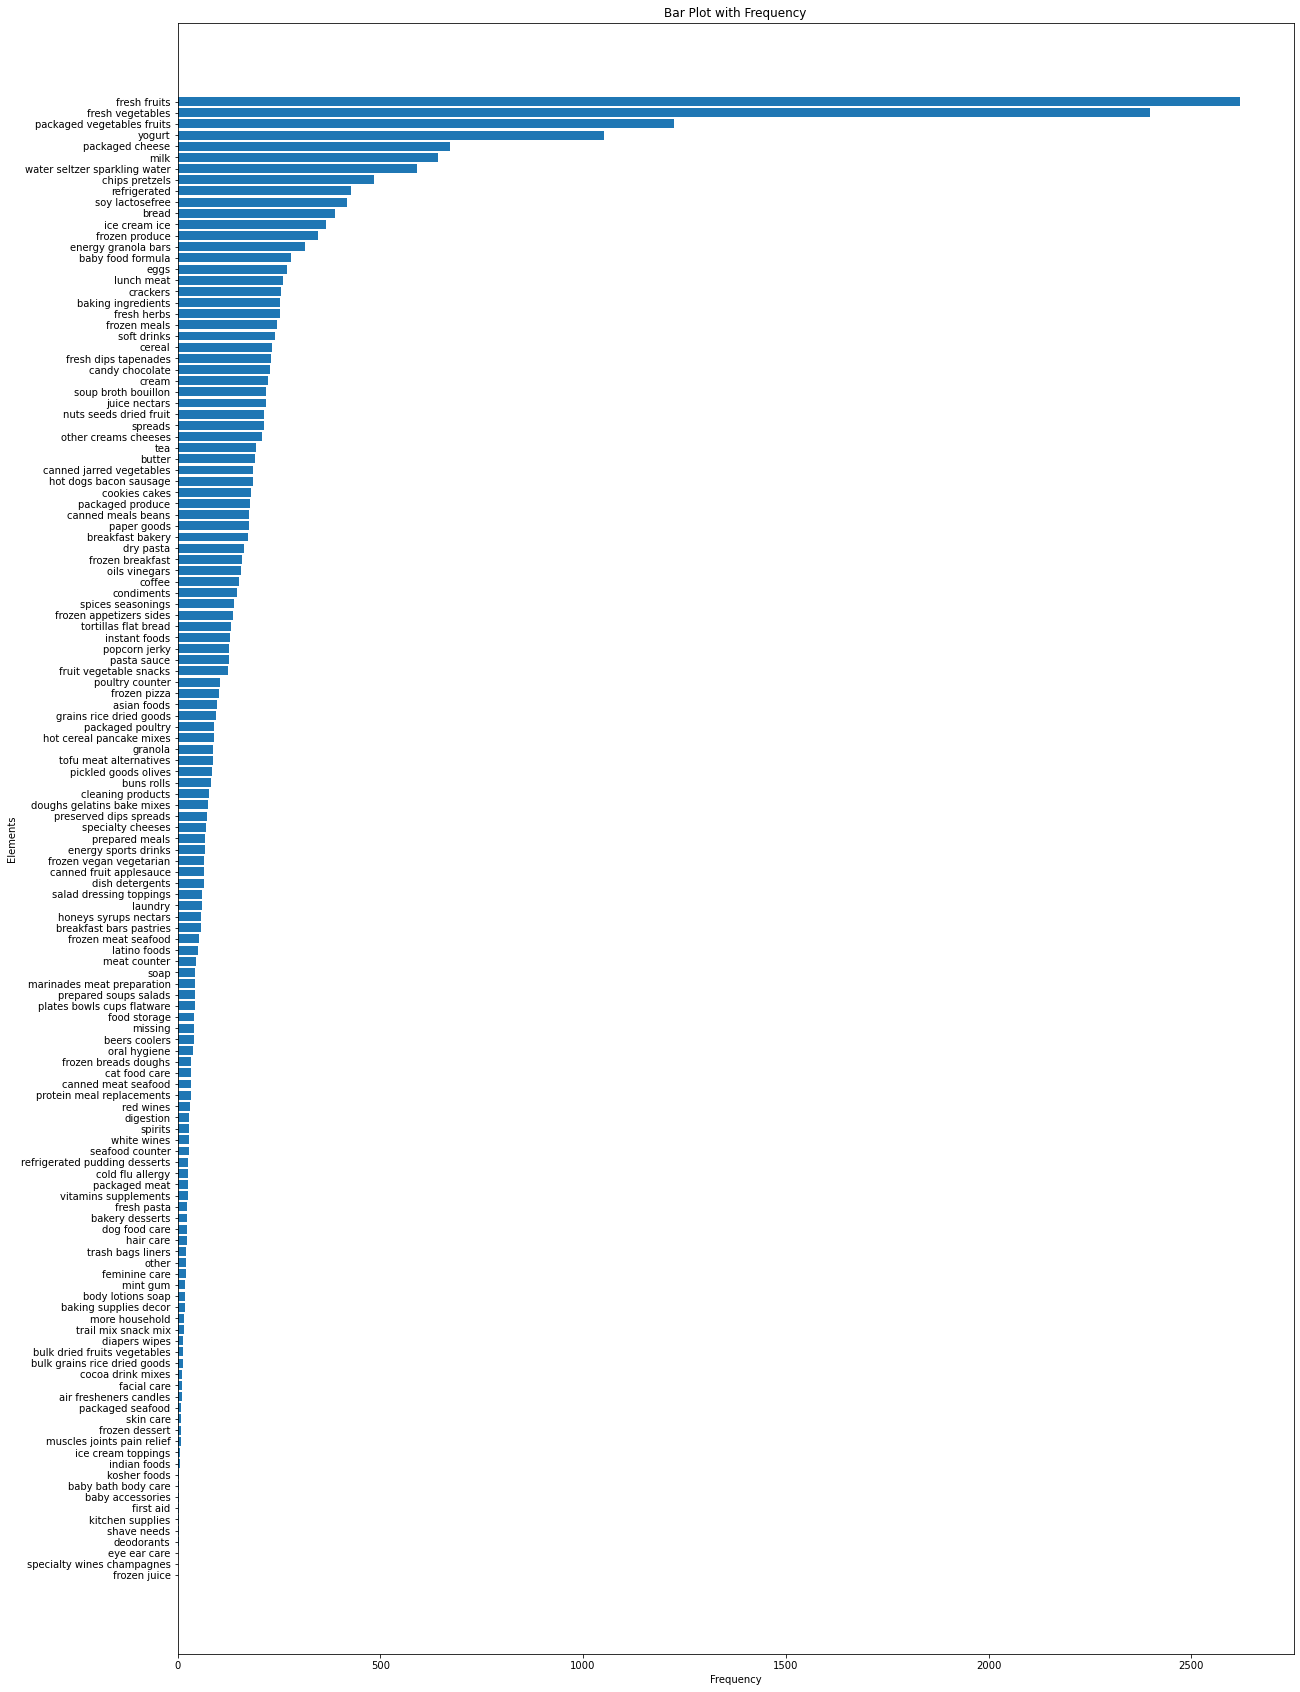

In [199]:
print('Weekly purchases : ')
barPlot2(Weekly_purchases,'product_name',"#1f77b4",30)

as you can guess these purchases are specializes in items that need to be fresh like fresh fruits,fresh vegetables packaged vegetables fruits,dairy(milk ,yogurt and .. ) 

In [206]:
freshITEMS = ['fresh fruits',
 'fresh vegetables',
 'packaged vegetables fruits',
 'yogurt',
 'packaged cheese',
 'milk',
 'water seltzer sparkling water',
 'chips pretzels',
 'refrigerated',
 'soy lactosefree']

In [207]:
fresh = dataCluster_encode.loc[dataCluster_encode['product_name'].isin(freshITEMS)]

In [208]:
fresh

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name,cluster
0,3156984,48318,6,6,22,4.0,24,6,0,4,produce,fresh fruits,0
1,2182099,52983,13,0,16,30.0,83,8,1,4,produce,fresh vegetables,0
2,1249859,51084,5,5,10,10.0,21,7,0,16,dairy eggs,packaged cheese,0
3,511818,47330,15,6,17,30.0,24,3,1,4,produce,fresh fruits,0
4,3230234,146381,29,3,16,6.0,91,15,1,16,dairy eggs,soy lactosefree,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49988,3028209,187784,5,2,10,7.0,120,1,1,16,dairy eggs,yogurt,2
49991,206488,51818,8,2,13,30.0,115,3,1,7,beverages,water seltzer sparkling water,2
49994,773191,78744,1,5,19,30.0,115,4,0,7,beverages,water seltzer sparkling water,2
49995,25948,153299,11,2,15,28.0,84,1,1,16,dairy eggs,milk,2


**more than half of our customer's purchase are include fresh things that they buy in their weekly purchase basket !**

Fresh items order day : 
0: Frequency = 4287, Percentage = 19.18%
1: Frequency = 3804, Percentage = 17.02%
6: Frequency = 3222, Percentage = 14.42%
5: Frequency = 3036, Percentage = 13.58%
3: Frequency = 2716, Percentage = 12.15%


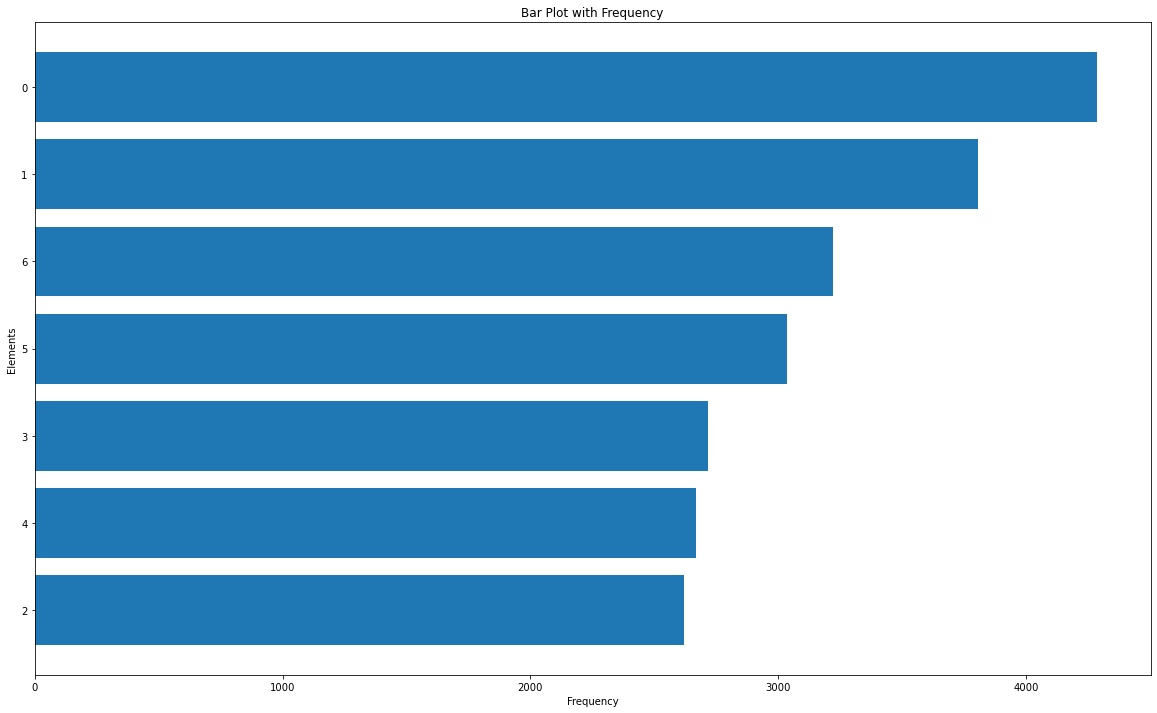

Fresh items hour day : 
10: Frequency = 1909, Percentage = 8.54%
14: Frequency = 1854, Percentage = 8.30%
11: Frequency = 1854, Percentage = 8.30%
13: Frequency = 1839, Percentage = 8.23%
15: Frequency = 1830, Percentage = 8.19%


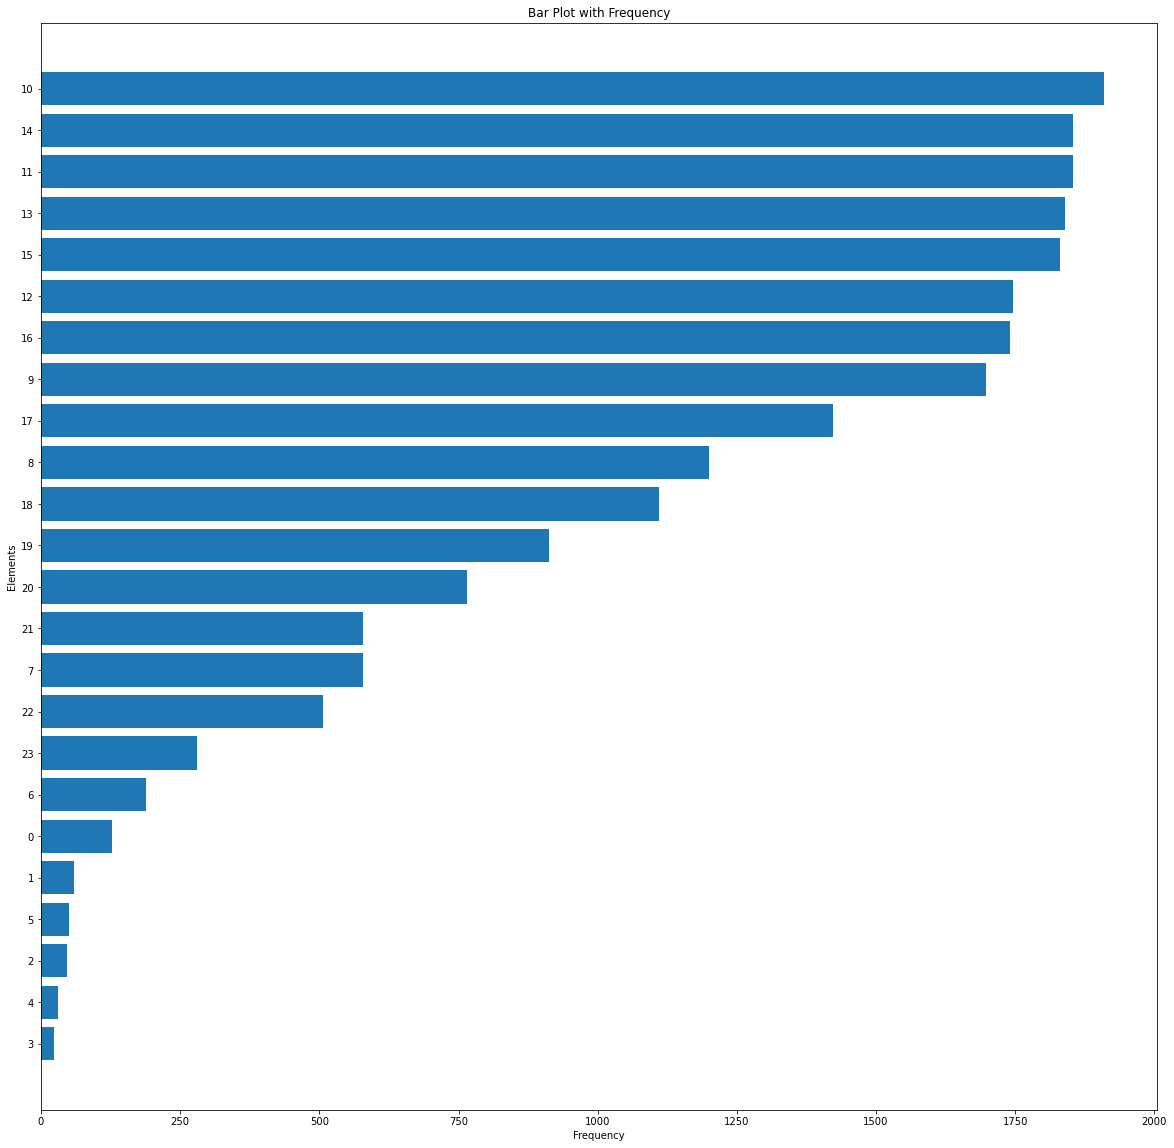

In [209]:
print('Fresh items order day : ')
barPlot2(Weekly_purchases,'order_dow',"#1f77b4",12)
print('Fresh items hour day : ')
barPlot2(Weekly_purchases,'order_hour_of_day',"#1f77b4",20)


<a name="1.8.1"></a>
## Fresh items and weekly purchases

I recommend the owner always charge this item at the beginning of the week and always have these in hours between 10 to 19 and focus on keeping them fresh because they care about this (Buying weekly) Use different sales strategies on these items (especially vegetables and fruits)boxing them for example or any other thing to increase their sales because this is the main products in our supermarket

# 

All product : 
fresh fruits: Frequency = 5733, Percentage = 11.47%
fresh vegetables: Frequency = 5301, Percentage = 10.60%
packaged vegetables fruits: Frequency = 2710, Percentage = 5.42%
yogurt: Frequency = 2283, Percentage = 4.57%
packaged cheese: Frequency = 1539, Percentage = 3.08%


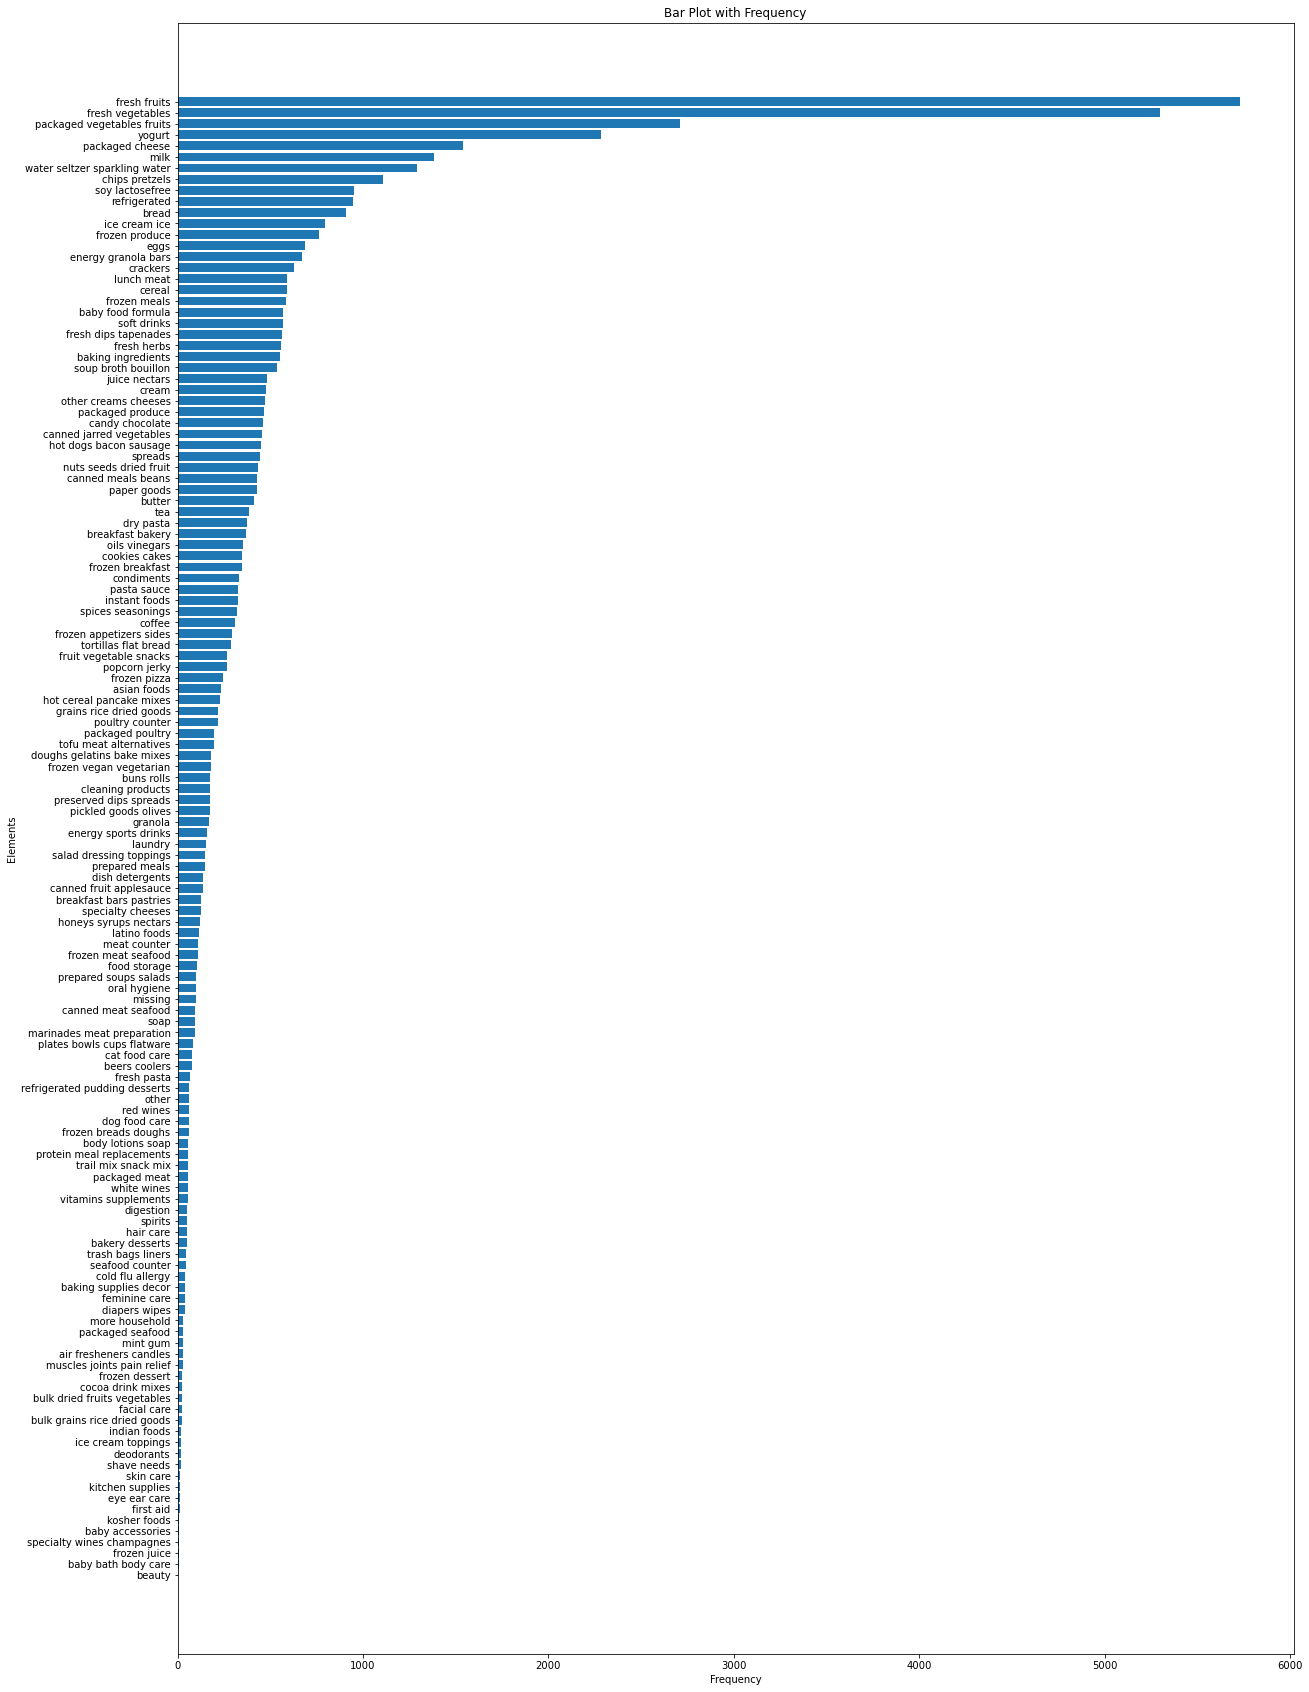

In [233]:
print('All product : ')
barPlot2(dataCluster_encode,'product_name',"#1f77b4",30)

In [269]:
products =['fresh fruits',
 'fresh vegetables',
 'packaged vegetables fruits',
 'yogurt',
 'packaged cheese',
 'milk',
 'water seltzer sparkling water',
 'chips pretzels',
 'soy lactosefree',
 'refrigerated',
 'bread',
 'ice cream ice',
 'frozen produce',
 'eggs',
 'energy granola bars',
 'crackers',
 'lunch meat',
 'cereal',
 'frozen meals',
 'baby food formula',
 'soft drinks',
 'fresh dips tapenades',
 'fresh herbs',
 'baking ingredients',
 'soup broth bouillon',
 'juice nectars',
 'cream',
 'other creams cheeses',
 'packaged produce',
 'candy chocolate',
 'canned jarred vegetables',
 'hot dogs bacon sausage',
 'spreads',
 'nuts seeds dried fruit',
 'canned meals beans',
 'paper goods',
 'butter',
 'tea',
 'dry pasta',
 'breakfast bakery',
 'oils vinegars',
 'cookies cakes',
 'frozen breakfast',
 'condiments',
 'pasta sauce',
 'instant foods',
 'spices seasonings',
 'coffee',
 'frozen appetizers sides',
 'tortillas flat bread',
 'fruit vegetable snacks',
 'popcorn jerky',
 'frozen pizza',
 'asian foods',
 'hot cereal pancake mixes',
 'grains rice dried goods',
 'poultry counter',
 'packaged poultry',
 'tofu meat alternatives',
 'doughs gelatins bake mixes',
 'frozen vegan vegetarian',
 'buns rolls',
 'cleaning products',
 'preserved dips spreads',
 'pickled goods olives',
 'granola',
 'energy sports drinks',
 'laundry',
 'salad dressing toppings',
 'prepared meals',
 'dish detergents',
 'canned fruit applesauce',
 'breakfast bars pastries',
 'specialty cheeses',
 'honeys syrups nectars',
 'latino foods',
 'meat counter',
 'frozen meat seafood',
 'food storage',
 'prepared soups salads',
 'oral hygiene',
 'missing',
 'canned meat seafood',
 'soap',
 'marinades meat preparation',
 'plates bowls cups flatware',
 'cat food care',
 'beers coolers',
 'fresh pasta',
 'refrigerated pudding desserts',
 'other',
 'red wines',
 'dog food care',
 'frozen breads doughs',
 'body lotions soap',
 'protein meal replacements',
 'trail mix snack mix',
 'packaged meat',
 'white wines',
 'vitamins supplements',
 'digestion',
 'spirits',
 'hair care',
 'bakery desserts',
 'trash bags liners',
 'seafood counter',
 'cold flu allergy',
 'baking supplies decor',
 'feminine care',
 'diapers wipes',
 'more household',
 'packaged seafood',
 'mint gum',
 'air fresheners candles',
 'muscles joints pain relief',
 'frozen dessert',
 'cocoa drink mixes',
 'bulk dried fruits vegetables',
 'facial care',
 'bulk grains rice dried goods',
 'indian foods',
 'ice cream toppings',
 'deodorants',
 'shave needs',
 'skin care',
 'kitchen supplies',
 'eye ear care',
 'first aid',
 'kosher foods',
 'baby accessories',
 'specialty wines champagnes',
 'frozen juice',
 'baby bath body care',
 'beauty']

All department : 
produce: Frequency = 14765, Percentage = 29.53%
dairy eggs: Frequency = 8393, Percentage = 16.79%
snacks: Frequency = 4288, Percentage = 8.58%
beverages: Frequency = 4166, Percentage = 8.33%
frozen: Frequency = 3400, Percentage = 6.80%


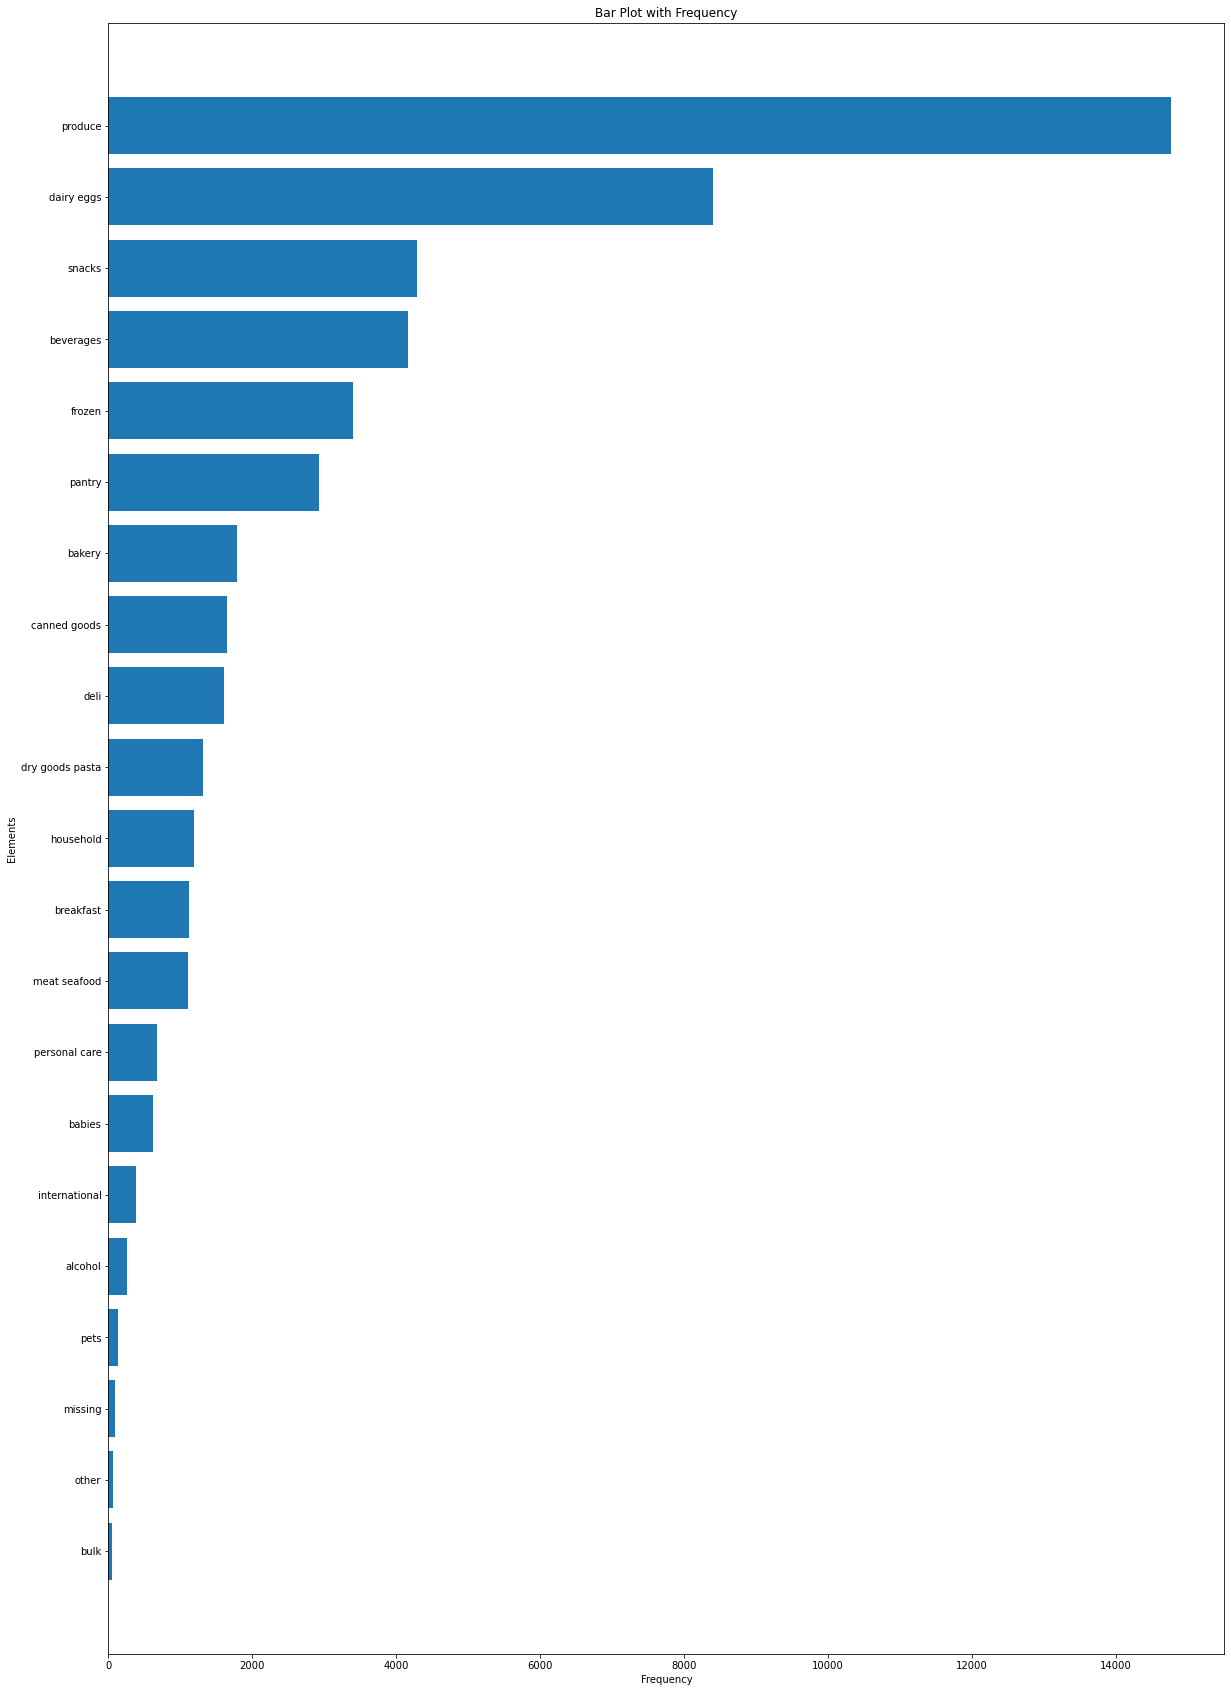

In [264]:
print('All department : ')
barPlot2(dataCluster_encode,'department',"#1f77b4",30)

In [268]:
department = ['produce',
 'dairy eggs',
 'snacks',
 'beverages',
 'frozen',
 'pantry',
 'bakery',
 'canned goods',
 'deli',
 'dry goods pasta',
 'household',
 'breakfast',
 'meat seafood',
 'personal care',
 'babies',
 'international',
 'alcohol',
 'pets',
 'missing',
 'other',
 'bulk']

In [270]:
leastDepartment = department[-8:]

In [272]:
leastDepartment

['personal care',
 'babies',
 'international',
 'alcohol',
 'pets',
 'missing',
 'other',
 'bulk']

In [273]:
leastDepartmentDataset = dataCluster_encode.loc[dataCluster_encode['department'].isin(leastDepartment)]

In [274]:
leastDepartmentDataset

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name,cluster
31,1927388,33731,34,2,15,0.0,126,17,1,11,personal care,feminine care,0
71,2987728,32104,24,4,10,9.0,92,13,0,18,babies,baby food formula,0
91,3393816,165129,2,6,13,10.0,41,2,1,8,pets,cat food care,0
98,1834244,187729,4,3,10,30.0,27,4,0,5,alcohol,beers coolers,0
152,2549553,81391,10,2,11,13.0,92,12,0,18,babies,baby food formula,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49942,2864309,118795,6,0,14,30.0,56,2,0,18,babies,diapers wipes,2
49943,2301097,33049,5,5,17,12.0,92,9,1,18,babies,baby food formula,2
49945,3152636,47608,16,5,12,1.0,66,2,1,6,international,asian foods,2
49966,817943,63473,2,0,15,17.0,66,1,0,6,international,asian foods,2


<a name="1.8.2"></a>
## Diversification or concentration

We have the least product and department sales and we can observe this product are very expensive ones  And things that may be specialized in their certain stores ( for example skincare items , babies or pet or alchol)based on their result this valuable items cant get good result in sales.Due to their high price, perhaps replacing the variety of different products with the variety of brands and the quality of best-selling products will be much more profitable.

# 

In [279]:
dataCluster_encode

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name,cluster
0,3156984,48318,6,6,22,4.0,24,6,0,4,produce,fresh fruits,0
1,2182099,52983,13,0,16,30.0,83,8,1,4,produce,fresh vegetables,0
2,1249859,51084,5,5,10,10.0,21,7,0,16,dairy eggs,packaged cheese,0
3,511818,47330,15,6,17,30.0,24,3,1,4,produce,fresh fruits,0
4,3230234,146381,29,3,16,6.0,91,15,1,16,dairy eggs,soy lactosefree,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,25948,153299,11,2,15,28.0,84,1,1,16,dairy eggs,milk,2
49996,1748665,29199,18,1,11,3.0,107,2,0,19,snacks,chips pretzels,2
49997,1946721,537,3,3,12,0.0,111,5,0,17,household,plates bowls cups flatware,2
49998,2541827,67686,3,1,6,8.0,106,2,0,12,meat seafood,hot dogs bacon sausage,2


,count,mean,std,min,25%,50%,75%,max
add_to_cart_order,50000.0,7.4475,5.437712,1.0,3.0,6.0,11.0,23.0


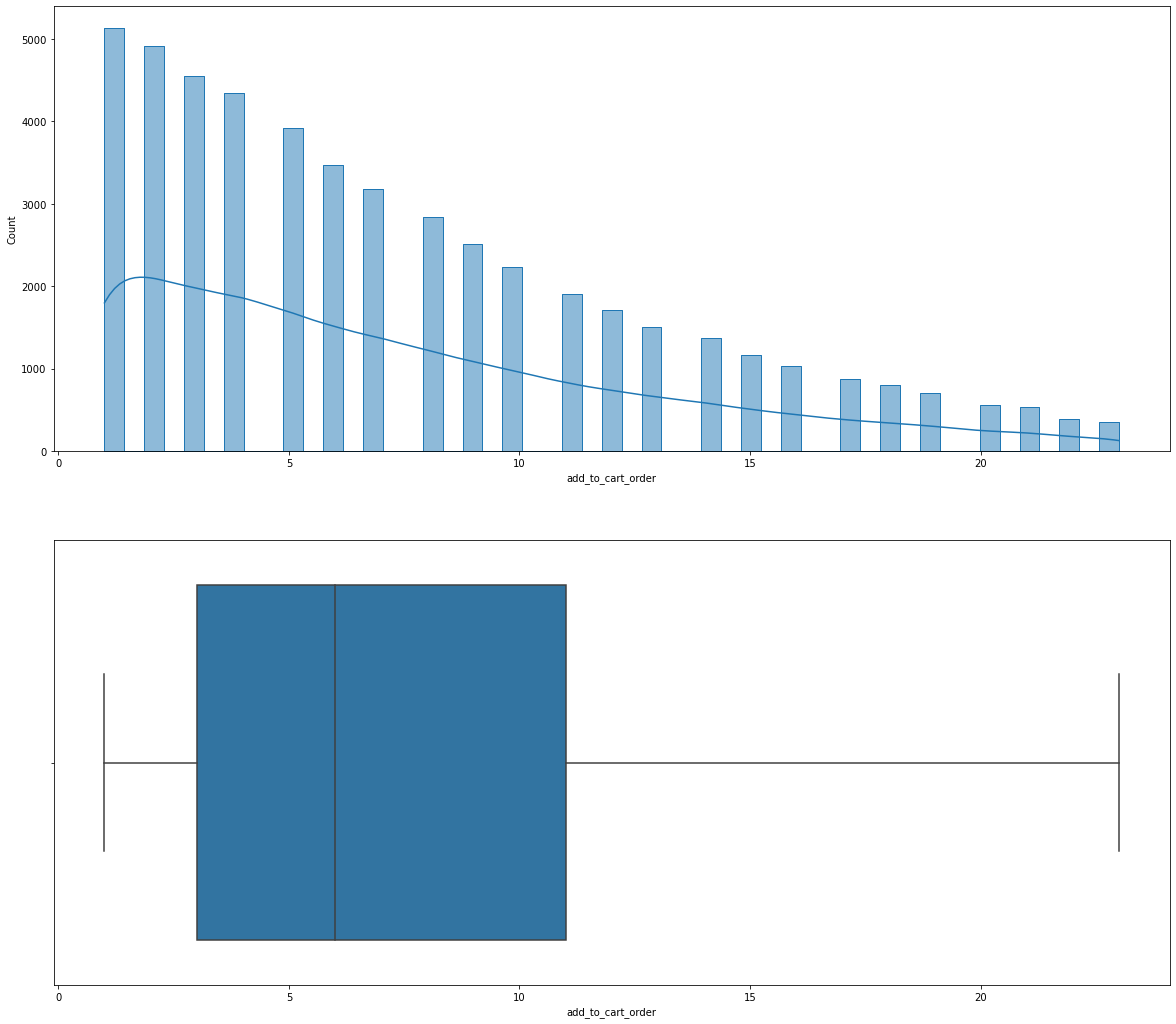

In [280]:
featureAnalysis('add_to_cart_order',dataCluster_encode)

In [281]:
top25 = dataCluster_encode.loc[dataCluster_encode['add_to_cart_order'] > 11]

In [282]:
top25

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name,cluster
4,3230234,146381,29,3,16,6.0,91,15,1,16,dairy eggs,soy lactosefree,0
5,268580,180737,43,6,9,6.0,24,15,1,4,produce,fresh fruits,0
11,2447821,53526,2,1,11,9.0,123,16,1,4,produce,packaged vegetables fruits,0
15,1017389,69845,9,2,12,1.0,94,14,1,7,beverages,tea,0
17,2282725,129926,1,2,13,30.0,119,18,0,1,frozen,frozen dessert,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49750,1675509,198606,2,4,17,30.0,116,13,0,1,frozen,frozen produce,2
49788,465759,194855,20,5,12,14.0,115,12,1,7,beverages,water seltzer sparkling water,2
49814,1481850,77525,2,0,16,30.0,67,13,0,20,deli,fresh dips tapenades,2
49821,593019,185056,14,2,19,2.0,92,12,0,18,babies,baby food formula,2


,count,mean,std,min,25%,50%,75%,max
days_since_prior_order,11007.0,12.74916,9.022225,0.0,6.0,9.0,18.0,30.0


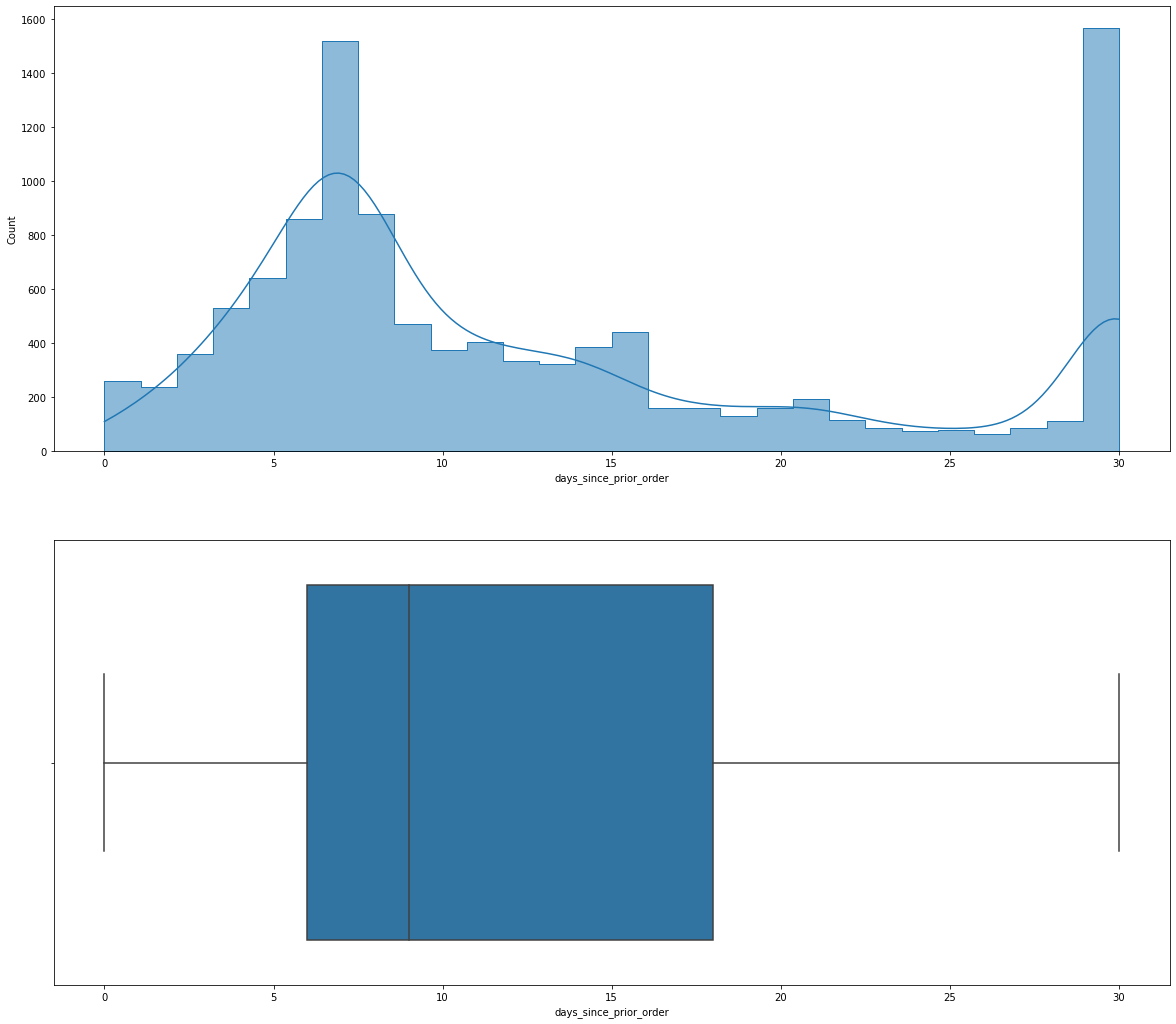

In [283]:
featureAnalysis('days_since_prior_order',top25)

In [284]:
under10top25 = top25.loc[top25['days_since_prior_order'] < 10]

In [285]:
under10top25

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name,cluster
4,3230234,146381,29,3,16,6.0,91,15,1,16,dairy eggs,soy lactosefree,0
5,268580,180737,43,6,9,6.0,24,15,1,4,produce,fresh fruits,0
11,2447821,53526,2,1,11,9.0,123,16,1,4,produce,packaged vegetables fruits,0
15,1017389,69845,9,2,12,1.0,94,14,1,7,beverages,tea,0
18,3241294,191928,3,5,22,6.0,3,12,0,19,snacks,energy granola bars,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49382,5529,20689,3,5,14,4.0,45,14,0,19,snacks,candy chocolate,2
49417,522348,78359,6,2,7,7.0,88,13,0,13,pantry,spreads,2
49530,1789256,52675,6,3,18,9.0,99,12,1,15,canned goods,canned fruit applesauce,2
49617,1857331,139138,31,0,13,4.0,115,14,0,7,beverages,water seltzer sparkling water,2


,count,mean,std,min,25%,50%,75%,max
order_number,5756.0,16.029187,12.370118,1.0,6.0,13.0,25.0,46.0


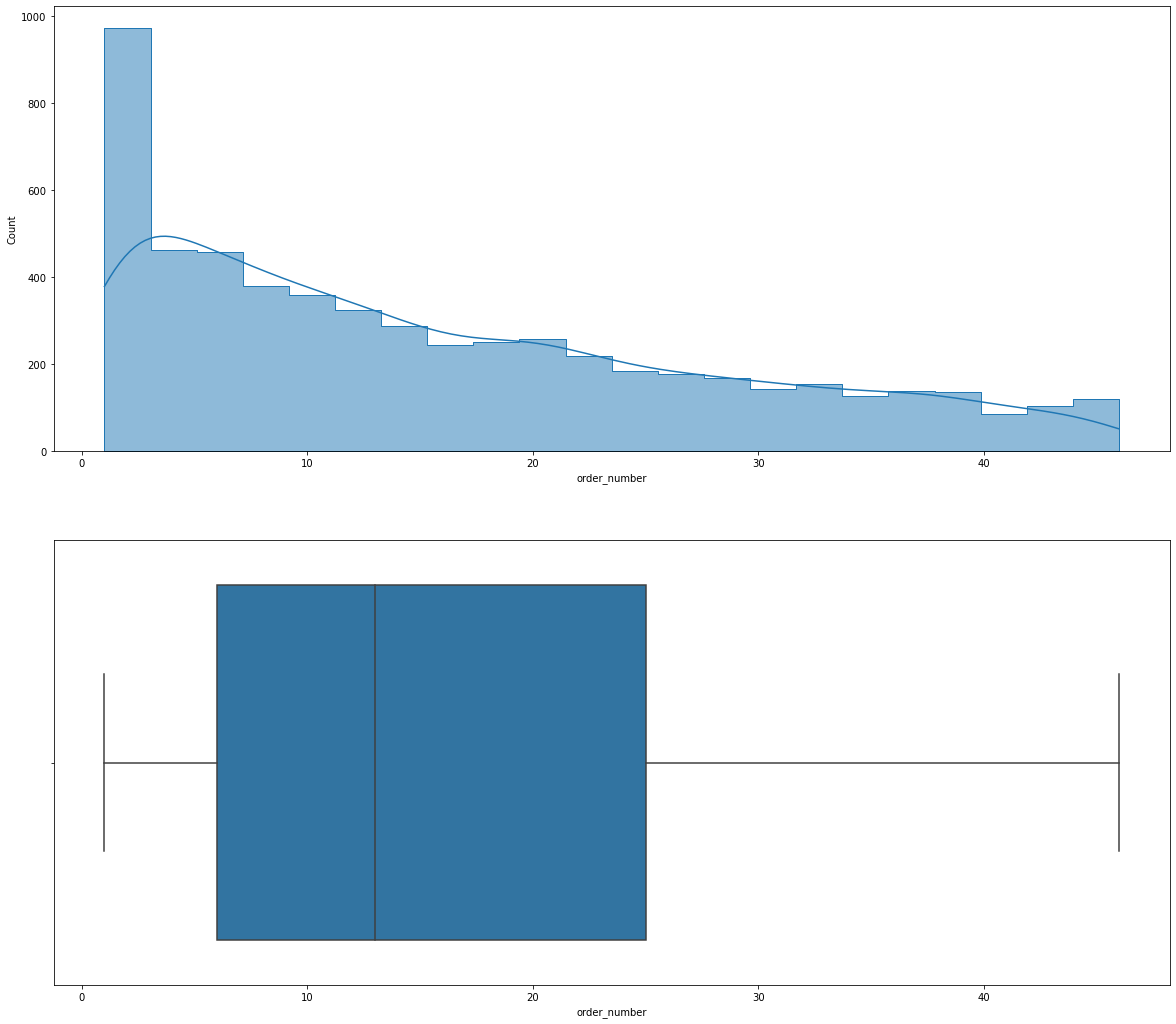

In [298]:
featureAnalysis('order_number',under10top25)

In [305]:
top75under10top25 = under10top25.loc[under10top25['order_number'] > 25]

In [306]:
Fixed_customer = top75under10top25['user_id'].unique().tolist()

In [307]:
len(Fixed_customer)

1165

In [308]:
Fixed_customer =  dataCluster_encode.loc[dataCluster_encode['user_id'].isin(Fixed_customer)]

In [309]:
Fixed_customer

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name,cluster
4,3230234,146381,29,3,16,6.0,91,15,1,16,dairy eggs,soy lactosefree,0
5,268580,180737,43,6,9,6.0,24,15,1,4,produce,fresh fruits,0
10,1035274,14781,8,6,13,3.0,52,8,1,1,frozen,frozen breakfast,0
31,1927388,33731,34,2,15,0.0,126,17,1,11,personal care,feminine care,0
34,1827067,162940,39,4,16,5.0,123,13,1,4,produce,packaged vegetables fruits,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48838,566937,138354,27,1,10,6.0,23,18,1,19,snacks,popcorn jerky,1
48845,3336699,154706,41,4,13,5.0,86,21,1,16,dairy eggs,eggs,1
48897,3161503,18286,46,0,11,8.0,24,12,1,4,produce,fresh fruits,1
49617,1857331,139138,31,0,13,4.0,115,14,0,7,beverages,water seltzer sparkling water,2


<a name="1.8.3"></a>
## Driving customers to become permanent customers

Here, the top tenths of the items that could show that the shop is a regular customer were collected, and these people make up a small percentage, we can add the rest of the customers to this number with policies such as temporary discounting.